This is a notebook that will be used to compare, select, tune, and analyze the best model for multilabel classification when predicting the best Assistance Request (AR) topics that would accompany a given set of features as selected by a user in our Streamlit user interface. It takes inputs of:
* State
* Region
* Declaration Type
* Designated Incident Type(s)
* Emergency Support Function(s) (ESF)

Our model will take these inputs and select the best AR topics that are commonly used in similar situations. These topics were created by our group in a complementary notebook.

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import make_scorer
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.multioutput import MultiOutputClassifier
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from xgboost import XGBClassifier
import optuna
from functools import partial
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import pickle
import warnings

# Load function file
from collected_functions import *


/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set base variable values

In [2]:
random_state = 42
np.random.seed(random_state)
cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': random_state}


Adjust Pandas settings to display more information before truncation.

In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

Load combined Mission Assignment (MA) and Disaster Declaration Summary (DDS) training dataset. We are using data generated from the previous multilabel classification model (which predicted ESFs) combined with user selections from our user interface to predict Assistance Requested (AR) topics based on the features state, region, designatedIncidentType, declarationType, and ESF(s).

In [4]:
df = pd.read_parquet('combined_training_set_nontime.parquet')
df['AR_topic'] = df['AR_topic'].astype(str)
df.rename(columns={'supportFunction': 'ESF'}, inplace=True)
print(df.shape)
df.head()

(6765, 22)


incidentId state  incidentTypeMA  region maType maPriority   ESF  agencyId  \
0  2024081901    CT    Severe Storm       1    FOS       High   5.0  DOI-USGS   
1  2024072801    FL  Tropical Storm       4    FOS     Normal   8.0        VA   
2  2024072801    FL  Tropical Storm       4    FOS     Normal   0.0        VA   
3  2024072801    FL  Tropical Storm       4    FOS     Normal   4.0   USDA-FS   
4  2024072801    FL  Tropical Storm       4    FOS     Normal  11.0  USDA-APH   

                 maId declarationType  \
0  3612EMCTDOI-USGS01              EM   
1        4806DRFLVA02              DR   
2        4806DRFLVA01              DR   
3   4806DRFLUSDA-FS01              DR   
4  4806DRFLUSDA-APH01              DR   

                                 assistanceRequested  \
0  USGS Field measurements of flood-water heights...   
1  Activate VHA OEM to NRCC ESF-8 PHMS. This is a...   
2  Activate VA to NRCC. This is a re-issuance of ...   
3  Activate USFS to the NRCC. This is a re-issuan...   
4  USDA liaison(s) to the NRCC, FEMA teams, or ot...   

                                     statementOfWork femaDeclarationString  \
0  As directed by and in coordination with FEMA, ...            EM-3612-CT   
1  As directed by and in coordination with FEMA a...            DR-4806-FL   
2  As directed by and in coordination with FEMA, ...            DR-4806-FL   
3  As directed by and in coordination with FEMA, ...            DR-4806-FL   
4  As directed by and in coordination with FEMA, ...            DR-4806-FL   

     incidentType         incidentBeginDate  fipsStateCode  \
0    Severe Storm 2024-08-18 00:00:00+00:00            9.0   
1  Tropical Storm 2024-08-01 00:00:00+00:00           12.0   
2  Tropical Storm 2024-08-01 00:00:00+00:00           12.0   
3  Tropical Storm 2024-08-01 00:00:00+00:00           12.0   
4  Tropical Storm 2024-08-01 00:00:00+00:00           12.0   

            designatedIncidentTypes  \
0  Severe Storm,Flood,Mud/Landslide   
1          Hurricane,Tropical Storm   
2          Hurricane,Tropical Storm   
3          Hurricane,Tropical Storm   
4          Hurricane,Tropical Storm   

                                    declarationTitle    year  month   day  \
0  SEVERE STORMS, FLOODING, LANDSLIDES, AND MUDSL...  2024.0    8.0  18.0   
1                                    HURRICANE DEBBY  2024.0    8.0   1.0   
2                                    HURRICANE DEBBY  2024.0    8.0   1.0   
3                                    HURRICANE DEBBY  2024.0    8.0   1.0   
4                                    HURRICANE DEBBY  2024.0    8.0   1.0   

  AR_topic  
0       28  
1       23  
2       23  
3       30  
4       32

Transform the training data set using an approach that is suitable for multiple categorical feature columns and a multilabel target. We return the transformers so that the test data set can be transformed later.

In [5]:
feature_columns = [
    'incidentId',
    'state',
    'designatedIncidentTypes',
    'declarationType',
    'region',
    'ESF',
    'year',
]

grouping_columns = [
    'incidentId',
    'state',
    'region',
    'year',
    'declarationType',
    'designatedIncidentTypes',
]

list_set_columns = [
    'ESF',
    'AR_topic',
]

target_column = 'AR_topic'

X_train, y_train = create_set_AR(
    df,
    grouping_columns,
    list_set_columns,
    feature_columns,
    target_column)

print(X_train.shape, len(y_train))
print(y_train[:5])
X_train.head(5)

(464, 7) 464
0          [13]
25         [13]
23         [13]
22         [92]
21    [118, 73]
Name: AR_topic, dtype: object


incidentId state designatedIncidentTypes declarationType  region  \
0   2013020801    CT            Severe Storm              DR       1   
25  2014012201    OK            Severe Storm              DR       6   
23  2013122601    VT        Severe Ice Storm              DR       1   
22  2013111701    IL                 Tornado              DR       5   
21  2013110101    SD            Severe Storm              DR       8   

            ESF    year  
0         [7.0]  2013.0  
25        [7.0]  2013.0  
23        [7.0]  2013.0  
22        [7.0]  2013.0  
21  [11.0, 7.0]  2013.0

In [6]:
# Check a known incidentId to verify our data is formatted as expected.
X_train[X_train['incidentId']==2024072801]

incidentId state                            designatedIncidentTypes  \
419  2024072801    SC             Flood,Tornado,Hurricane,Tropical Storm   
420  2024072801    SC                     Flood,Hurricane,Tropical Storm   
421  2024072801    VT                 Tropical Depression,Tropical Storm   
418  2024072801    PA                               Flood,Tropical Storm   
416  2024072801    GA                           Hurricane,Tropical Storm   
415  2024072801    GA                           Hurricane,Tropical Storm   
414  2024072801    FL  Coastal Storm,Tropical Storm,Severe Storm,Floo...   
417  2024072801    NC                                     Tropical Storm   
413  2024072801    FL                           Hurricane,Tropical Storm   

    declarationType  region  \
419              DR       4   
420              EM       4   
421              EM       1   
418              DR       3   
416              EM       4   
415              DR       4   
414              EM       4   
417              EM       4   
413              DR       4   

                                                   ESF    year  
419                                         [8.0, 3.0]  2024.0  
420                                    [8.0, 3.0, 7.0]  2024.0  
421                                  [3.0, 11.0, 13.0]  2024.0  
418                                              [7.0]  2024.0  
416                                         [0.0, 7.0]  2024.0  
415                               [0.0, 9.0, 3.0, 4.0]  2024.0  
414  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...  2024.0  
417                                         [8.0, 7.0]  2024.0  
413  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...  2024.0

In [7]:
y_train

0                                                   [13]
25                                                  [13]
23                                                  [13]
22                                                  [92]
21                                             [118, 73]
                             ...                        
450       [18, 97, 42, 85, 37, 14, 38, 34, 8, 50, 4, 84]
448    [73, 30, 8, 50, 19, 100, 71, 16, 14, 65, 38, 4...
462                           [38, 4, 2, 23, 105, 1, 80]
454                                     [38, 2, 103, 32]
463                                                 [92]
Name: AR_topic, Length: 464, dtype: object

In [8]:
# Verify that no row is missing an AR topic
y_train.isna().sum()

np.int64(0)

In [9]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_train['designatedIncidentTypes'] = X_train['designatedIncidentTypes'].str.split(',')


In [10]:
# Check a known incidentId to verify our data is formatted as expected.
X_train[X_train['incidentId']==2024072801]

incidentId state                            designatedIncidentTypes  \
419  2024072801    SC        [Flood, Tornado, Hurricane, Tropical Storm]   
420  2024072801    SC                 [Flood, Hurricane, Tropical Storm]   
421  2024072801    VT              [Tropical Depression, Tropical Storm]   
418  2024072801    PA                            [Flood, Tropical Storm]   
416  2024072801    GA                        [Hurricane, Tropical Storm]   
415  2024072801    GA                        [Hurricane, Tropical Storm]   
414  2024072801    FL  [Coastal Storm, Tropical Storm, Severe Storm, ...   
417  2024072801    NC                                   [Tropical Storm]   
413  2024072801    FL                        [Hurricane, Tropical Storm]   

    declarationType  region  \
419              DR       4   
420              EM       4   
421              EM       1   
418              DR       3   
416              EM       4   
415              DR       4   
414              EM       4   
417              EM       4   
413              DR       4   

                                                   ESF    year  
419                                         [8.0, 3.0]  2024.0  
420                                    [8.0, 3.0, 7.0]  2024.0  
421                                  [3.0, 11.0, 13.0]  2024.0  
418                                              [7.0]  2024.0  
416                                         [0.0, 7.0]  2024.0  
415                               [0.0, 9.0, 3.0, 4.0]  2024.0  
414  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...  2024.0  
417                                         [8.0, 7.0]  2024.0  
413  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...  2024.0

In [11]:
# Since designatedIncidentTypes is a list it must be transformed differently than the other
# feature columns.
feature_columns_transform = [
    'state',
    'declarationType',
    'region',

]

X_train_transformed, y_train_transformed, preprocessor_X, preprocessor_y = transform_x_y_train(
    X_train,
    y_train,
    feature_columns_transform,
    ['designatedIncidentTypes', 'ESF'],
    target_column,
    'cluster_'
)

In [12]:
X_train_transformed

state_AK  state_AL  state_AR  state_AS  state_AZ  state_CA  state_CO  \
0         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
459       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
460       0.0       0.0       0.0       0.0       0.0       1.0       0.0   
461       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
462       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
463       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     state_CT  state_DC  state_DE  state_FL  state_GA  state_GU  state_HI  \
0         1.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
459       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
460       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
461       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
462       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
463       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     state_IA  state_ID  state_IL  state_IN  state_KS  state_KY  state_LA  \
0         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       0.0       1.0       0.0       0.0       0.0       0.0   
4         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
459       0.0       0.0       0.0       0.0       0.0       1.0       0.0   
460       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
461       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
462       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
463       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     state_MA  state_MD  state_ME  state_MI  state_MN  state_MO  state_MP  \
0         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
459       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
460       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
461       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
462       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
463       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     state_MS  state_MT  state_NC  state_ND  state_NE  state_NH  state_NJ  \
0         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0 

In [13]:
# Drop year and incidentId from X_train_transformed.
X_train_transformed.drop(columns=['incidentId', 'year'], inplace=True)

print(X_train_transformed.shape)
X_train_transformed.head()

(464, 105)


state_AK  state_AL  state_AR  state_AS  state_AZ  state_CA  state_CO  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_CT  state_DC  state_DE  state_FL  state_GA  state_GU  state_HI  \
0       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_IA  state_ID  state_IL  state_IN  state_KS  state_KY  state_LA  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_MA  state_MD  state_ME  state_MI  state_MN  state_MO  state_MP  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_MS  state_MT  state_NC  state_ND  state_NE  state_NH  state_NJ  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_NM  state_NV  state_NY  state_OH  state_OK  state_OR  state_PA  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       1.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_PR  state_RI  state_SC  state_SD  state_TN  state_TX  state_UT  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       1.0       0.0       0.0       0.0   

   state_VA  state_VI  state_VT  state_WA  state_WI  state_WV  state_WY  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   declarationType_DR  declarationType_EM  region_1  region_2  region_3  \
0                 1.0                 0.0       1.0       0.0       0.0   
1                 1.0                 0.0       0.0       0.0       0.0   
2                 1.0                 0.0       1.0       0.0       0.0   
3                 1.0                 0.0       0.0       0.0       0.0   
4                 1.

In [14]:
X_train_transformed.columns.tolist()

['state_AK',
 'state_AL',
 'state_AR',
 'state_AS',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_GU',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MP',
 'state_MS',
 'state_MT',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ',
 'state_NM',
 'state_NV',
 'state_NY',
 'state_OH',
 'state_OK',
 'state_OR',
 'state_PA',
 'state_PR',
 'state_RI',
 'state_SC',
 'state_SD',
 'state_TN',
 'state_TX',
 'state_UT',
 'state_VA',
 'state_VI',
 'state_VT',
 'state_WA',
 'state_WI',
 'state_WV',
 'state_WY',
 'declarationType_DR',
 'declarationType_EM',
 'region_1',
 'region_2',
 'region_3',
 'region_4',
 'region_5',
 'region_6',
 'region_7',
 'region_8',
 'region_9',
 'region_10',
 'designatedIncidentTypes_Biological',
 'designatedIncidentTypes_Chemical',
 'designatedInciden

In [15]:
print(y_train_transformed.shape)
y_train_transformed.head()

(464, 126)


cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          0           0            0            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0            0           0            0            0   
1            0            0           0            0            0   
2            0            0           0            0            0   
3            0            0           0            0            0   
4            0            0           0            0            0   

   cluster_112  cluster_113  cluster_114  cluster_115  cluster_116  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_117  cluster_118  cluster_119  cluster_12  cluster_120  \
0            0            0            0           0            0   
1            0            0            0           0            0   
2            0            0            0           0            0   
3            0            0            0           0            0   
4            0            1            0           0            0   

   cluster_121  cluster_122  cluster_123  cluster_124  cluster_125  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_13  cluster_14  cluster_15  cluster_16  cluster_17  cluster_18  \
0           1           0           0           0           0           0   
1           1           0           0           0           0           0   
2           1           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   cluster_19  cluster_2  cluster_20  cluster_21  cluster_22  cluster_23  \
0           0          0           0           0           0           0   
1           0          0           0           0           0           0   
2           0          0           0           0           0           0   
3           0          0           0           0           0           0   
4           0          0           0           0           0           0   

   cluster_24  cluster_25  cluster_26  cluster_27  cluster_28  cluster_29  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   cluster_3  cluster_30  cluster_31  cluster_32  cluster_

In [16]:
y_train_transformed.isna().sum().sum()

np.int64(0)

In [17]:
y_train_transformed.columns.tolist()

['cluster_0',
 'cluster_1',
 'cluster_10',
 'cluster_100',
 'cluster_101',
 'cluster_102',
 'cluster_103',
 'cluster_104',
 'cluster_105',
 'cluster_106',
 'cluster_107',
 'cluster_108',
 'cluster_109',
 'cluster_11',
 'cluster_110',
 'cluster_111',
 'cluster_112',
 'cluster_113',
 'cluster_114',
 'cluster_115',
 'cluster_116',
 'cluster_117',
 'cluster_118',
 'cluster_119',
 'cluster_12',
 'cluster_120',
 'cluster_121',
 'cluster_122',
 'cluster_123',
 'cluster_124',
 'cluster_125',
 'cluster_13',
 'cluster_14',
 'cluster_15',
 'cluster_16',
 'cluster_17',
 'cluster_18',
 'cluster_19',
 'cluster_2',
 'cluster_20',
 'cluster_21',
 'cluster_22',
 'cluster_23',
 'cluster_24',
 'cluster_25',
 'cluster_26',
 'cluster_27',
 'cluster_28',
 'cluster_29',
 'cluster_3',
 'cluster_30',
 'cluster_31',
 'cluster_32',
 'cluster_33',
 'cluster_34',
 'cluster_35',
 'cluster_36',
 'cluster_37',
 'cluster_38',
 'cluster_39',
 'cluster_4',
 'cluster_40',
 'cluster_41',
 'cluster_42',
 'cluster_43',
 'cl

# Model Selection and Tuning

Here we run a variety of machine learning models and base classifiers using cross validation to narrow our picks down to a few models for selection purposes. We are using RandomForestClassifier instead of SVC in this case as we have a very sparse target dataset which triggers a lot of SVC warnings.

In [ ]:
base_rf = RandomForestClassifier(
        random_state=random_state,
        n_jobs=-1,
        max_depth=12,
        n_estimators=100,
        )
base_xgb = XGBClassifier(
        max_depth=12,
        random_state=random_state,
        n_estimators=100,
        base_score=0.5,
        n_jobs=-1,
        )
base_gnb = GaussianNB()

br_classifier_rf = BinaryRelevance(
    classifier = base_rf,
    require_dense = [True, True]
)
br_classifier_xgb = BinaryRelevance(
    classifier = base_xgb,
    require_dense = [True, True]
)
br_classifier_gnb = BinaryRelevance(
    classifier = base_gnb,
    require_dense = [True, True]
)

cc_classifier_rf = ClassifierChain(
    classifier=base_rf, 
    require_dense=[True, True],
)
cc_classifier_xgb = ClassifierChain(
    classifier=base_xgb,
    require_dense=[True, True],
)
cc_classifier_gnb = ClassifierChain(
    classifier=base_gnb,
    require_dense=[True, True],
)

# Check performance of sklearn models that can natively handle multiclass targets.
base_rf = RandomForestClassifier(
    random_state=random_state,
    n_jobs=-1,
    max_depth=12,
    n_estimators=100,
    class_weight='balanced_subsample'
)

base_etc = ExtraTreesClassifier(
    random_state=random_state,
    max_depth=12,
    n_jobs=-1,
    class_weight='balanced_subsample',
)

# Finish with sklearn models that require a base estimator.
moc_rf = MultiOutputClassifier(estimator=base_rf)
moc_xgb = MultiOutputClassifier(estimator=base_xgb)
moc_gnb = MultiOutputClassifier(estimator=base_gnb)

ovr_rf = OneVsRestClassifier(estimator=base_rf)
ovr_xgb = OneVsRestClassifier(estimator=base_xgb)
ovr_gnb = OneVsRestClassifier(estimator=base_gnb)

dummy = OneVsRestClassifier(DummyClassifier(strategy="stratified", random_state=random_state))

clf_list = [
    br_classifier_rf,
    br_classifier_xgb,
    br_classifier_gnb,
    cc_classifier_rf,
    cc_classifier_xgb,
    cc_classifier_gnb,
    base_rf,
    base_etc,
    moc_rf,
    moc_xgb,
    moc_gnb,
    ovr_rf,
    ovr_xgb,
    ovr_gnb,
    dummy,
]

hamming_scorer = make_scorer(
    hamming_loss,
    greater_is_better=False, 
)

F1_Macro_Avg = make_scorer(
    f1_score,
    average='macro', 
    zero_division=1,
)

F1_Samples_Avg = make_scorer(
    f1_score,
    average='samples', 
    zero_division=1,
)

# include mAP with the understanding that some of our models output sparse arrays which
# does not work in our scoring setup using cross_validate.
mean_average_precision = make_scorer(
    average_precision_score,
    average='macro', 
)

scoring = {
    'Hamming':hamming_scorer,
    'F1_Macro_Avg':F1_Macro_Avg,
    'F1_Samples_Avg':F1_Samples_Avg,
    'mAP':mean_average_precision,
}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list:
        cross_val_results = cross_validate(clf,
                                        X=X_train_transformed,
                                        y=y_train_transformed,
                                        cv=5,
                                        scoring=scoring,
                                        n_jobs=-1,
                                        )

        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')

BinaryRelevance(classifier=RandomForestClassifier(max_depth=12, n_jobs=-1,
                                                  random_state=42),
                require_dense=[True, True])
Mean Hamming: -0.05610821701284534, 0.009978369873718236

Mean F1 Macro Avg: 0.3312183740031058, 0.06144067487627108

Mean F1 Samples Avg: 0.188470391447427, 0.050738256186138864

Mean Average Precision Avg: nan, nan
BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         feature_weights=None, gamma=None,
             

XGBoost appears to be our best base model. RandomForestClassifier is responding similarly but just a bit worse. The most promising models again appear to be BinaryRelevance, ClassifierChain, and OneVsRestClassifier (MultiOutputClassification had similar results but based on findings OneVsRestClassifier is supposed to be better suited to this sort of task per documentation).

The standalone RandomForestClassifier and ExtraTreesClassifier do not perform nearly as well as the more specialized models from skmultilearn. We will not move forward with them.

We can start with hyperparameter tuning of BinaryRelevance and the XGBoost base classifier.

In [19]:
def objective_brxgb(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': 1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'tree_method': 'hist',
    }

    base_XGB = XGBClassifier(**xgb_params)
    
    clf = BinaryRelevance(
        classifier = base_XGB,
        require_dense = [True, True],
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())
        scores.append(eval_scorer)

    return np.mean(scores)

objective_brxgb = partial(objective_brxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state = random_state,
                        )

# Maximize the score to improve results
study_brxgb = optuna.create_study(direction="maximize")

study_brxgb.optimize(objective_brxgb,
                     n_trials=60,
                     show_progress_bar=True,
                     n_jobs=8,
                     )

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_brxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_brxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-30 08:31:52,969] A new study created in memory with name: no-name-2f8b6e74-0b6d-45c8-854e-2e97b46f3391
Best trial: 6. Best value: 1.04491:   2%|▏         | 1/60 [00:15<15:33, 15.81s/it]

[I 2025-11-30 08:32:08,780] Trial 6 finished with value: 1.0449092542057188 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.00026796108144367634, 'subsample': 0.6450720069575245, 'colsample_bytree': 0.9477568498999244, 'scale_pos_weight': 3.410656139040168}. Best is trial 6 with value: 1.0449092542057188.


Best trial: 6. Best value: 1.04491:   3%|▎         | 2/60 [00:16<06:38,  6.88s/it]

[I 2025-11-30 08:32:09,407] Trial 0 finished with value: 1.0432492298046063 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.002810868637172798, 'subsample': 0.9377031558122512, 'colsample_bytree': 0.9294217079564304, 'scale_pos_weight': 2.738176572727395}. Best is trial 6 with value: 1.0449092542057188.


Best trial: 7. Best value: 1.08849:   5%|▌         | 3/60 [00:25<07:29,  7.89s/it]

[I 2025-11-30 08:32:18,493] Trial 7 finished with value: 1.088488402013397 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.007078307042518154, 'subsample': 0.9232248448253505, 'colsample_bytree': 0.7043167065616527, 'scale_pos_weight': 4.1227742339021205}. Best is trial 7 with value: 1.088488402013397.


Best trial: 7. Best value: 1.08849:   7%|▋         | 4/60 [00:29<05:45,  6.16s/it]

[I 2025-11-30 08:32:22,010] Trial 2 finished with value: 1.08428107649194 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.004845642052196282, 'subsample': 0.7944816879827439, 'colsample_bytree': 0.9498248373771528, 'scale_pos_weight': 4.492177042571269}. Best is trial 7 with value: 1.088488402013397.


Best trial: 9. Best value: 1.11722:   8%|▊         | 5/60 [00:43<08:22,  9.13s/it]

[I 2025-11-30 08:32:36,415] Trial 9 finished with value: 1.1172166407287567 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.004725291686517908, 'subsample': 0.6961259390675657, 'colsample_bytree': 0.830721454596885, 'scale_pos_weight': 5.423770710448451}. Best is trial 9 with value: 1.1172166407287567.


Best trial: 9. Best value: 1.11722:  10%|█         | 6/60 [00:53<08:25,  9.36s/it]

[I 2025-11-30 08:32:46,201] Trial 3 finished with value: 1.0208551804100174 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.00014171993133860856, 'subsample': 0.8490449649599262, 'colsample_bytree': 0.8166989571759389, 'scale_pos_weight': 2.6214790247052826}. Best is trial 9 with value: 1.1172166407287567.


Best trial: 9. Best value: 1.11722:  12%|█▏        | 7/60 [00:55<06:14,  7.06s/it]

[I 2025-11-30 08:32:48,550] Trial 5 finished with value: 1.0565388036043544 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.04919895089653414, 'subsample': 0.7301700250662508, 'colsample_bytree': 0.9022349955727479, 'scale_pos_weight': 2.2168329059923395}. Best is trial 9 with value: 1.1172166407287567.


Best trial: 9. Best value: 1.11722:  13%|█▎        | 8/60 [00:55<04:15,  4.92s/it]

[I 2025-11-30 08:32:48,872] Trial 8 finished with value: 1.0540588682357641 and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.00023033170836709552, 'subsample': 0.872358096001035, 'colsample_bytree': 0.7739926117159104, 'scale_pos_weight': 2.8876795807452553}. Best is trial 9 with value: 1.1172166407287567.


Best trial: 9. Best value: 1.11722:  15%|█▌        | 9/60 [01:03<04:47,  5.65s/it]

[I 2025-11-30 08:32:56,115] Trial 10 finished with value: 1.106575000493031 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.00408174239707752, 'subsample': 0.7727283913892025, 'colsample_bytree': 0.9145687235860951, 'scale_pos_weight': 5.419919739364198}. Best is trial 9 with value: 1.1172166407287567.


Best trial: 9. Best value: 1.11722:  17%|█▋        | 10/60 [01:05<03:49,  4.59s/it]

[I 2025-11-30 08:32:58,342] Trial 12 finished with value: 1.0772593913310895 and parameters: {'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.002545572254834367, 'subsample': 0.8245200223728285, 'colsample_bytree': 0.7014970764726157, 'scale_pos_weight': 3.718811177011328}. Best is trial 9 with value: 1.1172166407287567.


Best trial: 9. Best value: 1.11722:  18%|█▊        | 11/60 [01:08<03:27,  4.23s/it]

[I 2025-11-30 08:33:01,766] Trial 11 finished with value: 1.0787267525477737 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.00490771743209378, 'subsample': 0.6958768315950036, 'colsample_bytree': 0.6034148339378236, 'scale_pos_weight': 5.25958228646172}. Best is trial 9 with value: 1.1172166407287567.


Best trial: 9. Best value: 1.11722:  20%|██        | 12/60 [01:09<02:27,  3.08s/it]

[I 2025-11-30 08:33:02,206] Trial 13 finished with value: 1.0162091886126376 and parameters: {'n_estimators': 50, 'max_depth': 12, 'learning_rate': 0.00012087430410814647, 'subsample': 0.7361890828524013, 'colsample_bytree': 0.9484455154393372, 'scale_pos_weight': 2.3516947435245865}. Best is trial 9 with value: 1.1172166407287567.


Best trial: 1. Best value: 1.12027:  22%|██▏       | 13/60 [01:14<02:48,  3.59s/it]

[I 2025-11-30 08:33:06,977] Trial 4 finished with value: 0.9901356193124368 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.0041733003202005636, 'subsample': 0.6319331234915587, 'colsample_bytree': 0.7598198736505665, 'scale_pos_weight': 2.374240963612952}. Best is trial 9 with value: 1.1172166407287567.
[I 2025-11-30 08:33:07,008] Trial 1 finished with value: 1.120274566173058 and parameters: {'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.02021140234611498, 'subsample': 0.86610949955244, 'colsample_bytree': 0.9001500923369284, 'scale_pos_weight': 5.328630322659}. Best is trial 1 with value: 1.120274566173058.


Best trial: 1. Best value: 1.12027:  25%|██▌       | 15/60 [01:19<02:19,  3.10s/it]

[I 2025-11-30 08:33:12,061] Trial 14 finished with value: 1.1150779677189084 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.027999183005389415, 'subsample': 0.6809545175921732, 'colsample_bytree': 0.8770212665479644, 'scale_pos_weight': 5.002450452888899}. Best is trial 1 with value: 1.120274566173058.


Best trial: 1. Best value: 1.12027:  27%|██▋       | 16/60 [01:29<03:40,  5.01s/it]

[I 2025-11-30 08:33:22,809] Trial 15 finished with value: 1.094028554802383 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.05334532874679066, 'subsample': 0.8505591487237598, 'colsample_bytree': 0.892078147146604, 'scale_pos_weight': 5.515379578646389}. Best is trial 1 with value: 1.120274566173058.


Best trial: 1. Best value: 1.12027:  28%|██▊       | 17/60 [01:32<03:11,  4.46s/it]

[I 2025-11-30 08:33:25,726] Trial 16 finished with value: 0.9673977015553635 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.0012772872877473405, 'subsample': 0.8709265987084525, 'colsample_bytree': 0.7375226379023446, 'scale_pos_weight': 2.025016661348955}. Best is trial 1 with value: 1.120274566173058.


Best trial: 1. Best value: 1.12027:  30%|███       | 18/60 [01:42<04:02,  5.78s/it]

[I 2025-11-30 08:33:35,019] Trial 19 finished with value: 1.1160505868055348 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.022344125915923697, 'subsample': 0.6342583456780011, 'colsample_bytree': 0.8521425543415916, 'scale_pos_weight': 5.947639368825823}. Best is trial 1 with value: 1.120274566173058.


Best trial: 20. Best value: 1.12528:  32%|███▏      | 19/60 [01:46<03:45,  5.49s/it]

[I 2025-11-30 08:33:39,788] Trial 20 finished with value: 1.1252788996404466 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.026428324367546562, 'subsample': 0.6924411037938409, 'colsample_bytree': 0.8289980457980639, 'scale_pos_weight': 5.976872316325887}. Best is trial 20 with value: 1.1252788996404466.


Best trial: 20. Best value: 1.12528:  33%|███▎      | 20/60 [02:15<07:59, 11.99s/it]

[I 2025-11-30 08:34:08,002] Trial 17 finished with value: 1.104742158399069 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01794012586771439, 'subsample': 0.6120468811418247, 'colsample_bytree': 0.6311969138272688, 'scale_pos_weight': 5.959323106546065}. Best is trial 20 with value: 1.1252788996404466.


Best trial: 20. Best value: 1.12528:  35%|███▌      | 21/60 [02:22<06:50, 10.53s/it]

[I 2025-11-30 08:34:14,970] Trial 18 finished with value: 1.1124766987118915 and parameters: {'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.021754332779732585, 'subsample': 0.7374925159077217, 'colsample_bytree': 0.8528063426824062, 'scale_pos_weight': 5.871764807570175}. Best is trial 20 with value: 1.1252788996404466.


Best trial: 20. Best value: 1.12528:  37%|███▋      | 22/60 [02:27<05:42,  9.02s/it]

[I 2025-11-30 08:34:20,336] Trial 21 finished with value: 1.0968593520903738 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.03509806063876609, 'subsample': 0.885245849474169, 'colsample_bytree': 0.8533391579226943, 'scale_pos_weight': 5.818591084095793}. Best is trial 20 with value: 1.1252788996404466.


Best trial: 20. Best value: 1.12528:  38%|███▊      | 23/60 [02:32<04:55,  7.98s/it]

[I 2025-11-30 08:34:25,830] Trial 22 finished with value: 1.118108981658579 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.023605089608745793, 'subsample': 0.8901085108976019, 'colsample_bytree': 0.8555542476655876, 'scale_pos_weight': 5.696921039908742}. Best is trial 20 with value: 1.1252788996404466.


Best trial: 20. Best value: 1.12528:  40%|████      | 24/60 [02:40<04:44,  7.91s/it]

[I 2025-11-30 08:34:33,559] Trial 23 finished with value: 1.1096401678358387 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.0009496240736990033, 'subsample': 0.893811706914763, 'colsample_bytree': 0.840499923476806, 'scale_pos_weight': 5.914606859964575}. Best is trial 20 with value: 1.1252788996404466.


Best trial: 24. Best value: 1.13776:  42%|████▏     | 25/60 [02:48<04:41,  8.05s/it]

[I 2025-11-30 08:34:41,959] Trial 24 finished with value: 1.1377606103288056 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.015224922872731824, 'subsample': 0.7645580786567211, 'colsample_bytree': 0.8330910274184485, 'scale_pos_weight': 5.909778618058821}. Best is trial 24 with value: 1.1377606103288056.


Best trial: 24. Best value: 1.13776:  43%|████▎     | 26/60 [02:53<04:02,  7.12s/it]

[I 2025-11-30 08:34:46,891] Trial 25 finished with value: 1.1257692887322996 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.015208562158214013, 'subsample': 0.775734169286878, 'colsample_bytree': 0.8292377504032536, 'scale_pos_weight': 4.808217694809192}. Best is trial 24 with value: 1.1377606103288056.


Best trial: 26. Best value: 1.14227:  45%|████▌     | 27/60 [02:56<03:13,  5.86s/it]

[I 2025-11-30 08:34:49,800] Trial 26 finished with value: 1.1422692430147534 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.016388566488048577, 'subsample': 0.7685839277824326, 'colsample_bytree': 0.8045623576431563, 'scale_pos_weight': 5.993767179730505}. Best is trial 26 with value: 1.1422692430147534.


Best trial: 27. Best value: 1.14756:  47%|████▋     | 28/60 [03:09<04:16,  8.03s/it]

[I 2025-11-30 08:35:02,894] Trial 27 finished with value: 1.1475557022147451 and parameters: {'n_estimators': 225, 'max_depth': 6, 'learning_rate': 0.012957889259066683, 'subsample': 0.9073510006637349, 'colsample_bytree': 0.8067233638193163, 'scale_pos_weight': 4.75426364792434}. Best is trial 27 with value: 1.1475557022147451.


Best trial: 27. Best value: 1.14756:  48%|████▊     | 29/60 [03:11<03:04,  5.97s/it]

[I 2025-11-30 08:35:04,043] Trial 28 finished with value: 1.130285068085646 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.012576969520744543, 'subsample': 0.6638615764020338, 'colsample_bytree': 0.817428883527779, 'scale_pos_weight': 4.782911259588579}. Best is trial 27 with value: 1.1475557022147451.


Best trial: 27. Best value: 1.14756:  50%|█████     | 30/60 [03:19<03:18,  6.61s/it]

[I 2025-11-30 08:35:12,142] Trial 29 finished with value: 1.138791586125567 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.010518445748086882, 'subsample': 0.6901236875735451, 'colsample_bytree': 0.818878933964114, 'scale_pos_weight': 4.8213340565665295}. Best is trial 27 with value: 1.1475557022147451.


Best trial: 30. Best value: 1.15201:  52%|█████▏    | 31/60 [03:35<04:37,  9.58s/it]

[I 2025-11-30 08:35:28,666] Trial 30 finished with value: 1.1520119242966476 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.010382034202732433, 'subsample': 0.90771167917015, 'colsample_bytree': 0.8051045191070315, 'scale_pos_weight': 4.810632513064492}. Best is trial 30 with value: 1.1520119242966476.


Best trial: 30. Best value: 1.15201:  53%|█████▎    | 32/60 [03:38<03:34,  7.65s/it]

[I 2025-11-30 08:35:31,813] Trial 31 finished with value: 1.061786150776626 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.09780570150390543, 'subsample': 0.8096310296636783, 'colsample_bytree': 0.8102948065746847, 'scale_pos_weight': 4.831140777132424}. Best is trial 30 with value: 1.1520119242966476.


Best trial: 33. Best value: 1.15649:  55%|█████▌    | 33/60 [03:54<04:30, 10.02s/it]

[I 2025-11-30 08:35:47,359] Trial 33 finished with value: 1.156492920071944 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.010885638081324091, 'subsample': 0.7759832802994246, 'colsample_bytree': 0.8042543461140138, 'scale_pos_weight': 4.846470706920356}. Best is trial 33 with value: 1.156492920071944.


Best trial: 33. Best value: 1.15649:  57%|█████▋    | 34/60 [03:56<03:21,  7.76s/it]

[I 2025-11-30 08:35:49,861] Trial 32 finished with value: 1.1252709234265819 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.009198994621955017, 'subsample': 0.7862584897021524, 'colsample_bytree': 0.8014520262177284, 'scale_pos_weight': 4.85704995255609}. Best is trial 33 with value: 1.156492920071944.


Best trial: 34. Best value: 1.16243:  58%|█████▊    | 35/60 [03:57<02:18,  5.56s/it]

[I 2025-11-30 08:35:50,265] Trial 34 finished with value: 1.1624283096406056 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.010404119984885501, 'subsample': 0.7854400119623143, 'colsample_bytree': 0.8131948392958578, 'scale_pos_weight': 4.833222472510996}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  60%|██████    | 36/60 [04:10<03:11,  7.99s/it]

[I 2025-11-30 08:36:03,928] Trial 35 finished with value: 1.1575921406205079 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.010472114071020831, 'subsample': 0.8201866202675815, 'colsample_bytree': 0.7943847854606962, 'scale_pos_weight': 4.620029726087363}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  62%|██████▏   | 37/60 [04:12<02:20,  6.12s/it]

[I 2025-11-30 08:36:05,675] Trial 36 finished with value: 1.1570612661714477 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.01037582744926093, 'subsample': 0.9400456765163199, 'colsample_bytree': 0.7911210368517629, 'scale_pos_weight': 4.279153766841301}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  63%|██████▎   | 38/60 [04:21<02:34,  7.00s/it]

[I 2025-11-30 08:36:14,748] Trial 37 finished with value: 1.0765124096225016 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0925571416300768, 'subsample': 0.9350848554829859, 'colsample_bytree': 0.7911276357918007, 'scale_pos_weight': 4.32565727170388}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  65%|██████▌   | 39/60 [04:40<03:39, 10.47s/it]

[I 2025-11-30 08:36:33,316] Trial 38 finished with value: 1.1530095870527097 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.009031881080864371, 'subsample': 0.9443993067479685, 'colsample_bytree': 0.7921229735848093, 'scale_pos_weight': 4.366645359645105}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  67%|██████▋   | 40/60 [04:40<02:29,  7.46s/it]

[I 2025-11-30 08:36:33,733] Trial 39 finished with value: 1.1542046413892797 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.009642654153003274, 'subsample': 0.9354156059455623, 'colsample_bytree': 0.7916276247664175, 'scale_pos_weight': 4.296721079002503}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  68%|██████▊   | 41/60 [04:57<03:14, 10.22s/it]

[I 2025-11-30 08:36:50,404] Trial 40 finished with value: 1.147501593012398 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.008362490989441265, 'subsample': 0.9398445540863993, 'colsample_bytree': 0.7918349124149744, 'scale_pos_weight': 4.402795220958405}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  70%|███████   | 42/60 [04:57<02:11,  7.32s/it]

[I 2025-11-30 08:36:50,959] Trial 42 finished with value: 1.1173539775513457 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0025577826002832703, 'subsample': 0.9477564432968363, 'colsample_bytree': 0.7818514239673179, 'scale_pos_weight': 4.285568169537037}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  72%|███████▏  | 43/60 [05:03<01:56,  6.85s/it]

[I 2025-11-30 08:36:56,697] Trial 41 finished with value: 1.1133289807613511 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0022713883173999783, 'subsample': 0.9466983202240209, 'colsample_bytree': 0.7873240207891212, 'scale_pos_weight': 4.186393157400102}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  73%|███████▎  | 44/60 [05:11<01:55,  7.21s/it]

[I 2025-11-30 08:37:04,753] Trial 43 finished with value: 1.1325785585389005 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0023867582094345605, 'subsample': 0.827593082222756, 'colsample_bytree': 0.7463238646272092, 'scale_pos_weight': 4.343651344505023}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  75%|███████▌  | 45/60 [05:19<01:51,  7.40s/it]

[I 2025-11-30 08:37:12,609] Trial 44 finished with value: 1.12569279192629 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.002375368245378147, 'subsample': 0.9396621381844122, 'colsample_bytree': 0.7481240897468455, 'scale_pos_weight': 4.398642769204545}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  77%|███████▋  | 46/60 [05:31<02:01,  8.66s/it]

[I 2025-11-30 08:37:24,213] Trial 45 finished with value: 1.1299302704721605 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.0018024978572764626, 'subsample': 0.8294710051795712, 'colsample_bytree': 0.7387108418086421, 'scale_pos_weight': 4.46170568935583}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  78%|███████▊  | 47/60 [05:47<02:21, 10.91s/it]

[I 2025-11-30 08:37:40,350] Trial 47 finished with value: 1.1165210720606613 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.0021386394609310996, 'subsample': 0.8290095376613804, 'colsample_bytree': 0.7473103371739785, 'scale_pos_weight': 3.9003682864169664}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  80%|████████  | 48/60 [05:49<01:39,  8.32s/it]

[I 2025-11-30 08:37:42,621] Trial 46 finished with value: 1.1195394845423206 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.002325198319738937, 'subsample': 0.8305448149936515, 'colsample_bytree': 0.7495201831799265, 'scale_pos_weight': 3.8896574178693295}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  82%|████████▏ | 49/60 [06:04<01:52, 10.20s/it]

[I 2025-11-30 08:37:57,215] Trial 48 finished with value: 1.1195054491409153 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.0018437124809791382, 'subsample': 0.8298902497814147, 'colsample_bytree': 0.7582773855321685, 'scale_pos_weight': 3.9600147182181926}. Best is trial 34 with value: 1.1624283096406056.
[I 2025-11-30 08:37:57,252] Trial 49 finished with value: 1.1186420491283096 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.0015342867535577552, 'subsample': 0.8187559591989076, 'colsample_bytree': 0.7554000197583188, 'scale_pos_weight': 3.908932039250044}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  85%|████████▌ | 51/60 [06:12<01:07,  7.48s/it]

[I 2025-11-30 08:38:05,840] Trial 50 finished with value: 1.1424095181280989 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.00630031016945447, 'subsample': 0.8293786779545017, 'colsample_bytree': 0.7554895956148705, 'scale_pos_weight': 3.852020162762272}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  87%|████████▋ | 52/60 [06:17<00:54,  6.78s/it]

[I 2025-11-30 08:38:10,494] Trial 51 finished with value: 1.1320962249598556 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.006399641611382841, 'subsample': 0.7525819914670204, 'colsample_bytree': 0.7672761753071844, 'scale_pos_weight': 3.827835793446752}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  88%|████████▊ | 53/60 [06:24<00:48,  6.94s/it]

[I 2025-11-30 08:38:17,865] Trial 52 finished with value: 1.1277311480695849 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.005353085267139114, 'subsample': 0.7196840217196097, 'colsample_bytree': 0.7642061588999913, 'scale_pos_weight': 3.877916618711873}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  90%|█████████ | 54/60 [06:26<00:32,  5.42s/it]

[I 2025-11-30 08:38:19,214] Trial 53 finished with value: 1.1105015932852735 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.005468445737340674, 'subsample': 0.8051768816265431, 'colsample_bytree': 0.7150041543128529, 'scale_pos_weight': 3.702685558549899}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  92%|█████████▏| 55/60 [06:35<00:31,  6.39s/it]

[I 2025-11-30 08:38:28,109] Trial 54 finished with value: 1.1155250237998036 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.00573869969053307, 'subsample': 0.7503312233394136, 'colsample_bytree': 0.7687833739665102, 'scale_pos_weight': 5.114772748189235}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  93%|█████████▎| 56/60 [06:37<00:20,  5.22s/it]

[I 2025-11-30 08:38:30,421] Trial 55 finished with value: 1.0904679048056358 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.005932753699309638, 'subsample': 0.7500869469122221, 'colsample_bytree': 0.7736871559585511, 'scale_pos_weight': 3.5483414932223676}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  95%|█████████▌| 57/60 [06:39<00:12,  4.23s/it]

[I 2025-11-30 08:38:32,199] Trial 56 finished with value: 1.1465779443881217 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.006195784005696656, 'subsample': 0.749100458396965, 'colsample_bytree': 0.7129928112641032, 'scale_pos_weight': 5.155640093852405}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  97%|█████████▋| 58/60 [06:40<00:06,  3.44s/it]

[I 2025-11-30 08:38:33,746] Trial 57 finished with value: 1.1199138273197924 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.0067932774561908936, 'subsample': 0.755997681039302, 'colsample_bytree': 0.7104528341654448, 'scale_pos_weight': 5.230113815072667}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243:  98%|█████████▊| 59/60 [06:42<00:02,  2.96s/it]

[I 2025-11-30 08:38:35,540] Trial 59 finished with value: 1.1420393348547513 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.0037124079436344996, 'subsample': 0.7994112615165074, 'colsample_bytree': 0.7215208965604845, 'scale_pos_weight': 5.162096125449941}. Best is trial 34 with value: 1.1624283096406056.


Best trial: 34. Best value: 1.16243: 100%|██████████| 60/60 [06:43<00:00,  6.72s/it]

[I 2025-11-30 08:38:36,313] Trial 58 finished with value: 1.1512717506655998 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.006316523537504606, 'subsample': 0.9195222011414644, 'colsample_bytree': 0.7158391264474038, 'scale_pos_weight': 4.574852398129948}. Best is trial 34 with value: 1.1624283096406056.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.1624
Best Parameters:
  n_estimators: 250
  max_depth: 5
  learning_rate: 0.010404119984885501
  subsample: 0.7854400119623143
  colsample_bytree: 0.8131948392958578
  scale_pos_weight: 4.833222472510996


In [20]:
study_brxgb_best_params = study_brxgb.best_params

study_brxgb_best_params_xgb = {
    'n_estimators': study_brxgb_best_params['n_estimators'],
    'max_depth': study_brxgb_best_params['max_depth'],
    'learning_rate': study_brxgb_best_params['learning_rate'],
    'subsample': study_brxgb_best_params['subsample'],
    'colsample_bytree' : study_brxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_brxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'n_jobs': 1,
}

study_brxgb_base_xgb = XGBClassifier(**study_brxgb_best_params_xgb)
study_brxgb_tuned = BinaryRelevance(
    classifier = study_brxgb_base_xgb,
    require_dense = [True, True]
)

study_brxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = study_brxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br)

display_error_heatmap(y_train_transformed, y_pred_training_br)

display_label_cardinality_error(y_train_transformed, y_pred_training_br)

True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          0           0            0            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


We see some rows with false positives in the error heatmap along with a pleasant amount of true positives and true negatives. Overall, this is performing better than our initial model predicting ESFs did, and that had far fewer labels for the target. However, this time we do have far more features with the inclusion of ESFs in the training set.

The ClassifierChain we started with used a base order for the labels. We can try to improve the outcome using correlation-based ordering.

In [21]:
# Make sure we have a type that works for our needs.
if isinstance(y_train_transformed, np.ndarray):
    Y_df = pd.DataFrame(y_train_transformed, columns=list(range(y_train_transformed.shape[1])))
else:
    Y_df = y_train_transformed.copy()
    Y_df.columns = list(range(Y_df.shape[1]))

# Assign label orders via correlation measures
correlation_matrix = Y_df.corr() 
num_labels = correlation_matrix.shape[0]
label_indices = list(range(num_labels))

total_correlations = correlation_matrix.abs().sum(axis=1)
start_label = total_correlations.idxmax()
ordered_labels = [start_label]
remaining_labels = set(label_indices) - {start_label}

while remaining_labels:
    best_next_label = -1
    max_avg_corr = -1

    for candidate_label in remaining_labels:
        # Calculate the absolute correlation between the candidate and all chosen labels
        corrs_with_chosen = correlation_matrix.loc[candidate_label, ordered_labels].abs()
        
        # Calculate the average (or sum) of these correlations
        avg_corr = corrs_with_chosen.mean() 

        if avg_corr > max_avg_corr:
            max_avg_corr = avg_corr
            best_next_label = candidate_label

    # Add the best label to the order and remove it from the remaining set
    if best_next_label != -1:
        ordered_labels.append(best_next_label)
        remaining_labels.remove(best_next_label)
    else:
        # Should not happen if the correlation matrix is correctly defined
        break

# The final result is the desired order for the ClassifierChain
final_chain_order = ordered_labels
print(f"Optimal ClassifierChain Order: {final_chain_order}")

Optimal ClassifierChain Order: [np.int64(109), 30, 9, 67, 90, 12, 75, 44, 92, 48, 34, 39, 95, 65, 29, 16, 61, 85, 106, 60, 35, 41, 73, 27, 125, 55, 121, 116, 50, 28, 80, 36, 42, 57, 1, 38, 7, 21, 56, 62, 45, 2, 104, 52, 83, 47, 110, 58, 54, 24, 37, 101, 72, 63, 120, 53, 68, 43, 11, 8, 91, 105, 86, 49, 117, 87, 33, 74, 112, 76, 66, 10, 96, 102, 70, 115, 4, 123, 97, 69, 79, 6, 78, 114, 103, 40, 84, 113, 82, 108, 88, 111, 64, 99, 93, 94, 98, 0, 59, 13, 119, 46, 107, 15, 122, 19, 20, 25, 17, 71, 89, 81, 32, 23, 118, 77, 14, 22, 51, 18, 31, 3, 5, 100, 26, 124]


In [23]:
def objective_ccxgb(trial, X, y, cv_args, final_chain_order, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': 1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
        order = final_chain_order,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())

        scores.append(eval_scorer)

    return np.mean(scores)

objective_ccxgb = partial(objective_ccxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        final_chain_order=final_chain_order,
                        random_state=random_state,
                        )

study_ccxgb = optuna.create_study(direction="maximize")

study_ccxgb.optimize(objective_ccxgb,
                     n_trials=5,
                     show_progress_bar=True,
                     n_jobs=5,
                     )

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-30 08:39:29,480] A new study created in memory with name: no-name-06d682dc-acca-4b02-a4de-7264446a37a7
Best trial: 0. Best value: 0.252925:  20%|██        | 1/5 [00:17<01:10, 17.56s/it]

[I 2025-11-30 08:39:47,041] Trial 0 finished with value: 0.25292495187313396 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.021098786687380418, 'subsample': 0.947629862513091, 'colsample_bytree': 0.6030996821996368, 'scale_pos_weight': 5.047127600046393}. Best is trial 0 with value: 0.25292495187313396.


Best trial: 2. Best value: 0.259114:  40%|████      | 2/5 [00:22<00:30, 10.06s/it]

[I 2025-11-30 08:39:51,857] Trial 2 finished with value: 0.2591141756511398 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.02287039462430807, 'subsample': 0.6285791536380874, 'colsample_bytree': 0.6922993482828166, 'scale_pos_weight': 5.020060241214788}. Best is trial 2 with value: 0.2591141756511398.


Best trial: 2. Best value: 0.259114:  60%|██████    | 3/5 [00:24<00:12,  6.48s/it]

[I 2025-11-30 08:39:54,070] Trial 3 finished with value: 0.2324051488441623 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.09654398454993307, 'subsample': 0.7665636461908725, 'colsample_bytree': 0.7340007817824798, 'scale_pos_weight': 3.4347787592970676}. Best is trial 2 with value: 0.2591141756511398.


Best trial: 2. Best value: 0.259114:  80%|████████  | 4/5 [00:26<00:04,  4.49s/it]

[I 2025-11-30 08:39:55,499] Trial 1 finished with value: 0.25866270861288815 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.00044458778540599667, 'subsample': 0.7752950779008433, 'colsample_bytree': 0.9358606935240315, 'scale_pos_weight': 3.6108005435907846}. Best is trial 2 with value: 0.2591141756511398.


Best trial: 2. Best value: 0.259114: 100%|██████████| 5/5 [00:30<00:00,  6.09s/it]

[I 2025-11-30 08:39:59,941] Trial 4 finished with value: 0.24343047311352298 and parameters: {'n_estimators': 300, 'max_depth': 14, 'learning_rate': 0.00017069187244259839, 'subsample': 0.862488362621099, 'colsample_bytree': 0.720088071371664, 'scale_pos_weight': 2.164888677697969}. Best is trial 2 with value: 0.2591141756511398.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 0.2591
Best Parameters:
  n_estimators: 225
  max_depth: 9
  learning_rate: 0.02287039462430807
  subsample: 0.6285791536380874
  colsample_bytree: 0.6922993482828166
  scale_pos_weight: 5.020060241214788


The results were far worse than the BinaryRelevance model so we purposefully limited the number of trials for the sake of brevity.

In [24]:
study_ccxgb_best_params = study_ccxgb.best_params

study_ccxgb_best_params_xgb = {
    'n_estimators': study_ccxgb_best_params['n_estimators'],
    'max_depth': study_ccxgb_best_params['max_depth'],
    'learning_rate': study_ccxgb_best_params['learning_rate'],
    'subsample': study_ccxgb_best_params['subsample'],
    'colsample_bytree' : study_ccxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'n_jobs': 1
}

study_ccxgb_bbase_xgb = XGBClassifier(**study_ccxgb_best_params_xgb)
study_ccxgb_tuned = ClassifierChain(
    classifier = study_ccxgb_bbase_xgb,
    require_dense = [True, True],
    order=final_chain_order,
)

study_ccxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc = study_ccxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc.toarray())

True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          0           0            0            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



It's certainly more aggressive in the number of labels it predicts than the first model, whic explains the high number of false positives in the error heatmap. We can try one instance using the standard order for comparison.

In [26]:
def objective_ccxgb2(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': 1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())

        scores.append(eval_scorer)

    return np.mean(scores)

objective_ccxgb2 = partial(objective_ccxgb2,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state=random_state,
                        )

study_ccxgb2 = optuna.create_study(direction="maximize")

study_ccxgb2.optimize(objective_ccxgb2,
                      n_trials=60,
                      show_progress_bar=True,
                      n_jobs=8,
                      )

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb2.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb2.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-30 08:41:02,365] A new study created in memory with name: no-name-cd78a649-3e84-4105-91dd-18d1585d41bd
Best trial: 0. Best value: 1.03116:   2%|▏         | 1/60 [00:13<13:39, 13.89s/it]

[I 2025-11-30 08:41:16,249] Trial 0 finished with value: 1.0311632412214355 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.0362449267517449, 'subsample': 0.916888599163023, 'colsample_bytree': 0.8957692631399794, 'scale_pos_weight': 2.8718971591498192}. Best is trial 0 with value: 1.0311632412214355.


Best trial: 0. Best value: 1.03116:   3%|▎         | 2/60 [00:17<07:19,  7.58s/it]

[I 2025-11-30 08:41:19,420] Trial 1 finished with value: 1.0122605407760168 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.00037730982418544167, 'subsample': 0.9480236462629867, 'colsample_bytree': 0.8970185214090933, 'scale_pos_weight': 3.6642676403491827}. Best is trial 0 with value: 1.0311632412214355.


Best trial: 3. Best value: 1.04639:   5%|▌         | 3/60 [00:20<05:25,  5.72s/it]

[I 2025-11-30 08:41:22,914] Trial 3 finished with value: 1.046386606345112 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.0006224527914757825, 'subsample': 0.7791488040538491, 'colsample_bytree': 0.9323820705388772, 'scale_pos_weight': 4.423780765840533}. Best is trial 3 with value: 1.046386606345112.


Best trial: 3. Best value: 1.04639:   7%|▋         | 4/60 [00:26<05:35,  5.98s/it]

[I 2025-11-30 08:41:29,305] Trial 4 finished with value: 1.001418650251339 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.0018749325114603788, 'subsample': 0.6317838188952329, 'colsample_bytree': 0.8487238321171244, 'scale_pos_weight': 4.51042114674217}. Best is trial 3 with value: 1.046386606345112.


Best trial: 5. Best value: 1.09616:   8%|▊         | 5/60 [00:31<05:06,  5.57s/it]

[I 2025-11-30 08:41:34,148] Trial 5 finished with value: 1.0961567449403886 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.037995434959703846, 'subsample': 0.8398274729762079, 'colsample_bytree': 0.8391262281823113, 'scale_pos_weight': 4.112878113432351}. Best is trial 5 with value: 1.0961567449403886.


Best trial: 5. Best value: 1.09616:  10%|█         | 6/60 [00:35<04:35,  5.10s/it]

[I 2025-11-30 08:41:38,326] Trial 2 finished with value: 0.9537202981919236 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.0035537198628209747, 'subsample': 0.6007562618182017, 'colsample_bytree': 0.9103967599548555, 'scale_pos_weight': 2.65128458883838}. Best is trial 5 with value: 1.0961567449403886.


Best trial: 5. Best value: 1.09616:  12%|█▏        | 7/60 [00:41<04:44,  5.37s/it]

[I 2025-11-30 08:41:44,253] Trial 6 finished with value: 0.9819637693296466 and parameters: {'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.0008233044791878187, 'subsample': 0.814911528124685, 'colsample_bytree': 0.8410256770043008, 'scale_pos_weight': 2.6376760935932215}. Best is trial 5 with value: 1.0961567449403886.


Best trial: 5. Best value: 1.09616:  13%|█▎        | 8/60 [00:56<07:13,  8.34s/it]

[I 2025-11-30 08:41:58,963] Trial 7 finished with value: 1.0136121003386094 and parameters: {'n_estimators': 275, 'max_depth': 6, 'learning_rate': 0.00019807219668766803, 'subsample': 0.7224286244589444, 'colsample_bytree': 0.8084327013142075, 'scale_pos_weight': 3.624590916218062}. Best is trial 5 with value: 1.0961567449403886.


Best trial: 5. Best value: 1.09616:  15%|█▌        | 9/60 [00:59<05:32,  6.51s/it]

[I 2025-11-30 08:42:01,449] Trial 8 finished with value: 0.9791786352726101 and parameters: {'n_estimators': 225, 'max_depth': 13, 'learning_rate': 0.0010704727954744515, 'subsample': 0.6847602804365766, 'colsample_bytree': 0.6452448713882544, 'scale_pos_weight': 3.598232326885479}. Best is trial 5 with value: 1.0961567449403886.


Best trial: 5. Best value: 1.09616:  17%|█▋        | 10/60 [01:09<06:21,  7.63s/it]

[I 2025-11-30 08:42:11,573] Trial 10 finished with value: 0.9381701734180063 and parameters: {'n_estimators': 225, 'max_depth': 6, 'learning_rate': 0.0003485675232376397, 'subsample': 0.6683788100448721, 'colsample_bytree': 0.90159690584882, 'scale_pos_weight': 2.3152892570461425}. Best is trial 5 with value: 1.0961567449403886.


Best trial: 5. Best value: 1.09616:  18%|█▊        | 11/60 [01:10<04:41,  5.74s/it]

[I 2025-11-30 08:42:13,038] Trial 13 finished with value: 0.9475432001570946 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.005785935370776596, 'subsample': 0.6017434930529877, 'colsample_bytree': 0.6118923457986651, 'scale_pos_weight': 3.0196365189464682}. Best is trial 5 with value: 1.0961567449403886.


Best trial: 5. Best value: 1.09616:  20%|██        | 12/60 [01:16<04:30,  5.64s/it]

[I 2025-11-30 08:42:18,445] Trial 16 finished with value: 1.0288351432493172 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.022258957138636383, 'subsample': 0.6308467458934378, 'colsample_bytree': 0.7535955421251126, 'scale_pos_weight': 3.7951791322303183}. Best is trial 5 with value: 1.0961567449403886.


Best trial: 5. Best value: 1.09616:  22%|██▏       | 13/60 [01:17<03:22,  4.30s/it]

[I 2025-11-30 08:42:19,673] Trial 9 finished with value: 1.042037947452501 and parameters: {'n_estimators': 275, 'max_depth': 13, 'learning_rate': 0.02437622934099931, 'subsample': 0.8424590547463233, 'colsample_bytree': 0.6083896724920939, 'scale_pos_weight': 3.1651805906737542}. Best is trial 5 with value: 1.0961567449403886.


Best trial: 5. Best value: 1.09616:  23%|██▎       | 14/60 [01:25<04:14,  5.54s/it]

[I 2025-11-30 08:42:28,063] Trial 11 finished with value: 1.0305504284403135 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.015175221440829991, 'subsample': 0.7735696978606736, 'colsample_bytree': 0.6638288562422008, 'scale_pos_weight': 2.9038419126750212}. Best is trial 5 with value: 1.0961567449403886.


Best trial: 18. Best value: 1.11241:  25%|██▌       | 15/60 [01:32<04:23,  5.85s/it]

[I 2025-11-30 08:42:34,623] Trial 18 finished with value: 1.1124137090821693 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.09669629905853232, 'subsample': 0.8339691316127966, 'colsample_bytree': 0.7419349438080342, 'scale_pos_weight': 5.646552673299124}. Best is trial 18 with value: 1.1124137090821693.


Best trial: 18. Best value: 1.11241:  27%|██▋       | 16/60 [01:36<04:01,  5.49s/it]

[I 2025-11-30 08:42:39,274] Trial 12 finished with value: 1.0020551157202955 and parameters: {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.00016106843932428924, 'subsample': 0.7178776352619761, 'colsample_bytree': 0.7557304121812698, 'scale_pos_weight': 4.036511677034462}. Best is trial 18 with value: 1.1124137090821693.


Best trial: 18. Best value: 1.11241:  28%|██▊       | 17/60 [01:37<02:58,  4.16s/it]

[I 2025-11-30 08:42:40,342] Trial 19 finished with value: 1.0957866918506498 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01052708896720235, 'subsample': 0.8272634276228983, 'colsample_bytree': 0.7493622417371706, 'scale_pos_weight': 5.691679698965376}. Best is trial 18 with value: 1.1124137090821693.


Best trial: 18. Best value: 1.11241:  30%|███       | 18/60 [01:38<02:14,  3.19s/it]

[I 2025-11-30 08:42:41,285] Trial 14 finished with value: 1.1003904797181954 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.01507666141274403, 'subsample': 0.9243490802565907, 'colsample_bytree': 0.8978164188960867, 'scale_pos_weight': 5.772961869282636}. Best is trial 18 with value: 1.1124137090821693.


Best trial: 18. Best value: 1.11241:  32%|███▏      | 19/60 [01:40<01:49,  2.66s/it]

[I 2025-11-30 08:42:42,719] Trial 17 finished with value: 1.0651531085558816 and parameters: {'n_estimators': 125, 'max_depth': 15, 'learning_rate': 0.09315483247265031, 'subsample': 0.8567959207016013, 'colsample_bytree': 0.7208457914679712, 'scale_pos_weight': 4.874779077680403}. Best is trial 18 with value: 1.1124137090821693.


Best trial: 18. Best value: 1.11241:  33%|███▎      | 20/60 [01:42<01:41,  2.53s/it]

[I 2025-11-30 08:42:44,946] Trial 20 finished with value: 1.0617424654318217 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.008117846954317096, 'subsample': 0.7661785168772347, 'colsample_bytree': 0.9490673586913883, 'scale_pos_weight': 5.877088743613666}. Best is trial 18 with value: 1.1124137090821693.


Best trial: 21. Best value: 1.13047:  37%|███▋      | 22/60 [01:48<01:31,  2.41s/it]

[I 2025-11-30 08:42:50,271] Trial 15 finished with value: 1.0044783902030978 and parameters: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.0007205835373510981, 'subsample': 0.9100789118128405, 'colsample_bytree': 0.8126206753345274, 'scale_pos_weight': 2.6700224508026524}. Best is trial 18 with value: 1.1124137090821693.
[I 2025-11-30 08:42:50,437] Trial 21 finished with value: 1.1304745946644046 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.07596554076141744, 'subsample': 0.856292169678794, 'colsample_bytree': 0.7553196788841137, 'scale_pos_weight': 5.639197472711309}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  38%|███▊      | 23/60 [01:59<03:09,  5.11s/it]

[I 2025-11-30 08:43:01,855] Trial 22 finished with value: 1.116303078679737 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.09658892594218353, 'subsample': 0.8779116498923685, 'colsample_bytree': 0.7258155725598667, 'scale_pos_weight': 5.980092609800866}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  40%|████      | 24/60 [02:06<03:21,  5.61s/it]

[I 2025-11-30 08:43:08,611] Trial 23 finished with value: 1.1168654139969665 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.09544964793010972, 'subsample': 0.8761294102983908, 'colsample_bytree': 0.7102795058941774, 'scale_pos_weight': 5.945818371611641}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  42%|████▏     | 25/60 [02:07<02:33,  4.38s/it]

[I 2025-11-30 08:43:10,125] Trial 24 finished with value: 1.0804986309923332 and parameters: {'n_estimators': 125, 'max_depth': 15, 'learning_rate': 0.08438320678835833, 'subsample': 0.8778701910637402, 'colsample_bytree': 0.7094140008227834, 'scale_pos_weight': 5.74043328193768}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  43%|████▎     | 26/60 [02:16<03:16,  5.78s/it]

[I 2025-11-30 08:43:19,177] Trial 29 finished with value: 1.1055174701454036 and parameters: {'n_estimators': 125, 'max_depth': 5, 'learning_rate': 0.0976228169575863, 'subsample': 0.8830414820711509, 'colsample_bytree': 0.713479959773665, 'scale_pos_weight': 5.168534858945703}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  45%|████▌     | 27/60 [02:21<03:02,  5.54s/it]

[I 2025-11-30 08:43:24,149] Trial 28 finished with value: 1.1231195213888399 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.09442226093376273, 'subsample': 0.8859170445048467, 'colsample_bytree': 0.8577392453871941, 'scale_pos_weight': 5.160408082389207}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  47%|████▋     | 28/60 [02:27<02:57,  5.54s/it]

[I 2025-11-30 08:43:29,694] Trial 25 finished with value: 1.100050573718042 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.0908968122159239, 'subsample': 0.8850544705053164, 'colsample_bytree': 0.7087595570862254, 'scale_pos_weight': 5.9546776809103505}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  48%|████▊     | 29/60 [02:27<02:03,  4.00s/it]

[I 2025-11-30 08:43:30,086] Trial 30 finished with value: 1.0895559095439982 and parameters: {'n_estimators': 125, 'max_depth': 5, 'learning_rate': 0.09800231855131541, 'subsample': 0.8786876530047705, 'colsample_bytree': 0.7087716800547117, 'scale_pos_weight': 5.19541713177315}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  50%|█████     | 30/60 [02:30<01:47,  3.58s/it]

[I 2025-11-30 08:43:32,690] Trial 26 finished with value: 1.0822929904227132 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.07506009255075093, 'subsample': 0.90165892864932, 'colsample_bytree': 0.6936048052830939, 'scale_pos_weight': 5.695701094358591}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  52%|█████▏    | 31/60 [02:32<01:34,  3.25s/it]

[I 2025-11-30 08:43:35,188] Trial 27 finished with value: 1.0601432830171131 and parameters: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.0986569329676855, 'subsample': 0.886738938090463, 'colsample_bytree': 0.701626382092407, 'scale_pos_weight': 5.39272080636804}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  53%|█████▎    | 32/60 [02:39<02:03,  4.40s/it]

[I 2025-11-30 08:43:42,267] Trial 32 finished with value: 1.087504026695313 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.044444373253573276, 'subsample': 0.8827842491953589, 'colsample_bytree': 0.6783213076180867, 'scale_pos_weight': 4.99715561222071}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  55%|█████▌    | 33/60 [02:40<01:26,  3.22s/it]

[I 2025-11-30 08:43:42,730] Trial 31 finished with value: 1.0978511098525365 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.054030538368801555, 'subsample': 0.8798826856291978, 'colsample_bytree': 0.7015206775119632, 'scale_pos_weight': 5.1862629828603355}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  57%|█████▋    | 34/60 [02:48<01:58,  4.56s/it]

[I 2025-11-30 08:43:50,424] Trial 33 finished with value: 1.1096118694194863 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.048461631362519, 'subsample': 0.8828595447856519, 'colsample_bytree': 0.6776281923071421, 'scale_pos_weight': 5.221174617277706}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  58%|█████▊    | 35/60 [02:54<02:11,  5.27s/it]

[I 2025-11-30 08:43:57,337] Trial 40 finished with value: 1.0839416131472281 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.028549627694362922, 'subsample': 0.9294657224985861, 'colsample_bytree': 0.7888303802712229, 'scale_pos_weight': 4.499939211843412}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  60%|██████    | 36/60 [02:55<01:35,  3.99s/it]

[I 2025-11-30 08:43:58,354] Trial 34 finished with value: 1.0876430288355352 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.043242587012089814, 'subsample': 0.8980488821130075, 'colsample_bytree': 0.6825215841537353, 'scale_pos_weight': 5.056957453838251}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  62%|██████▏   | 37/60 [02:59<01:28,  3.87s/it]

[I 2025-11-30 08:44:01,928] Trial 36 finished with value: 1.0922024632760148 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.05023457541926797, 'subsample': 0.8032706221635917, 'colsample_bytree': 0.7985634753807477, 'scale_pos_weight': 5.185288357547676}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  63%|██████▎   | 38/60 [03:01<01:14,  3.37s/it]

[I 2025-11-30 08:44:04,156] Trial 41 finished with value: 1.0740137469534017 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.030401599707601548, 'subsample': 0.9496342131148382, 'colsample_bytree': 0.7801676581228596, 'scale_pos_weight': 4.715048128954008}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  65%|██████▌   | 39/60 [03:02<00:54,  2.60s/it]

[I 2025-11-30 08:44:04,948] Trial 35 finished with value: 1.0777685247635476 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.046816159256159735, 'subsample': 0.8033739375500542, 'colsample_bytree': 0.7943888214785177, 'scale_pos_weight': 5.130076961539701}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  67%|██████▋   | 40/60 [03:05<00:51,  2.60s/it]

[I 2025-11-30 08:44:07,538] Trial 37 finished with value: 1.0828094256773078 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.047560105920042485, 'subsample': 0.8045388871799638, 'colsample_bytree': 0.788825113234049, 'scale_pos_weight': 5.060132314381921}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  68%|██████▊   | 41/60 [03:07<00:46,  2.46s/it]

[I 2025-11-30 08:44:09,662] Trial 38 finished with value: 1.0794319123176692 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.04544088588764519, 'subsample': 0.8000334350019492, 'colsample_bytree': 0.7919585127745222, 'scale_pos_weight': 4.631711001011438}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  70%|███████   | 42/60 [03:11<00:52,  2.92s/it]

[I 2025-11-30 08:44:13,678] Trial 39 finished with value: 1.081895193012448 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.044560987673085105, 'subsample': 0.9446118606270663, 'colsample_bytree': 0.7847246940209793, 'scale_pos_weight': 4.59658488286637}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  72%|███████▏  | 43/60 [03:14<00:52,  3.07s/it]

[I 2025-11-30 08:44:17,089] Trial 42 finished with value: 1.0768188229345523 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.05640733190908482, 'subsample': 0.8041800539010833, 'colsample_bytree': 0.7767461129119261, 'scale_pos_weight': 4.716071450982116}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  73%|███████▎  | 44/60 [03:18<00:51,  3.24s/it]

[I 2025-11-30 08:44:20,737] Trial 44 finished with value: 1.083988471648346 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.06020442259146914, 'subsample': 0.9410967923069278, 'colsample_bytree': 0.866275930494036, 'scale_pos_weight': 4.7293654747509875}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  75%|███████▌  | 45/60 [03:20<00:45,  3.03s/it]

[I 2025-11-30 08:44:23,254] Trial 45 finished with value: 1.040517702287321 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.0030173693807218987, 'subsample': 0.8579639403776929, 'colsample_bytree': 0.8799672041561443, 'scale_pos_weight': 4.167202488864546}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  77%|███████▋  | 46/60 [03:24<00:45,  3.23s/it]

[I 2025-11-30 08:44:26,952] Trial 46 finished with value: 1.0392046009017901 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.0030146780003114603, 'subsample': 0.8595275020380764, 'colsample_bytree': 0.7335014486542134, 'scale_pos_weight': 4.2036862525526155}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  78%|███████▊  | 47/60 [03:27<00:40,  3.13s/it]

[I 2025-11-30 08:44:29,866] Trial 47 finished with value: 1.0443165622916089 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.00266343923481337, 'subsample': 0.8567929894036727, 'colsample_bytree': 0.869601283187122, 'scale_pos_weight': 4.20406448907406}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  80%|████████  | 48/60 [03:32<00:44,  3.67s/it]

[I 2025-11-30 08:44:34,802] Trial 48 finished with value: 1.1254048739738725 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.06578260251163888, 'subsample': 0.8565401259170782, 'colsample_bytree': 0.872367899872445, 'scale_pos_weight': 5.4907431322952975}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  82%|████████▏ | 49/60 [03:33<00:32,  2.93s/it]

[I 2025-11-30 08:44:35,998] Trial 49 finished with value: 1.1158918354742968 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.06911409237194431, 'subsample': 0.8565136938906759, 'colsample_bytree': 0.736562571029075, 'scale_pos_weight': 5.529962624727098}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  83%|████████▎ | 50/60 [03:39<00:37,  3.72s/it]

[I 2025-11-30 08:44:41,571] Trial 50 finished with value: 1.080613389854588 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.0025769189495476, 'subsample': 0.8578077485453963, 'colsample_bytree': 0.7326273445979183, 'scale_pos_weight': 5.500625192128366}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  85%|████████▌ | 51/60 [03:40<00:25,  2.86s/it]

[I 2025-11-30 08:44:42,402] Trial 43 finished with value: 1.0747682285856666 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05952840014137321, 'subsample': 0.802179133327317, 'colsample_bytree': 0.7770851178194207, 'scale_pos_weight': 4.752176628078829}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  87%|████████▋ | 52/60 [03:41<00:20,  2.52s/it]

[I 2025-11-30 08:44:44,150] Trial 51 finished with value: 1.0757034205754918 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.002789438195873462, 'subsample': 0.8565751833404969, 'colsample_bytree': 0.7331281830218527, 'scale_pos_weight': 5.562218868099182}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  88%|████████▊ | 53/60 [03:44<00:17,  2.55s/it]

[I 2025-11-30 08:44:46,768] Trial 52 finished with value: 1.1079094897574324 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01903358480999001, 'subsample': 0.8573035805804643, 'colsample_bytree': 0.7313581611550345, 'scale_pos_weight': 5.502948422284176}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  90%|█████████ | 54/60 [03:49<00:19,  3.27s/it]

[I 2025-11-30 08:44:51,720] Trial 53 finished with value: 1.0035159799243754 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.06875403002492218, 'subsample': 0.8349010166797602, 'colsample_bytree': 0.7348778329783615, 'scale_pos_weight': 2.023647286336484}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  92%|█████████▏| 55/60 [03:51<00:14,  2.88s/it]

[I 2025-11-30 08:44:53,672] Trial 54 finished with value: 1.0970158602908242 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.017593542299883583, 'subsample': 0.8382269911000718, 'colsample_bytree': 0.7362625449228426, 'scale_pos_weight': 5.536120315897322}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  93%|█████████▎| 56/60 [03:54<00:11,  2.88s/it]

[I 2025-11-30 08:44:56,551] Trial 55 finished with value: 1.1047087441643881 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.022461207879351092, 'subsample': 0.82713227709591, 'colsample_bytree': 0.825903283852923, 'scale_pos_weight': 5.437054814645033}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  95%|█████████▌| 57/60 [03:56<00:08,  2.74s/it]

[I 2025-11-30 08:44:58,988] Trial 58 finished with value: 1.1209817666564708 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.0682271223414559, 'subsample': 0.9121732733110938, 'colsample_bytree': 0.8261064614811403, 'scale_pos_weight': 5.499003438959023}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  97%|█████████▋| 58/60 [03:58<00:04,  2.37s/it]

[I 2025-11-30 08:45:00,481] Trial 59 finished with value: 1.111399557098454 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.06811524230060333, 'subsample': 0.8230341981024029, 'colsample_bytree': 0.8270182575643725, 'scale_pos_weight': 5.980429374151643}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047:  98%|█████████▊| 59/60 [04:00<00:02,  2.27s/it]

[I 2025-11-30 08:45:02,534] Trial 56 finished with value: 1.0876864455851494 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01851882616751929, 'subsample': 0.9138951306032129, 'colsample_bytree': 0.8221488254567173, 'scale_pos_weight': 3.367940325414831}. Best is trial 21 with value: 1.1304745946644046.


Best trial: 21. Best value: 1.13047: 100%|██████████| 60/60 [04:03<00:00,  4.05s/it]

[I 2025-11-30 08:45:05,596] Trial 57 finished with value: 1.1081990379525775 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01922883128366336, 'subsample': 0.9147368594474538, 'colsample_bytree': 0.8269791174251223, 'scale_pos_weight': 5.949606208030289}. Best is trial 21 with value: 1.1304745946644046.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.1305
Best Parameters:
  n_estimators: 100
  max_depth: 4
  learning_rate: 0.07596554076141744
  subsample: 0.856292169678794
  colsample_bytree: 0.7553196788841137
  scale_pos_weight: 5.639197472711309


In [27]:
study_ccxgb2_best_params = study_ccxgb2.best_params

study_ccxgb2_best_params_xgb = {
    'n_estimators': study_ccxgb2_best_params['n_estimators'],
    'max_depth': study_ccxgb2_best_params['max_depth'],
    'learning_rate': study_ccxgb2_best_params['learning_rate'],
    'subsample': study_ccxgb2_best_params['subsample'],
    'colsample_bytree' : study_ccxgb2_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb2_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'n_jobs': 1,
}

study_ccxgb2_bbase_xgb = XGBClassifier(**study_ccxgb2_best_params_xgb)
study_ccxgb2_tuned = ClassifierChain(
    classifier = study_ccxgb2_bbase_xgb,
    require_dense = [True, True],
)

study_ccxgb2_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc2 = study_ccxgb2_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc2.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc2.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc2.toarray())

True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          0           0            0            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



The metrics are improved but the model is still aggressive in predicting false positives. Our final hypertuning instance will be for OneVsRest.

In [28]:
def objective_ovrxgb(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': 1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    # The OneVsRestClassifier multilabel classifier (the main estimator)
    clf = OneVsRestClassifier(
        estimator = base_XGB,
        n_jobs=-1,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred)

        scores.append(eval_scorer)

    return np.mean(scores)

objective_ovrxgb = partial(objective_ovrxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state=random_state
                        )

study_ovrxgb = optuna.create_study(direction="maximize")

study_ovrxgb.optimize(objective_ovrxgb,
                      n_trials=60,
                      show_progress_bar=True,
                      n_jobs=8,
                      )

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ovrxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ovrxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-30 08:45:07,409] A new study created in memory with name: no-name-23be502b-2a57-4e01-ac7b-82254435161b
Best trial: 7. Best value: 1.11812:   2%|▏         | 1/60 [00:17<17:15, 17.56s/it]

[I 2025-11-30 08:45:24,960] Trial 7 finished with value: 1.1181227473721556 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.002350479668999398, 'subsample': 0.8750176779393394, 'colsample_bytree': 0.7280310337656346, 'scale_pos_weight': 5.3425556396980145}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:   3%|▎         | 2/60 [00:17<07:11,  7.44s/it]

[I 2025-11-30 08:45:25,321] Trial 0 finished with value: 1.1150055532637768 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.025742892370601497, 'subsample': 0.7514147104098784, 'colsample_bytree': 0.8905500122736777, 'scale_pos_weight': 4.345905478130005}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:   5%|▌         | 3/60 [00:19<04:31,  4.76s/it]

[I 2025-11-30 08:45:26,884] Trial 4 finished with value: 1.1115121285643914 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.028662823024099813, 'subsample': 0.856037725782183, 'colsample_bytree': 0.6713829762819964, 'scale_pos_weight': 4.553889129750041}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:   7%|▋         | 4/60 [00:19<02:47,  2.99s/it]

[I 2025-11-30 08:45:27,175] Trial 1 finished with value: 1.003092591825839 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.002064065256475148, 'subsample': 0.8896045847736301, 'colsample_bytree': 0.7749616696171806, 'scale_pos_weight': 2.233372887798445}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:   8%|▊         | 5/60 [00:20<02:06,  2.30s/it]

[I 2025-11-30 08:45:28,202] Trial 3 finished with value: 1.0815649306878747 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.038623935001548176, 'subsample': 0.9465774878752011, 'colsample_bytree': 0.6430244411867205, 'scale_pos_weight': 4.137777432644797}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  13%|█▎        | 8/60 [00:21<00:44,  1.16it/s]

[I 2025-11-30 08:45:28,530] Trial 6 finished with value: 1.1081218217399793 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.01748611006374823, 'subsample': 0.8933343256585136, 'colsample_bytree': 0.7388357915397603, 'scale_pos_weight': 4.654372048795306}. Best is trial 7 with value: 1.1181227473721556.
[I 2025-11-30 08:45:28,572] Trial 5 finished with value: 1.0537142751900888 and parameters: {'n_estimators': 275, 'max_depth': 9, 'learning_rate': 0.004502718946692225, 'subsample': 0.9002256533580938, 'colsample_bytree': 0.6027419768129525, 'scale_pos_weight': 2.909033327136577}. Best is trial 7 with value: 1.1181227473721556.
[I 2025-11-30 08:45:28,698] Trial 2 finished with value: 1.0622224054446108 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.0006073075685979813, 'subsample': 0.7369457195859127, 'colsample_bytree': 0.7001238261352122, 'scale_pos_weight': 4.0120654853698365}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  17%|█▋        | 10/60 [00:33<02:18,  2.78s/it]

[I 2025-11-30 08:45:40,721] Trial 8 finished with value: 1.0422768011551582 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.002312750676223344, 'subsample': 0.6968666990591099, 'colsample_bytree': 0.677545761770726, 'scale_pos_weight': 3.9842683449358196}. Best is trial 7 with value: 1.1181227473721556.
[I 2025-11-30 08:45:40,847] Trial 9 finished with value: 0.9909578592458906 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.002017372520057582, 'subsample': 0.6162653242391519, 'colsample_bytree': 0.7713029825889212, 'scale_pos_weight': 3.235668039581534}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  18%|█▊        | 11/60 [00:33<01:43,  2.11s/it]

[I 2025-11-30 08:45:41,241] Trial 10 finished with value: 1.046248065552155 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.0066942596616818995, 'subsample': 0.7482796637186491, 'colsample_bytree': 0.7555389622839063, 'scale_pos_weight': 2.8220039093377913}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  20%|██        | 12/60 [00:34<01:17,  1.61s/it]

[I 2025-11-30 08:45:41,578] Trial 11 finished with value: 1.0038543281515129 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.000886598984232799, 'subsample': 0.851636246562079, 'colsample_bytree': 0.8522094263731517, 'scale_pos_weight': 2.1198977027935073}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  22%|██▏       | 13/60 [00:34<01:03,  1.36s/it]

[I 2025-11-30 08:45:42,326] Trial 14 finished with value: 1.0040232839011314 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.0017559528973132355, 'subsample': 0.7737818238694956, 'colsample_bytree': 0.9156000040705458, 'scale_pos_weight': 2.2648777779695415}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  23%|██▎       | 14/60 [00:36<01:02,  1.37s/it]

[I 2025-11-30 08:45:43,689] Trial 13 finished with value: 1.0625573322361082 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.019017866410015016, 'subsample': 0.7647168629120731, 'colsample_bytree': 0.9191527793337179, 'scale_pos_weight': 2.482413856384835}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  25%|██▌       | 15/60 [00:36<00:48,  1.08s/it]

[I 2025-11-30 08:45:44,084] Trial 12 finished with value: 1.1064095242615486 and parameters: {'n_estimators': 275, 'max_depth': 9, 'learning_rate': 0.001565669283241488, 'subsample': 0.9181089064949187, 'colsample_bytree': 0.6197360333290014, 'scale_pos_weight': 3.8395109104181935}. Best is trial 7 with value: 1.1181227473721556.
[I 2025-11-30 08:45:44,129] Trial 15 finished with value: 1.112109510860639 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.01750276470679563, 'subsample': 0.8593940988826703, 'colsample_bytree': 0.8487084634358473, 'scale_pos_weight': 4.687689311741056}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  28%|██▊       | 17/60 [00:48<02:23,  3.34s/it]

[I 2025-11-30 08:45:56,160] Trial 16 finished with value: 0.9350157251089597 and parameters: {'n_estimators': 175, 'max_depth': 13, 'learning_rate': 0.0004263434088952316, 'subsample': 0.6484897779818585, 'colsample_bytree': 0.7525008806402652, 'scale_pos_weight': 2.2188659792024295}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  30%|███       | 18/60 [00:49<01:49,  2.60s/it]

[I 2025-11-30 08:45:56,494] Trial 18 finished with value: 1.1017692539067632 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.0001238214085879777, 'subsample': 0.8167458898198956, 'colsample_bytree': 0.8870031567441575, 'scale_pos_weight': 5.998759224836225}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  35%|███▌      | 21/60 [00:49<00:46,  1.20s/it]

[I 2025-11-30 08:45:56,887] Trial 17 finished with value: 1.1159674044777328 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.00012118373936590067, 'subsample': 0.79443440887507, 'colsample_bytree': 0.8498968338958985, 'scale_pos_weight': 5.510322826691974}. Best is trial 7 with value: 1.1181227473721556.
[I 2025-11-30 08:45:56,891] Trial 19 finished with value: 1.0835460631759104 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.09835852121885845, 'subsample': 0.7998211621730799, 'colsample_bytree': 0.9023925389474922, 'scale_pos_weight': 5.9440530091310535}. Best is trial 7 with value: 1.1181227473721556.
[I 2025-11-30 08:45:57,081] Trial 20 finished with value: 1.1066633535184285 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.00019265198747480037, 'subsample': 0.8212479250038709, 'colsample_bytree': 0.8436183030407965, 'scale_pos_weight': 5.584598117045426}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  37%|███▋      | 22/60 [00:50<00:44,  1.18s/it]

[I 2025-11-30 08:45:58,160] Trial 21 finished with value: 1.1144413184934523 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.00018791542041929658, 'subsample': 0.8157145500256389, 'colsample_bytree': 0.8514955337699766, 'scale_pos_weight': 5.9972937983039944}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  38%|███▊      | 23/60 [00:51<00:35,  1.04it/s]

[I 2025-11-30 08:45:58,476] Trial 22 finished with value: 1.088877028973525 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.08307609967368537, 'subsample': 0.8175995717281322, 'colsample_bytree': 0.8393150859687618, 'scale_pos_weight': 5.951845885543358}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  40%|████      | 24/60 [00:51<00:28,  1.25it/s]

[I 2025-11-30 08:45:58,834] Trial 23 finished with value: 1.1088363619474362 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.00035971025158059567, 'subsample': 0.8128867147461267, 'colsample_bytree': 0.858214975464665, 'scale_pos_weight': 5.8501824576140935}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 7. Best value: 1.11812:  42%|████▏     | 25/60 [01:05<02:39,  4.56s/it]

[I 2025-11-30 08:46:13,359] Trial 24 finished with value: 1.0981449416489655 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.06051847302223929, 'subsample': 0.812387559809083, 'colsample_bytree': 0.8514867924249685, 'scale_pos_weight': 5.876354880522401}. Best is trial 7 with value: 1.1181227473721556.


Best trial: 25. Best value: 1.11999:  43%|████▎     | 26/60 [01:06<01:55,  3.39s/it]

[I 2025-11-30 08:46:13,774] Trial 25 finished with value: 1.1199904829864717 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.007606011868070324, 'subsample': 0.7035858940317218, 'colsample_bytree': 0.834088599493531, 'scale_pos_weight': 5.772242169409363}. Best is trial 25 with value: 1.1199904829864717.


Best trial: 27. Best value: 1.12926:  45%|████▌     | 27/60 [01:06<01:24,  2.57s/it]

[I 2025-11-30 08:46:14,309] Trial 27 finished with value: 1.1292601758132375 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.00011531491448978586, 'subsample': 0.8059855567461717, 'colsample_bytree': 0.8138972167046168, 'scale_pos_weight': 5.345333897493108}. Best is trial 27 with value: 1.1292601758132375.


Best trial: 26. Best value: 1.13073:  47%|████▋     | 28/60 [01:07<01:03,  1.98s/it]

[I 2025-11-30 08:46:14,845] Trial 26 finished with value: 1.1307336132304642 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.00011478606472210671, 'subsample': 0.8157582959148808, 'colsample_bytree': 0.817098826921858, 'scale_pos_weight': 5.415249131097332}. Best is trial 26 with value: 1.1307336132304642.
[I 2025-11-30 08:46:14,913] Trial 28 finished with value: 1.097947096737931 and parameters: {'n_estimators': 225, 'max_depth': 11, 'learning_rate': 0.0002741123717839585, 'subsample': 0.6973344273203743, 'colsample_bytree': 0.8122538115486315, 'scale_pos_weight': 5.189348201173257}. Best is trial 26 with value: 1.1307336132304642.


Best trial: 26. Best value: 1.13073:  50%|█████     | 30/60 [01:08<00:40,  1.34s/it]

[I 2025-11-30 08:46:15,998] Trial 29 finished with value: 1.124473459327301 and parameters: {'n_estimators': 225, 'max_depth': 11, 'learning_rate': 0.007606600822892229, 'subsample': 0.7153996696611986, 'colsample_bytree': 0.8213748902811, 'scale_pos_weight': 5.234630271497793}. Best is trial 26 with value: 1.1307336132304642.


Best trial: 26. Best value: 1.13073:  52%|█████▏    | 31/60 [01:09<00:32,  1.13s/it]

[I 2025-11-30 08:46:16,474] Trial 30 finished with value: 1.1187615374884086 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.00784205607767001, 'subsample': 0.706869251118233, 'colsample_bytree': 0.793438724881309, 'scale_pos_weight': 5.181377760341655}. Best is trial 26 with value: 1.1307336132304642.


Best trial: 26. Best value: 1.13073:  53%|█████▎    | 32/60 [01:09<00:27,  1.04it/s]

[I 2025-11-30 08:46:16,961] Trial 31 finished with value: 1.1019733788329706 and parameters: {'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.007794019969147422, 'subsample': 0.7046208343051912, 'colsample_bytree': 0.9483180930973697, 'scale_pos_weight': 5.156299299711969}. Best is trial 26 with value: 1.1307336132304642.


Best trial: 26. Best value: 1.13073:  57%|█████▋    | 34/60 [01:24<01:31,  3.52s/it]

[I 2025-11-30 08:46:32,231] Trial 32 finished with value: 1.104999437653046 and parameters: {'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.005898300760725559, 'subsample': 0.7243628376322034, 'colsample_bytree': 0.9491580777787728, 'scale_pos_weight': 5.128027184082518}. Best is trial 26 with value: 1.1307336132304642.
[I 2025-11-30 08:46:32,375] Trial 33 finished with value: 1.1183467388299833 and parameters: {'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.0073465867909777455, 'subsample': 0.699904938734538, 'colsample_bytree': 0.8081406402436473, 'scale_pos_weight': 5.065370151172798}. Best is trial 26 with value: 1.1307336132304642.


Best trial: 34. Best value: 1.1615:  60%|██████    | 36/60 [01:25<00:47,  1.99s/it] 

[I 2025-11-30 08:46:33,058] Trial 34 finished with value: 1.1614992029843516 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.008866193627926084, 'subsample': 0.6961543440990208, 'colsample_bytree': 0.8078699687190563, 'scale_pos_weight': 5.234826631114697}. Best is trial 34 with value: 1.1614992029843516.
[I 2025-11-30 08:46:33,248] Trial 35 finished with value: 1.1379849032053948 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.004633761410923649, 'subsample': 0.7127516325942365, 'colsample_bytree': 0.8088870477914936, 'scale_pos_weight': 5.051579071801886}. Best is trial 34 with value: 1.1614992029843516.


Best trial: 34. Best value: 1.1615:  62%|██████▏   | 37/60 [01:26<00:34,  1.50s/it]

[I 2025-11-30 08:46:33,572] Trial 36 finished with value: 1.1603322522435118 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.009224374977139885, 'subsample': 0.721723939271532, 'colsample_bytree': 0.9490375590571705, 'scale_pos_weight': 5.008862411567368}. Best is trial 34 with value: 1.1614992029843516.


Best trial: 34. Best value: 1.1615:  63%|██████▎   | 38/60 [01:26<00:27,  1.26s/it]

[I 2025-11-30 08:46:34,257] Trial 37 finished with value: 1.1613137051507756 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.00924382543187401, 'subsample': 0.720970612055284, 'colsample_bytree': 0.8045938955391669, 'scale_pos_weight': 4.994875731589707}. Best is trial 34 with value: 1.1614992029843516.


Best trial: 34. Best value: 1.1615:  65%|██████▌   | 39/60 [01:27<00:21,  1.02s/it]

[I 2025-11-30 08:46:34,717] Trial 38 finished with value: 1.1407594790694329 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.009943896821106987, 'subsample': 0.6577496369671441, 'colsample_bytree': 0.8120378339105879, 'scale_pos_weight': 4.8516781898365045}. Best is trial 34 with value: 1.1614992029843516.


Best trial: 39. Best value: 1.16706:  67%|██████▋   | 40/60 [01:27<00:17,  1.18it/s]

[I 2025-11-30 08:46:35,160] Trial 39 finished with value: 1.1670605376148209 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.010685287747087492, 'subsample': 0.7264235597973642, 'colsample_bytree': 0.8111938707421484, 'scale_pos_weight': 4.914822756028034}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  68%|██████▊   | 41/60 [01:44<01:47,  5.68s/it]

[I 2025-11-30 08:46:52,203] Trial 40 finished with value: 1.1149803425698788 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0009402002250603791, 'subsample': 0.6654677118511635, 'colsample_bytree': 0.8061160619827081, 'scale_pos_weight': 4.893069322540721}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  70%|███████   | 42/60 [01:45<01:13,  4.11s/it]

[I 2025-11-30 08:46:52,626] Trial 41 finished with value: 1.1513461480925344 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.012287596919793737, 'subsample': 0.6629536769111266, 'colsample_bytree': 0.819203279535019, 'scale_pos_weight': 4.933353945339524}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  72%|███████▏  | 43/60 [01:46<00:54,  3.19s/it]

[I 2025-11-30 08:46:53,668] Trial 42 finished with value: 1.1254218176018138 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.01255984552750815, 'subsample': 0.6397545049805955, 'colsample_bytree': 0.7947709142925559, 'scale_pos_weight': 4.3337703611326}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  73%|███████▎  | 44/60 [01:46<00:37,  2.32s/it]

[I 2025-11-30 08:46:53,963] Trial 43 finished with value: 1.0938433663141525 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0007950973611201325, 'subsample': 0.6698237590243211, 'colsample_bytree': 0.7935387494621989, 'scale_pos_weight': 4.296917443471516}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  75%|███████▌  | 45/60 [01:47<00:26,  1.77s/it]

[I 2025-11-30 08:46:54,434] Trial 44 finished with value: 1.1116221825405863 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.00363040164914272, 'subsample': 0.6568916736470807, 'colsample_bytree': 0.784849384704432, 'scale_pos_weight': 4.3682282965588515}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  77%|███████▋  | 46/60 [01:47<00:19,  1.42s/it]

[I 2025-11-30 08:46:55,032] Trial 45 finished with value: 1.118219628768766 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.012445819644206369, 'subsample': 0.6623709605039022, 'colsample_bytree': 0.7186886368843619, 'scale_pos_weight': 4.319595904993629}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  78%|███████▊  | 47/60 [01:48<00:15,  1.17s/it]

[I 2025-11-30 08:46:55,626] Trial 46 finished with value: 1.13714887622429 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.012172754564266012, 'subsample': 0.6679465873796016, 'colsample_bytree': 0.8756801934484533, 'scale_pos_weight': 4.32123292064371}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  80%|████████  | 48/60 [01:48<00:11,  1.02it/s]

[I 2025-11-30 08:46:56,168] Trial 47 finished with value: 1.1150649917052455 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.011955330554300909, 'subsample': 0.6590811116192887, 'colsample_bytree': 0.7111438587493037, 'scale_pos_weight': 4.268865272997129}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  82%|████████▏ | 49/60 [02:05<01:04,  5.85s/it]

[I 2025-11-30 08:47:13,395] Trial 48 finished with value: 1.1374932592818605 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.011016427309617775, 'subsample': 0.673120602543492, 'colsample_bytree': 0.7819459184192616, 'scale_pos_weight': 4.389619159261794}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  83%|████████▎ | 50/60 [02:06<00:42,  4.24s/it]

[I 2025-11-30 08:47:13,879] Trial 49 finished with value: 1.1377307539860273 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.012456279676237992, 'subsample': 0.7408979216949015, 'colsample_bytree': 0.782006772215165, 'scale_pos_weight': 4.305848741106001}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  85%|████████▌ | 51/60 [02:07<00:29,  3.23s/it]

[I 2025-11-30 08:47:14,737] Trial 50 finished with value: 1.1039845059758682 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.029492955725896268, 'subsample': 0.6829437269254144, 'colsample_bytree': 0.7192539342445858, 'scale_pos_weight': 3.7071747283217116}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  87%|████████▋ | 52/60 [02:07<00:18,  2.34s/it]

[I 2025-11-30 08:47:14,999] Trial 51 finished with value: 1.0943185973242855 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.031612392094722344, 'subsample': 0.6796822539452095, 'colsample_bytree': 0.7222329509638612, 'scale_pos_weight': 3.7773885727556697}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  88%|████████▊ | 53/60 [02:08<00:12,  1.82s/it]

[I 2025-11-30 08:47:15,607] Trial 52 finished with value: 1.0729166646160035 and parameters: {'n_estimators': 275, 'max_depth': 6, 'learning_rate': 0.031142917411692523, 'subsample': 0.6812863161456025, 'colsample_bytree': 0.8784929025612476, 'scale_pos_weight': 3.3703148969282664}. Best is trial 39 with value: 1.1670605376148209.
[I 2025-11-30 08:47:15,671] Trial 53 finished with value: 1.1058111487949063 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.02425536908226726, 'subsample': 0.7412106941514331, 'colsample_bytree': 0.874523973765298, 'scale_pos_weight': 3.588571155423288}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  92%|█████████▏| 55/60 [02:08<00:05,  1.13s/it]

[I 2025-11-30 08:47:16,242] Trial 54 finished with value: 1.104667403802133 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.03129884315329284, 'subsample': 0.7370861840688927, 'colsample_bytree': 0.7678614410655633, 'scale_pos_weight': 3.772220792660988}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  93%|█████████▎| 56/60 [02:09<00:03,  1.11it/s]

[I 2025-11-30 08:47:16,473] Trial 55 finished with value: 1.073913085117358 and parameters: {'n_estimators': 275, 'max_depth': 6, 'learning_rate': 0.04399625565305226, 'subsample': 0.7396033521776346, 'colsample_bytree': 0.7667449053990395, 'scale_pos_weight': 3.80012648762849}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706:  95%|█████████▌| 57/60 [02:16<00:07,  2.50s/it]

[I 2025-11-30 08:47:23,457] Trial 57 finished with value: 1.0798455411231214 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.027162547308521332, 'subsample': 0.6831068893543605, 'colsample_bytree': 0.667946899382408, 'scale_pos_weight': 3.557142804384009}. Best is trial 39 with value: 1.1670605376148209.
[I 2025-11-30 08:47:23,461] Trial 56 finished with value: 1.1078051061347374 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.032467933095141344, 'subsample': 0.7513512293052056, 'colsample_bytree': 0.7652877301843466, 'scale_pos_weight': 3.683975814457925}. Best is trial 39 with value: 1.1670605376148209.


Best trial: 39. Best value: 1.16706: 100%|██████████| 60/60 [02:16<00:00,  2.28s/it]

[I 2025-11-30 08:47:23,860] Trial 58 finished with value: 1.1130075907328043 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.02506428639688398, 'subsample': 0.6257796232725482, 'colsample_bytree': 0.7592323068317615, 'scale_pos_weight': 4.775234992663377}. Best is trial 39 with value: 1.1670605376148209.
[I 2025-11-30 08:47:23,995] Trial 59 finished with value: 1.0954289548026597 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01901836953024836, 'subsample': 0.6011986676020289, 'colsample_bytree': 0.7641481128333839, 'scale_pos_weight': 4.693886201711067}. Best is trial 39 with value: 1.1670605376148209.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.1671
Best Parameters:
  n_estimators: 250
  max_depth: 4
  learning_rate: 0.010685287747087492
  subsample: 0.7264235597973642
  colsample_bytree: 0.8111938707421484
  scale_pos_weight: 4.914822756028034


In [29]:
study_ovrxgb_best_params = study_ovrxgb.best_params

study_ovrxgb_best_params_xgb = {
    'n_estimators': study_ovrxgb_best_params['n_estimators'],
    'max_depth': study_ovrxgb_best_params['max_depth'],
    'learning_rate': study_ovrxgb_best_params['learning_rate'],
    'subsample': study_ovrxgb_best_params['subsample'],
    'colsample_bytree' : study_ovrxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ovrxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'n_jobs': 1
}

study_ovrxgb_bbase_xgb = XGBClassifier(**study_ovrxgb_best_params_xgb)
study_ovrxgb_tuned = OneVsRestClassifier(
    estimator = study_ovrxgb_bbase_xgb,
)

study_ovrxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = study_ovrxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)

True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          0           0            0            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



OneVsRest is still relatively aggressive in terms of false positive but does have the best overall metrics score and an impressive f1_macro score.

We will compare the outcomes of our hyperparameter tuning to the baseline models

In [32]:
clf_list_post_tuning = [
    br_classifier_xgb,
    study_brxgb_tuned,
    cc_classifier_xgb,
    study_ccxgb2_tuned,
    ovr_xgb,
    study_ovrxgb_tuned
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring,
                                        n_jobs=-1,
                                        )

        print(f'{clf}\nMean Hamming Loss: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Mean Average Precision: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=None, max_bin=None,
                                         max_cat_threshold=None,
                                         max_cat_to_onehot=None,
                                         max_delta_step=None

Our tuned models outperform our baseline models. We will next run a hyperparameter sensitivity analysis for these models to better understand their behavior and possibly find more performance gains.

We will start with BinaryRelevance.

In [37]:
# Create new combined scoring metric excluding Mean Average Precision.
scoring_nomap = {
    'Hamming':hamming_scorer,
    'F1_Macro_Avg':F1_Macro_Avg,
    'F1_Samples_Avg':F1_Samples_Avg,
}

In [38]:
best_params = study_brxgb_best_params_xgb.copy()
best_params

{'n_estimators': 250,
 'max_depth': 5,
 'learning_rate': 0.010404119984885501,
 'subsample': 0.7854400119623143,
 'colsample_bytree': 0.8131948392958578,
 'scale_pos_weight': 4.833222472510996,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss',
 'n_jobs': 1}

In [39]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

In [40]:
display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

In [41]:
best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

3


model_depth  mean_score  std_score  upper_bound  lower_bound
0             1    0.712781   0.147745     0.860526     0.565037
1             2    0.744426   0.133009     0.877435     0.611417
2             3    0.787218   0.127121     0.914339     0.660097
3             4    0.774355   0.119413     0.893768     0.654941
4             5    0.763743   0.123009     0.886752     0.640734
5             6    0.757729   0.129992     0.887721     0.627737
6             7    0.752828   0.126395     0.879223     0.626433
7             8    0.755638   0.128270     0.883908     0.627368
8             9    0.755780   0.127409     0.883189     0.628371
9            10    0.757110   0.125211     0.882322     0.631899
10           11    0.756814   0.126225     0.883039     0.630589
11           12    0.757815   0.126073     0.883888     0.631742
12           13    0.758061   0.126587     0.884648     0.631474
13           14    0.758436   0.126267     0.884703     0.632169
14           15    0.758443   0.126402     0.884845     0.632041
15           16    0.758264   0.126328     0.884592     0.631936
16           17    0.758401   0.126395     0.884796     0.632005
17           18    0.758478   0.126451     0.884928     0.632027
18           19    0.758661   0.126752     0.885413     0.631909
19           20    0.758052   0.126431     0.884483     0.631621
20           21    0.758779   0.126694     0.885473     0.632085
21           22    0.758550   0.126523     0.885073     0.632027
22           23    0.758550   0.126523     0.885073     0.632027
23           24    0.758550   0.126523     0.885073     0.632027
24           25    0.758550   0.126523     0.885073     0.632027
25           26    0.758550   0.126523     0.885073     0.632027
26           27    0.758550   0.126523     0.885073     0.632027
27           28    0.758550   0.126523     0.885073     0.632027
28           29    0.758550   0.126523     0.885073     0.632027
29           30    0.758550   0.126523     0.885073     0.632027

In [44]:
weights = list(range(250, 601, 2))
best_params['max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

In [45]:
display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

In [46]:
best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

4.58


model_scale_pos_weight  mean_score  std_score  upper_bound  lower_bound
0                      2.50    0.762725   0.099508     0.862233     0.663217
1                      2.52    0.763125   0.099936     0.863061     0.663190
2                      2.54    0.761505   0.098140     0.859645     0.663365
3                      2.56    0.763025   0.099667     0.862692     0.663357
4                      2.58    0.761413   0.100266     0.861679     0.661146
5                      2.60    0.763365   0.100211     0.863576     0.663153
6                      2.62    0.763732   0.098703     0.862435     0.665030
7                      2.64    0.764349   0.097829     0.862178     0.666519
8                      2.66    0.767065   0.098768     0.865833     0.668296
9                      2.68    0.767508   0.097936     0.865444     0.669573
10                     2.70    0.769175   0.099133     0.868308     0.670043
11                     2.72    0.766926   0.101408     0.868334     0.665518
12                     2.74    0.764391   0.103838     0.868229     0.660553
13                     2.76    0.768128   0.101928     0.870056     0.666201
14                     2.78    0.770698   0.102819     0.873517     0.667880
15                     2.80    0.769058   0.103517     0.872575     0.665540
16                     2.82    0.768632   0.107098     0.875730     0.661534
17                     2.84    0.768416   0.107388     0.875804     0.661028
18                     2.86    0.772376   0.104020     0.876397     0.668356
19                     2.88    0.770343   0.107913     0.878256     0.662430
20                     2.90    0.772081   0.102812     0.874893     0.669269
21                     2.92    0.772027   0.102503     0.874530     0.669524
22                     2.94    0.774261   0.103426     0.877686     0.670835
23                     2.96    0.776146   0.105371     0.881516     0.670775
24                     2.98    0.778522   0.103148     0.881670     0.675374
25                     3.00    0.778489   0.103333     0.881822     0.675155
26                     3.02    0.776197   0.105957     0.882154     0.670240
27                     3.04    0.778535   0.102746     0.881280     0.675789
28                     3.06    0.777373   0.104673     0.882046     0.672700
29                     3.08    0.772570   0.101781     0.874352     0.670789
30                     3.10    0.770913   0.102463     0.873376     0.668449
31                     3.12    0.772617   0.102951     0.875568     0.669667
32                     3.14    0.773074   0.111525     0.884599     0.661550
33                     3.16    0.775224   0.112749     0.887973     0.662475
34                     3.18    0.771269   0.109571     0.880840     0.661697
35                     3.20    0.774899   0.112104     0.887003     0.662795
36                     3.22    0.773934   0.112128     0.886062     0.661806
37                     3.24    0.776281   0.113881     0.890161     0.662400
38                     3.26    0.776078   0.113953     0.890031     0.662125
39                     3.28    0.773489   0.113891     0.887380     0.659599
40                     3.30    0.771729   0.114580     0.886309     0.657150
41                     3.32    0.776240   0.113741     0.889981     0.662499
42                     3.34    0.778100   0.115294     0.893393     0.662806
43                     3.36    0.775999   0.114008     0.890007     0.661992
44                     3.38    0.779036   0.114180     0.893216     0.664857
45                     3.40    0.776382   0.114508     0.890890     0.661874
46                     3.42    0.780618   0.116785     0.897403     0.663833
47                     3.44    0.774471   0.121414     0.895885     0.653058
48                     3.46    0.778320   0.113720     0.892040     0.664601
49                     3.48    0.781961   0.112612     0.894573     0.669348
50                     3.50    0.781252   0.113310     0.894563     0.667942
5

In [47]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 601, 2))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

In [48]:
display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

In [49]:
best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results

0.021


model_learning_rate  mean_score  std_score  upper_bound  lower_bound
0                 0.0002    0.747213   0.116297     0.863510     0.630916
1                 0.0006    0.748791   0.116383     0.865174     0.632408
2                 0.0010    0.746991   0.121454     0.868445     0.625537
3                 0.0014    0.744248   0.119894     0.864142     0.624354
4                 0.0018    0.741191   0.119406     0.860596     0.621785
..                   ...         ...        ...          ...          ...
295               0.1182    0.711751   0.100598     0.812348     0.611153
296               0.1186    0.724341   0.099668     0.824009     0.624673
297               0.1190    0.717183   0.105368     0.822552     0.611815
298               0.1194    0.720140   0.099499     0.819639     0.620641
299               0.1198    0.710048   0.107730     0.817778     0.602318

[300 rows x 5 columns]

In [50]:
best_params['learning_rate'] = best_rate

new_best_br = BinaryRelevance(
    classifier=XGBClassifier(**best_params),
    require_dense=[True,True],
)

new_best_br.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = new_best_br.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_br.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_br.toarray())


True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          0           0            0            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



There are some improvements in terms of predicted label cardinality but our overal metrics score is reduced.

We will repeat the process for ClassifierChain.

In [51]:
best_params = study_ccxgb2_best_params_xgb
best_params

{'n_estimators': 100,
 'max_depth': 4,
 'learning_rate': 0.07596554076141744,
 'subsample': 0.856292169678794,
 'colsample_bytree': 0.7553196788841137,
 'scale_pos_weight': 5.639197472711309,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss',
 'n_jobs': 1}

In [52]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

6


model_depth  mean_score  std_score  upper_bound  lower_bound
0             1    0.710542   0.125995     0.836537     0.584547
1             2    0.739328   0.129830     0.869158     0.609498
2             3    0.730408   0.118590     0.848998     0.611817
3             4    0.737346   0.121523     0.858870     0.615823
4             5    0.737766   0.129160     0.866926     0.608605
5             6    0.759490   0.122239     0.881728     0.637251
6             7    0.750465   0.117165     0.867630     0.633300
7             8    0.744329   0.124546     0.868875     0.619782
8             9    0.749031   0.110477     0.859509     0.638554
9            10    0.734726   0.108738     0.843464     0.625988
10           11    0.732281   0.118207     0.850487     0.614074
11           12    0.742394   0.122891     0.865285     0.619504
12           13    0.741183   0.127968     0.869151     0.613216
13           14    0.735516   0.120483     0.855998     0.615033
14           15    0.737074   0.120536     0.857609     0.616538
15           16    0.738013   0.118224     0.856237     0.619788
16           17    0.737012   0.120424     0.857436     0.616588
17           18    0.736877   0.119979     0.856857     0.616898
18           19    0.733180   0.119108     0.852288     0.614072
19           20    0.735199   0.118549     0.853748     0.616650
20           21    0.734560   0.118132     0.852692     0.616428
21           22    0.734560   0.118132     0.852692     0.616428
22           23    0.734560   0.118132     0.852692     0.616428
23           24    0.735106   0.118500     0.853606     0.616607
24           25    0.735106   0.118500     0.853606     0.616607
25           26    0.735106   0.118500     0.853606     0.616607
26           27    0.735106   0.118500     0.853606     0.616607
27           28    0.735106   0.118500     0.853606     0.616607
28           29    0.735106   0.118500     0.853606     0.616607
29           30    0.735106   0.118500     0.853606     0.616607

In [53]:
weights = list(range(250, 601, 2))
best_params['max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

5.68


model_scale_pos_weight  mean_score  std_score  upper_bound  lower_bound
0                      2.50    0.737475   0.113564     0.851039     0.623911
1                      2.52    0.728740   0.112462     0.841202     0.616278
2                      2.54    0.732735   0.104322     0.837058     0.628413
3                      2.56    0.739841   0.108767     0.848607     0.631074
4                      2.58    0.743958   0.112108     0.856066     0.631850
5                      2.60    0.745865   0.114999     0.860863     0.630866
6                      2.62    0.752872   0.108309     0.861181     0.644563
7                      2.64    0.747648   0.121634     0.869282     0.626014
8                      2.66    0.736020   0.107929     0.843950     0.628091
9                      2.68    0.748604   0.110075     0.858679     0.638529
10                     2.70    0.741112   0.123286     0.864398     0.617826
11                     2.72    0.741696   0.113703     0.855399     0.627993
12                     2.74    0.742138   0.123830     0.865968     0.618309
13                     2.76    0.745671   0.113403     0.859074     0.632268
14                     2.78    0.751524   0.127861     0.879384     0.623663
15                     2.80    0.737082   0.121763     0.858845     0.615319
16                     2.82    0.733231   0.121500     0.854731     0.611730
17                     2.84    0.738567   0.129762     0.868329     0.608805
18                     2.86    0.731952   0.121131     0.853083     0.610821
19                     2.88    0.752221   0.125528     0.877749     0.626692
20                     2.90    0.746732   0.110000     0.856732     0.636733
21                     2.92    0.751045   0.112550     0.863595     0.638495
22                     2.94    0.746207   0.109136     0.855343     0.637071
23                     2.96    0.743057   0.107575     0.850633     0.635482
24                     2.98    0.729299   0.121603     0.850902     0.607696
25                     3.00    0.734265   0.108141     0.842406     0.626124
26                     3.02    0.753744   0.126295     0.880039     0.627449
27                     3.04    0.742914   0.124550     0.867464     0.618364
28                     3.06    0.742919   0.111185     0.854105     0.631734
29                     3.08    0.742338   0.118813     0.861151     0.623524
30                     3.10    0.750468   0.110580     0.861048     0.639889
31                     3.12    0.740063   0.109970     0.850033     0.630092
32                     3.14    0.741915   0.115044     0.856959     0.626871
33                     3.16    0.741911   0.118142     0.860053     0.623769
34                     3.18    0.733727   0.120852     0.854579     0.612876
35                     3.20    0.745006   0.127104     0.872110     0.617902
36                     3.22    0.744276   0.120253     0.864529     0.624024
37                     3.24    0.750083   0.115441     0.865523     0.634642
38                     3.26    0.751339   0.132066     0.883406     0.619273
39                     3.28    0.747330   0.113643     0.860972     0.633687
40                     3.30    0.750365   0.117362     0.867727     0.633003
41                     3.32    0.752073   0.102945     0.855017     0.649128
42                     3.34    0.752036   0.118275     0.870311     0.633762
43                     3.36    0.748054   0.122208     0.870262     0.625846
44                     3.38    0.742757   0.130168     0.872926     0.612589
45                     3.40    0.741197   0.124567     0.865764     0.616630
46                     3.42    0.751123   0.104340     0.855464     0.646783
47                     3.44    0.742672   0.112404     0.855076     0.630268
48                     3.46    0.742285   0.114642     0.856927     0.627643
49                     3.48    0.735893   0.112926     0.848819     0.622966
50                     3.50    0.737557   0.108687     0.846243     0.628870
5

In [54]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 601, 2))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
                             
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results


0.1126


model_learning_rate  mean_score  std_score  upper_bound  lower_bound
0                 0.0002    0.719549   0.136138     0.855686     0.583411
1                 0.0006    0.710057   0.135503     0.845560     0.574554
2                 0.0010    0.711313   0.133321     0.844634     0.577993
3                 0.0014    0.710196   0.132441     0.842637     0.577754
4                 0.0018    0.713021   0.132179     0.845200     0.580842
..                   ...         ...        ...          ...          ...
295               0.1182    0.737912   0.133299     0.871211     0.604613
296               0.1186    0.738784   0.136501     0.875284     0.602283
297               0.1190    0.755520   0.125494     0.881014     0.630027
298               0.1194    0.746312   0.135730     0.882042     0.610582
299               0.1198    0.740366   0.130222     0.870587     0.610144

[300 rows x 5 columns]

In [55]:
best_params['learning_rate'] = best_rate

new_best_cc = ClassifierChain(
    classifier=XGBClassifier(**best_params),
    require_dense=[True, True]
)

new_best_cc.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc = new_best_cc.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc.toarray())
    

True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          0           0            0            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



There are some improvements in terms of predicted label cardinality but our overal metrics score is reduced.

We will repeat the process with OneVsRestClassifier.

In [56]:
best_params = study_ovrxgb_best_params_xgb.copy()
best_params

{'n_estimators': 250,
 'max_depth': 4,
 'learning_rate': 0.010685287747087492,
 'subsample': 0.7264235597973642,
 'colsample_bytree': 0.8111938707421484,
 'scale_pos_weight': 4.914822756028034,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss',
 'n_jobs': 1}

In [ ]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

3


model_depth  mean_score  std_score  upper_bound  lower_bound
0             1    0.716760   0.149454     0.866213     0.567306
1             2    0.755425   0.133896     0.889321     0.621529
2             3    0.781967   0.134114     0.916080     0.647853
3             4    0.777311   0.121054     0.898366     0.656257
4             5    0.777192   0.122010     0.899202     0.655181
5             6    0.765270   0.131425     0.896695     0.633845
6             7    0.754403   0.126407     0.880810     0.627997
7             8    0.757089   0.128291     0.885380     0.628798
8             9    0.762564   0.131641     0.894204     0.630923
9            10    0.761741   0.131620     0.893361     0.630120
10           11    0.759904   0.131091     0.890995     0.628814
11           12    0.759823   0.130919     0.890743     0.628904
12           13    0.760121   0.131096     0.891217     0.629026
13           14    0.759511   0.132710     0.892221     0.626800
14           15    0.759721   0.132802     0.892523     0.626919
15           16    0.759417   0.132731     0.892148     0.626686
16           17    0.758985   0.132464     0.891449     0.626521
17           18    0.759348   0.132762     0.892110     0.626586
18           19    0.759395   0.132772     0.892167     0.626623
19           20    0.759395   0.132772     0.892167     0.626623
20           21    0.759395   0.132772     0.892167     0.626623
21           22    0.759395   0.132772     0.892167     0.626623
22           23    0.759395   0.132772     0.892167     0.626623
23           24    0.759395   0.132772     0.892167     0.626623
24           25    0.759395   0.132772     0.892167     0.626623
25           26    0.759395   0.132772     0.892167     0.626623
26           27    0.759395   0.132772     0.892167     0.626623
27           28    0.759395   0.132772     0.892167     0.626623
28           29    0.759395   0.132772     0.892167     0.626623
29           30    0.759395   0.132772     0.892167     0.626623

In [58]:
weights = list(range(200, 601, 2))
best_params['max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

4.6


model_scale_pos_weight  mean_score  std_score  upper_bound  lower_bound
0                      2.00    0.736962   0.083340     0.820302     0.653623
1                      2.02    0.734130   0.082867     0.816997     0.651264
2                      2.04    0.735532   0.083478     0.819010     0.652054
3                      2.06    0.735923   0.083774     0.819697     0.652148
4                      2.08    0.735291   0.083611     0.818902     0.651680
..                      ...         ...        ...          ...          ...
196                    5.92    0.764786   0.130662     0.895448     0.634124
197                    5.94    0.765184   0.130119     0.895302     0.635065
198                    5.96    0.766099   0.130612     0.896711     0.635488
199                    5.98    0.765568   0.129853     0.895420     0.635715
200                    6.00    0.764459   0.132140     0.896599     0.632319

[201 rows x 5 columns]

In [59]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 601, 2))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
                             
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results


0.023


model_learning_rate  mean_score  std_score  upper_bound  lower_bound
0                 0.0002    0.751126   0.131358     0.882484     0.619768
1                 0.0006    0.752437   0.131920     0.884357     0.620517
2                 0.0010    0.747684   0.128417     0.876101     0.619268
3                 0.0014    0.753788   0.129752     0.883539     0.624036
4                 0.0018    0.756243   0.129564     0.885807     0.626679
..                   ...         ...        ...          ...          ...
295               0.1182    0.707156   0.103452     0.810608     0.603704
296               0.1186    0.702507   0.094199     0.796706     0.608308
297               0.1190    0.704541   0.099820     0.804361     0.604721
298               0.1194    0.708883   0.104281     0.813164     0.604602
299               0.1198    0.709143   0.099779     0.808922     0.609364

[300 rows x 5 columns]

In [60]:
best_params['learning_rate'] = best_rate

new_best_ovr = OneVsRestClassifier(
    estimator = XGBClassifier(**best_params),
    n_jobs=-1,
)

new_best_ovr.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = new_best_ovr.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)


True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          0           0            0            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



This final model is performing well to the training set but the combined metrics do not match the outcomes of the best ClassifierChain model from above. We can run a final cross validation comparison of our Optuna tuned and hypersensitivity analysis tuned models to select the best performer.

In [61]:
clf_list_post_analysis = [
    study_brxgb_tuned,
    new_best_br,
    study_ccxgb2_tuned,
    new_best_cc,
    study_ovrxgb_tuned,
    new_best_ovr,
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_analysis:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming Loss: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Mean Average Precision: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=0.8131948392958578,
                                         device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric='logloss',
                                         feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=0.010404119984885501,
                                         max_bin=None, max_cat_threshold=None,
        

There is no clear winner across all categories, but the Optuna tuned OneVsRestClassifier looks like the best option of the six. We will move forward with this as our selected model.

Next, we perform feature ablation testing, which has to focus on major categories going into OneHotEncoder rather than individual features.

In [62]:
clf_list_post_tuning = [
    study_ovrxgb_tuned
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')

columns = X_train_transformed.columns.tolist()
state_columns = [col for col in columns if col.startswith('state_')]
declaration_columns = [col for col in columns if col.startswith('declarationType_')]
region_columns = [col for col in columns if col.startswith('region_')]
type_columns = [col for col in columns if col.startswith('designatedIncidentTypes_')]
esf_columns = [col for col in columns if col.startswith('ESF_')]

drop_list = [
    state_columns,
    declaration_columns,
    region_columns,
    type_columns,
    esf_columns,
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for item_list in drop_list:
        x_train = X_train_transformed.drop(columns=item_list)
        for clf in clf_list_post_tuning:
            cross_val_results = cross_validate(clf,
                                            x_train,
                                            y_train_transformed,
                                            cv=5,
                                            scoring=scoring)
            
            print(item_list)
            print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
            print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
            print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
            print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8111938707421484,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                        

No real gains from dropping any feature sets. The ESF features provide the most to the model's performance with every other individual group not impacting the scores much in comparison to the baseline.

We can see what would happen if we drop both state and region, just as we did for the ESF predicting classifier.

In [63]:
location_list = state_columns + region_columns

x_train = X_train_transformed.drop(columns=location_list)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                            x_train,
                                            y_train_transformed,
                                            cv=5,
                                            scoring=scoring)

        print('Dropping state and region')
        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


Dropping state and region
OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8111938707421484,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
              

This time we do not see improvements in F1 scores or Hamming Loss score. Based on our findings, we should keep all of the feature groups.

We can now load in the test set to measure performance of our tuned model.

In [64]:
df_test = pd.read_parquet('combined_test_set_nontime.parquet')
df_test['AR_topic'] = df_test['AR_topic'].astype(str)
df_test.rename(columns={'supportFunction': 'ESF'}, inplace=True)
X_test, y_test = create_set_AR(
    df_test,
    grouping_columns,
    list_set_columns,
    feature_columns,
    target_column)

In [65]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_test['designatedIncidentTypes'] = X_test['designatedIncidentTypes'].str.split(',')
X_test.head()

incidentId state designatedIncidentTypes declarationType  region  \
0  2012102505    CT             [Hurricane]              DR       1   
1  2012102505    DC             [Hurricane]              EM       3   
2  2012102505    DE             [Hurricane]              DR       3   
3  2012102505    DE             [Hurricane]              EM       3   
4  2012102505    MD             [Hurricane]              DR       3   

                                                 ESF    year  
0  [1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 12.0, 15.0]  2012.0  
1                                              [4.0]  2012.0  
2                                              [7.0]  2012.0  
3                                              [2.0]  2012.0  
4                                              [7.0]  2012.0

In [66]:
y_test.head()

0    [68, 37, 10, 92, 78, 60, 47, 19, 50]
1                                    [73]
2                                    [88]
3                                    [80]
4                                    [88]
Name: AR_topic, dtype: object

In [67]:
X_test_transformed, y_test_transformed = transform_x_y_testAR(
    X_test,
    y_test,
    preprocessor_X,
    preprocessor_y
)
X_test_transformed.drop(columns=['incidentId', 'year'], inplace=True)



In [68]:
print(X_test_transformed.shape)
X_test_transformed.head()

(101, 105)


state_AK  state_AL  state_AR  state_AS  state_AZ  state_CA  state_CO  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_CT  state_DC  state_DE  state_FL  state_GA  state_GU  state_HI  \
0       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_IA  state_ID  state_IL  state_IN  state_KS  state_KY  state_LA  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_MA  state_MD  state_ME  state_MI  state_MN  state_MO  state_MP  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       1.0       0.0       0.0       0.0       0.0       0.0   

   state_MS  state_MT  state_NC  state_ND  state_NE  state_NH  state_NJ  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_NM  state_NV  state_NY  state_OH  state_OK  state_OR  state_PA  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_PR  state_RI  state_SC  state_SD  state_TN  state_TX  state_UT  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_VA  state_VI  state_VT  state_WA  state_WI  state_WV  state_WY  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   declarationType_DR  declarationType_EM  region_1  region_2  region_3  \
0                 1.0                 0.0       1.0       0.0       0.0   
1                 0.0                 1.0       0.0       0.0       1.0   
2                 1.0                 0.0       0.0       0.0       1.0   
3                 0.0                 1.0       0.0       0.0       1.0   
4                 1.

In [69]:
print(y_test_transformed.shape)
y_test_transformed.head()

(101, 126)


cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           1            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          0           0            0            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0            0           0            0            0   
1            0            0           0            0            0   
2            0            0           0            0            0   
3            0            0           0            0            0   
4            0            0           0            0            0   

   cluster_112  cluster_113  cluster_114  cluster_115  cluster_116  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_117  cluster_118  cluster_119  cluster_12  cluster_120  \
0            0            0            0           0            0   
1            0            0            0           0            0   
2            0            0            0           0            0   
3            0            0            0           0            0   
4            0            0            0           0            0   

   cluster_121  cluster_122  cluster_123  cluster_124  cluster_125  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_13  cluster_14  cluster_15  cluster_16  cluster_17  cluster_18  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   cluster_19  cluster_2  cluster_20  cluster_21  cluster_22  cluster_23  \
0           1          0           0           0           0           0   
1           0          0           0           0           0           0   
2           0          0           0           0           0           0   
3           0          0           0           0           0           0   
4           0          0           0           0           0           0   

   cluster_24  cluster_25  cluster_26  cluster_27  cluster_28  cluster_29  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   cluster_3  cluster_30  cluster_31  cluster_32  cluster_

In [70]:
y_pred_test_ovr = study_ovrxgb_tuned.predict(X_test_transformed)

display_results(y_test_transformed, y_pred_test_ovr)

display_error_heatmap(y_test_transformed, y_pred_test_ovr)

display_label_cardinality_error(y_test_transformed, y_pred_test_ovr)



True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           1            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          0           0            0            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



There are many instances with low true label cardinality but high predicted cardinality, and a few low predicted cardinality with high true cardinatlity. We will see what happens if we adjust the positive threshold to possibly lift the low predicted cardinality without too much impact to the already high predicted cardinality.

In [71]:
y_proba = study_ovrxgb_tuned.predict_proba(X_test_transformed)

y_proba_adjusted = (y_proba >= 0.33).astype(int)

In [72]:
display_results(y_test_transformed, y_proba_adjusted)

display_error_heatmap(y_test_transformed, y_proba_adjusted)

display_label_cardinality_error(y_test_transformed, y_proba_adjusted)

True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           1            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          0           0            0            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joeschweiss/miniconda3/envs/capstone/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



Our combined metric score decreased with this adjustment. We have the option to use predict_proba to potentially improve performance by tuning the threshold but for now we will continue analysis using the original threshold.

We will save the model before performing some error analysis.

In [73]:
filename = 'trained_model_AR_topic.pkl'
with open(filename, 'wb') as file:
    pickle.dump(study_ovrxgb_tuned, file)

## Error Analysis

We will start by looking at a histogram of our cardinality differences.

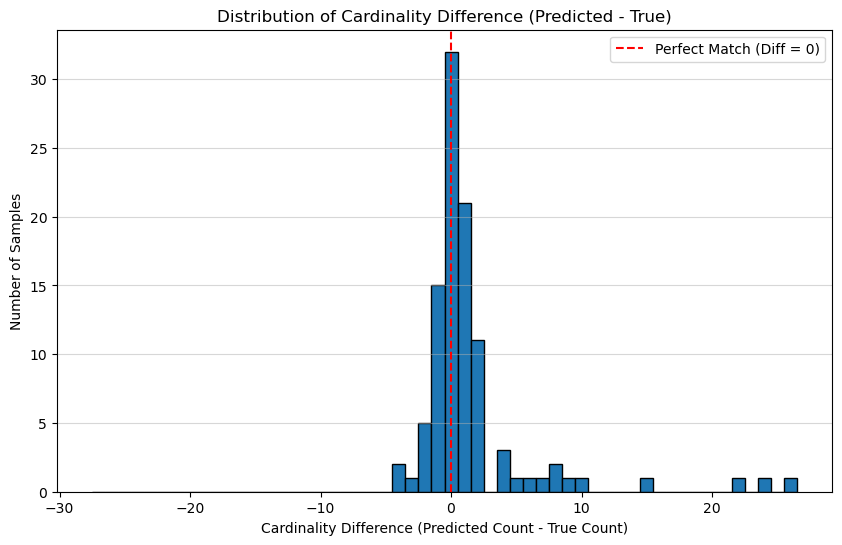

In [74]:
cardinality_true = np.sum(y_test_transformed, axis=1)
cardinality_pred = np.sum(y_pred_test_ovr, axis=1)
cardinality_difference = cardinality_pred - cardinality_true

max_abs_diff = np.abs(cardinality_difference).max()
bins = np.arange(-max_abs_diff, max_abs_diff + 1, 1)

plt.figure(figsize=(10, 6))
plt.hist(
    cardinality_difference,
    bins=bins,
    edgecolor='black',
    align='left',
)

plt.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Perfect Match (Diff = 0)')

plt.title('Distribution of Cardinality Difference (Predicted - True)')
plt.xlabel('Cardinality Difference (Predicted Count - True Count)')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


We had a decent number of predictions that were correct or at least close to the correct number of labels but we err on the side of predicting too many labels, as we suspected. We could adjust the positive threshold a little higher to be more in line with true cardinality, but of course cardinality measures do not reflect correct labels, just the correct number of labels.

We next will look at the distribution of cardinality for true and predicted labels.

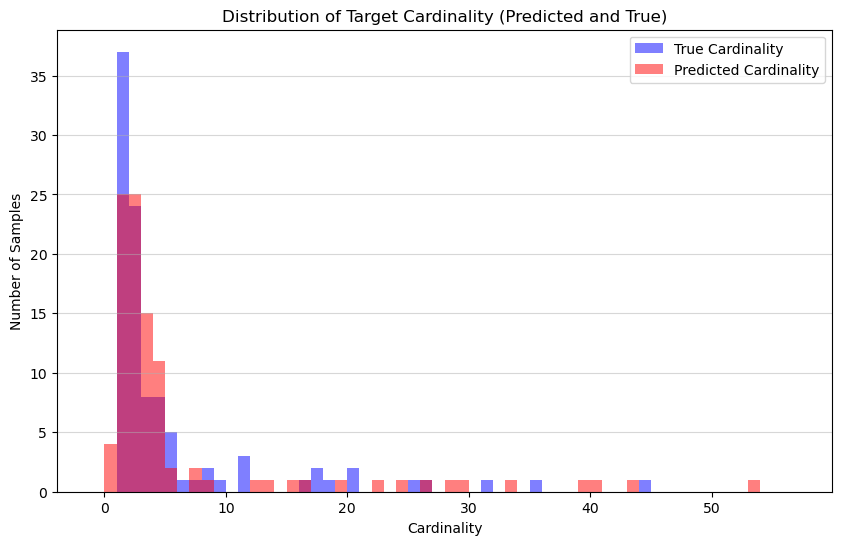

In [75]:
plt.figure(figsize=(10, 6))
bins = np.arange(
    -1,
    max(cardinality_true.max(), cardinality_pred.max()),
    1)

plt.hist(
    cardinality_true,
    bins=bins,
    alpha=0.5,
    color='blue',
    label='True Cardinality',
)
plt.hist(
    cardinality_pred,
    bins=bins,
    alpha=0.5,
    color='red',
    label='Predicted Cardinality'
)
plt.title('Distribution of Target Cardinality (Predicted and True)')
plt.xlabel('Cardinality')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

It appears that we have a small amount of predictions with no predicted AR topics. We also have a few that definitely exceed the highest actual number of AR topics.

Next we will create heatmaps for incorrect and correct predictions, by label and type.

In [76]:
cm_array = multilabel_confusion_matrix(y_test_transformed, y_pred_test_ovr)

df_heatmap = pd.DataFrame({
    'True Positives': cm_array[:, 1, 1],
    'False Negatives': cm_array[:, 1, 0],
    'False Positives': cm_array[:, 0, 1],
    'True Negatives': cm_array[:, 0, 0]
})

df_heatmap.index = y_test_transformed.columns.tolist()

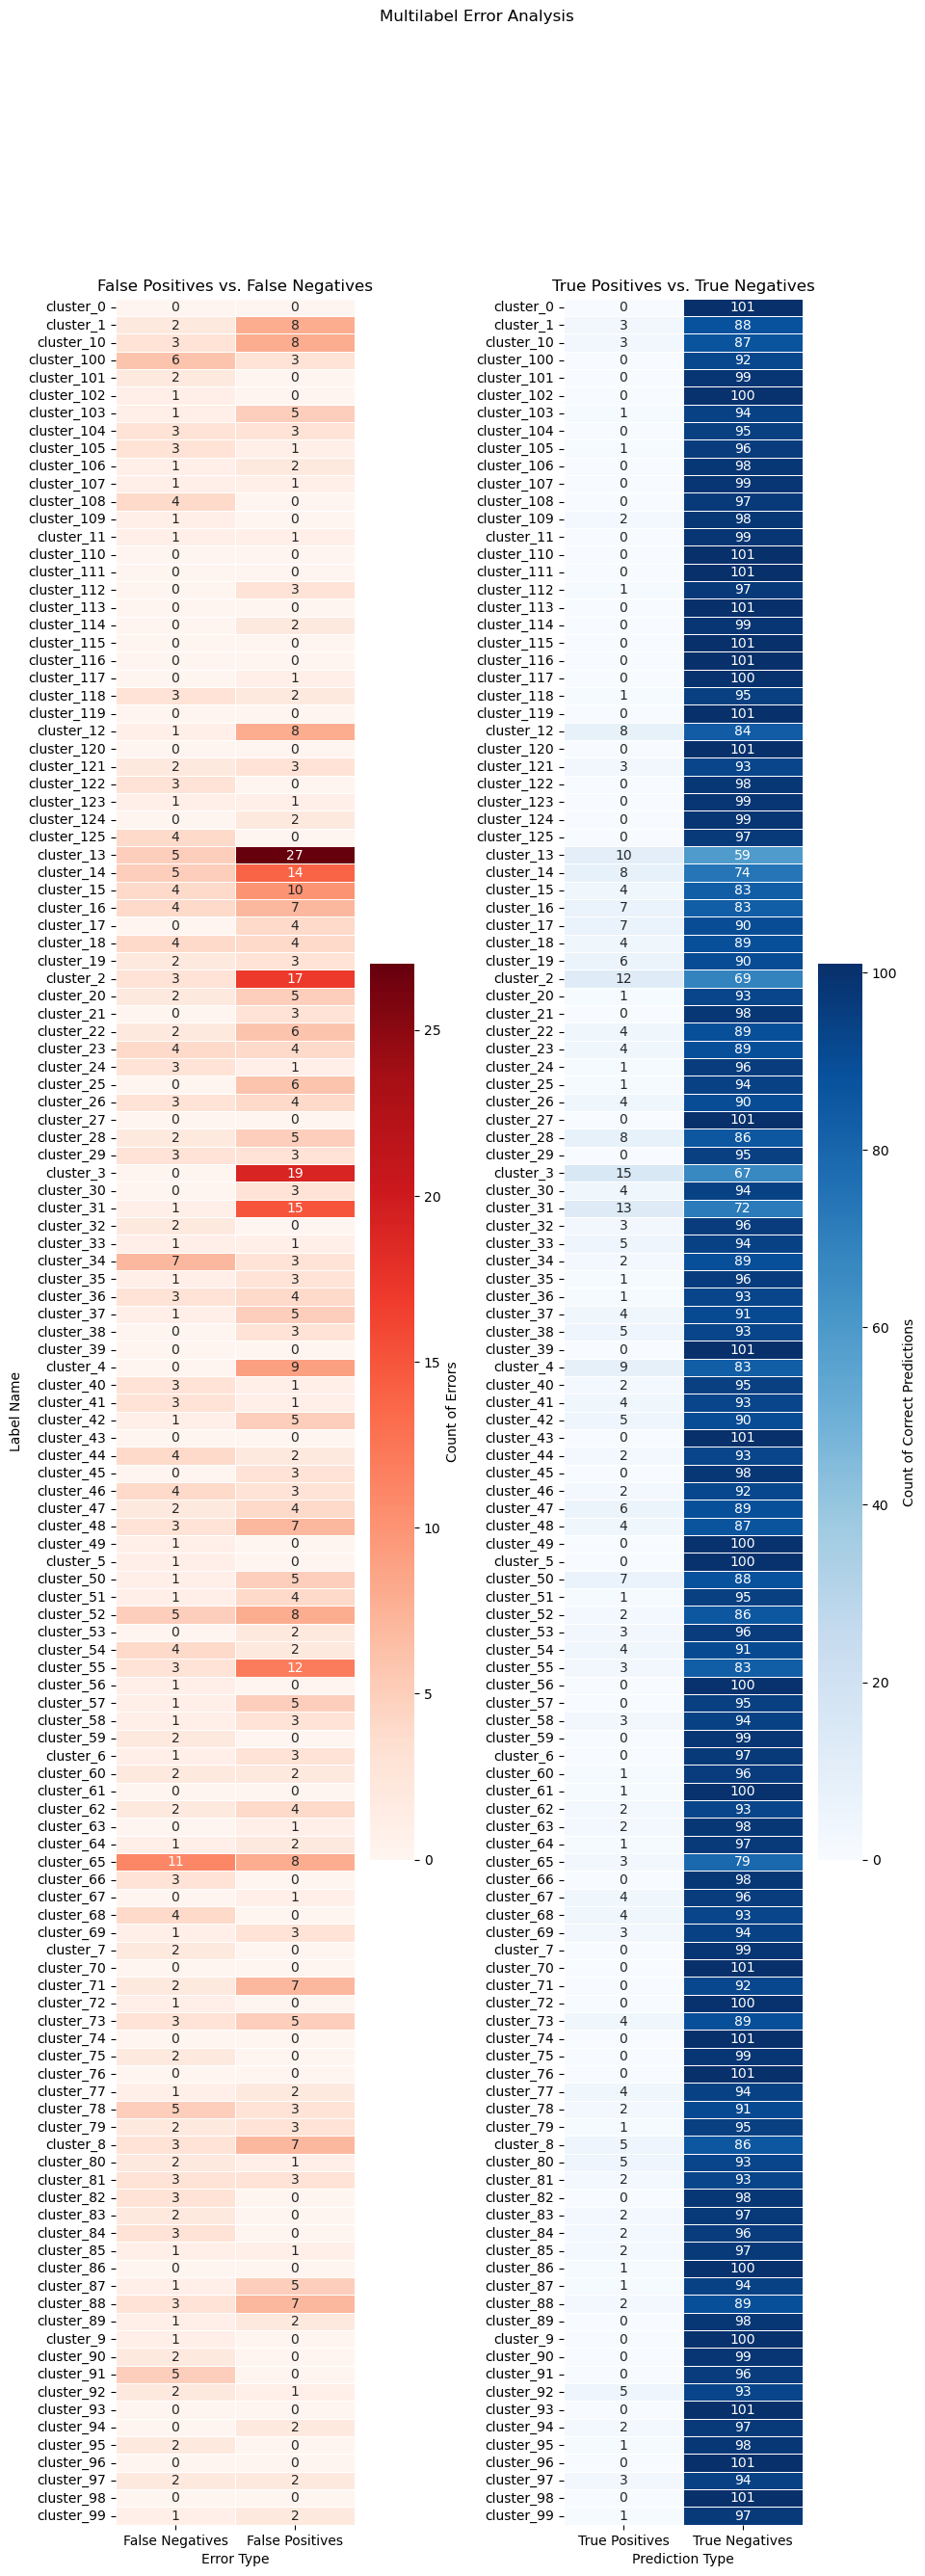

In [77]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(10, 30), 
)

ax_errors = axes[0]
df_errors = df_heatmap[['False Negatives', 'False Positives']]

sns.heatmap(
    df_errors,
    annot = True,
    fmt = 'd',
    cmap = 'Reds',
    linewidths = .5,
    cbar_kws = {'label': 'Count of Errors'},
    ax = ax_errors,
)

ax_errors.set_title('False Positives vs. False Negatives')
ax_errors.set_ylabel('Label Name')
ax_errors.set_xlabel('Error Type')
current_labels = ax_errors.get_yticklabels()
ax_errors.set_yticklabels(
    current_labels,
    rotation=0,
)

ax_correct = axes[1]
df_correct = df_heatmap[['True Positives', 'True Negatives']]

sns.heatmap(
    df_correct,
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    linewidths = .5,
    cbar_kws = {'label': 'Count of Correct Predictions'},
    ax = ax_correct
)

ax_correct.set_title('True Positives vs. True Negatives')
ax_correct.set_xlabel('Prediction Type')
ax_correct.set_yticklabels(
    current_labels,
    rotation=0,
)

fig.suptitle('Multilabel Error Analysis')
plt.subplots_adjust(wspace=0.5)
plt.show()

Our model did well but does display the same high false positive balance that we also saw with our model that predicted ESFs. This time, we have a fair amount of false negatives that are also a concern given how rare some of the AR topics can be.

We will perform a label co-occurence analysis to determine label correlation differences between the test set and our predictions.

In [78]:
# Generate a matrix of label combination counts for the test set
labels = y_test_transformed.columns.tolist()
label_len = len(labels)
true_corr = np.dot(y_test_transformed.T, y_test_transformed)
co_occurrence_df = pd.DataFrame(
    true_corr,
    index=labels,
    columns=labels,
)
co_occurrence_df

cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  \
cluster_0            0          0           0            0            0   
cluster_1            0          5           1            0            0   
cluster_10           0          1           6            1            1   
cluster_100          0          0           1            6            0   
cluster_101          0          0           1            0            2   
cluster_102          0          0           0            0            0   
cluster_103          0          1           0            0            0   
cluster_104          0          2           1            0            0   
cluster_105          0          0           0            0            0   
cluster_106          0          0           0            0            0   
cluster_107          0          0           0            0            0   
cluster_108          0          0           0            0            0   
cluster_109          0          1           2            1            0   
cluster_11           0          0           0            0            0   
cluster_110          0          0           0            0            0   
cluster_111          0          0           0            0            0   
cluster_112          0          1           0            0            0   
cluster_113          0          0           0            0            0   
cluster_114          0          0           0            0            0   
cluster_115          0          0           0            0            0   
cluster_116          0          0           0            0            0   
cluster_117          0          0           0            0            0   
cluster_118          0          0           1            1            0   
cluster_119          0          0           0            0            0   
cluster_12           0          2           2            1            0   
cluster_120          0          0           0            0            0   
cluster_121          0          0           0            0            0   
cluster_122          0          1           2            1            0   
cluster_123          0          0           0            0            0   
cluster_124          0          0           0            0            0   
cluster_125          0          0           0            0            0   
cluster_13           0          2           1            0            0   
cluster_14           0          0           0            0            0   
cluster_15           0          1           1            0            2   
cluster_16           0          1           2            1            0   
cluster_17           0          2           1            0            0   
cluster_18           0          1           3            1            0   
cluster_19           0          2           3            1            0   
cluster_2            0          4           4            1            1   
cluster_20           0          0           0            0            0   
cluster_21           0          0           0            0            0   
cluster_22           0          1           0            0            0   
cluster_23           0          1           0            0            0   
cluster_24           0          0           0            0            0   
cluster_25           0          0           0            0            0   
cluster_26           0          2           2            0            2   
cluster_27           0          0           0            0            0   
cluster_28           0          1           1            0            2   
cluster_29           0          0           0            0            1   
cluster_3            0          1           3            2            1   
cluster_30           0          1           0            0            0   
cluster_31           0          1           0            1            0   
cluster_32           0          0     

In [79]:
# Get a normalized version of the co-occurrence counts
label_counts = np.diag(co_occurrence_df)
normalized_co_occurrence_df = co_occurrence_df.div(
    label_counts,
    axis=0,
    )
normalized_co_occurrence_df


cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  \
cluster_0          NaN        NaN         NaN          NaN          NaN   
cluster_1          0.0   1.000000    0.200000     0.000000     0.000000   
cluster_10         0.0   0.166667    1.000000     0.166667     0.166667   
cluster_100        0.0   0.000000    0.166667     1.000000     0.000000   
cluster_101        0.0   0.000000    0.500000     0.000000     1.000000   
cluster_102        0.0   0.000000    0.000000     0.000000     0.000000   
cluster_103        0.0   0.500000    0.000000     0.000000     0.000000   
cluster_104        0.0   0.666667    0.333333     0.000000     0.000000   
cluster_105        0.0   0.000000    0.000000     0.000000     0.000000   
cluster_106        0.0   0.000000    0.000000     0.000000     0.000000   
cluster_107        0.0   0.000000    0.000000     0.000000     0.000000   
cluster_108        0.0   0.000000    0.000000     0.000000     0.000000   
cluster_109        0.0   0.333333    0.666667     0.333333     0.000000   
cluster_11         0.0   0.000000    0.000000     0.000000     0.000000   
cluster_110        NaN        NaN         NaN          NaN          NaN   
cluster_111        NaN        NaN         NaN          NaN          NaN   
cluster_112        0.0   1.000000    0.000000     0.000000     0.000000   
cluster_113        NaN        NaN         NaN          NaN          NaN   
cluster_114        NaN        NaN         NaN          NaN          NaN   
cluster_115        NaN        NaN         NaN          NaN          NaN   
cluster_116        NaN        NaN         NaN          NaN          NaN   
cluster_117        NaN        NaN         NaN          NaN          NaN   
cluster_118        0.0   0.000000    0.250000     0.250000     0.000000   
cluster_119        NaN        NaN         NaN          NaN          NaN   
cluster_12         0.0   0.222222    0.222222     0.111111     0.000000   
cluster_120        NaN        NaN         NaN          NaN          NaN   
cluster_121        0.0   0.000000    0.000000     0.000000     0.000000   
cluster_122        0.0   0.333333    0.666667     0.333333     0.000000   
cluster_123        0.0   0.000000    0.000000     0.000000     0.000000   
cluster_124        NaN        NaN         NaN          NaN          NaN   
cluster_125        0.0   0.000000    0.000000     0.000000     0.000000   
cluster_13         0.0   0.133333    0.066667     0.000000     0.000000   
cluster_14         0.0   0.000000    0.000000     0.000000     0.000000   
cluster_15         0.0   0.125000    0.125000     0.000000     0.250000   
cluster_16         0.0   0.090909    0.181818     0.090909     0.000000   
cluster_17         0.0   0.285714    0.142857     0.000000     0.000000   
cluster_18         0.0   0.125000    0.375000     0.125000     0.000000   
cluster_19         0.0   0.250000    0.375000     0.125000     0.000000   
cluster_2          0.0   0.266667    0.266667     0.066667     0.066667   
cluster_20         0.0   0.000000    0.000000     0.000000     0.000000   
cluster_21         NaN        NaN         NaN          NaN          NaN   
cluster_22         0.0   0.166667    0.000000     0.000000     0.000000   
cluster_23         0.0   0.125000    0.000000     0.000000     0.000000   
cluster_24         0.0   0.000000    0.000000     0.000000     0.000000   
cluster_25         0.0   0.000000    0.000000     0.000000     0.000000   
cluster_26         0.0   0.285714    0.285714     0.000000     0.285714   
cluster_27         NaN        NaN         NaN          NaN          NaN   
cluster_28         0.0   0.100000    0.100000     0.000000     0.200000   
cluster_29         0.0   0.000000    0.000000     0.000000     0.333333   
cluster_3          0.0   0.066667    0.200000     0.133333     0.066667   
cluster_30         0.0   0.250000    0.000000     0.000000     0.000000   
cluster_31         0.0   0.071429    0.000000     0.071429     0.000000   
cluster_32         0.0   0.000000    0

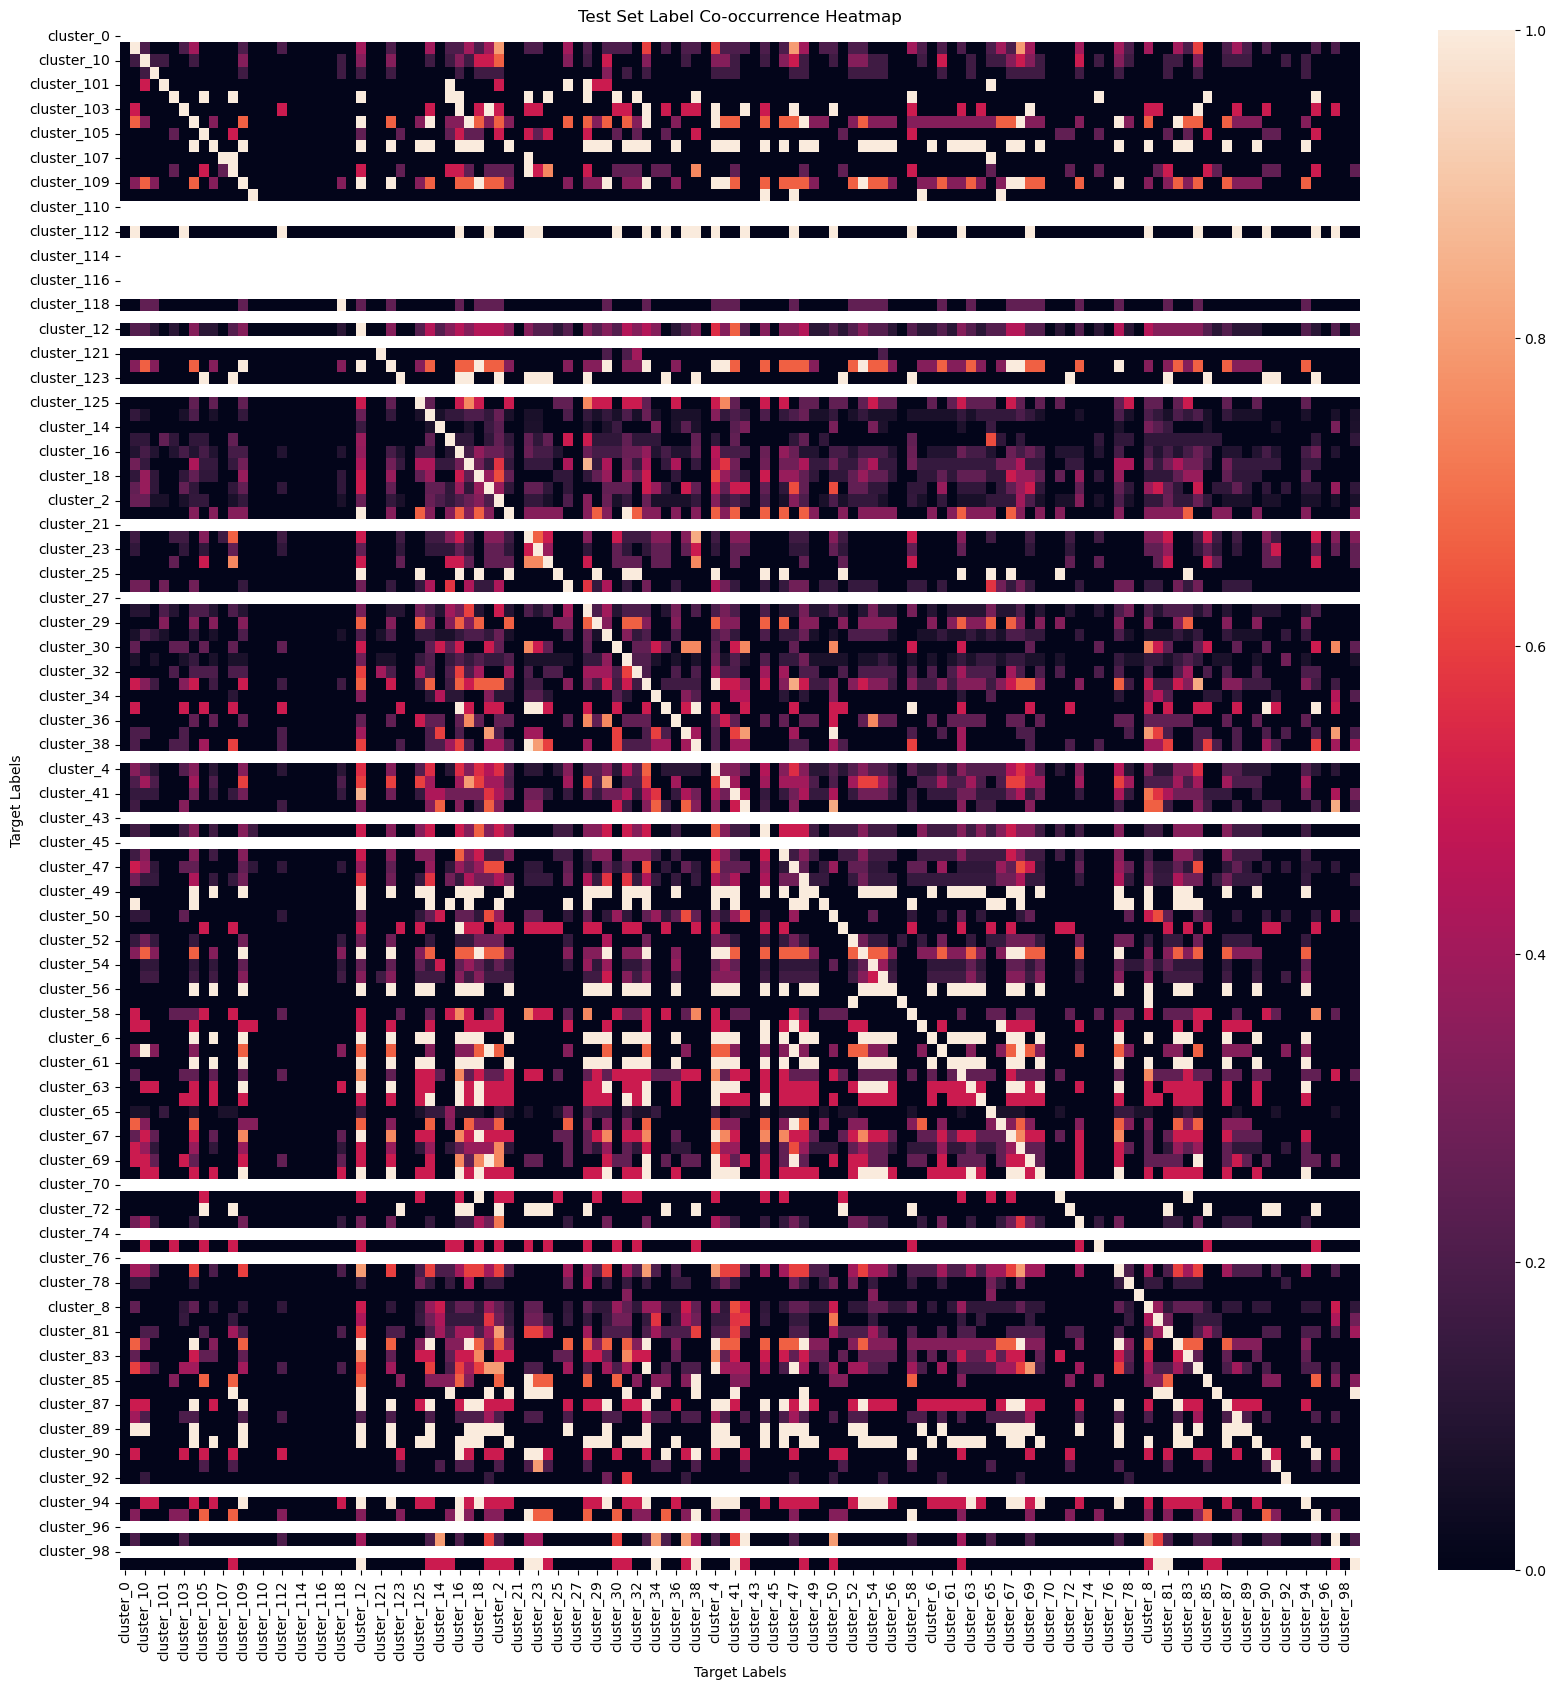

In [80]:
plt.figure(figsize=(20,20))
sns.heatmap(
    normalized_co_occurrence_df,
    annot=False,
    )
plt.title('Test Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

In [81]:
# Generate a matrix of label combination counts for the prediction set
pred_corr = np.dot(y_pred_test_ovr.T, y_pred_test_ovr)
pred_co_occurrence_df = pd.DataFrame(
    pred_corr,
    index=labels,
    columns=labels,
)

pred_co_occurrence_df


cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  \
cluster_0            0          0           0            0            0   
cluster_1            0         11           7            1            0   
cluster_10           0          7          11            1            0   
cluster_100          0          1           1            3            0   
cluster_101          0          0           0            0            0   
cluster_102          0          0           0            0            0   
cluster_103          0          2           4            0            0   
cluster_104          0          2           3            0            0   
cluster_105          0          2           2            0            0   
cluster_106          0          2           2            0            0   
cluster_107          0          1           0            0            0   
cluster_108          0          0           0            0            0   
cluster_109          0          2           2            0            0   
cluster_11           0          1           1            0            0   
cluster_110          0          0           0            0            0   
cluster_111          0          0           0            0            0   
cluster_112          0          4           4            0            0   
cluster_113          0          0           0            0            0   
cluster_114          0          2           2            0            0   
cluster_115          0          0           0            0            0   
cluster_116          0          0           0            0            0   
cluster_117          0          1           0            0            0   
cluster_118          0          1           1            0            0   
cluster_119          0          0           0            0            0   
cluster_12           0          7           7            1            0   
cluster_120          0          0           0            0            0   
cluster_121          0          0           0            0            0   
cluster_122          0          0           0            0            0   
cluster_123          0          0           1            0            0   
cluster_124          0          2           2            0            0   
cluster_125          0          0           0            0            0   
cluster_13           0          4           2            1            0   
cluster_14           0          3           4            0            0   
cluster_15           0          8           7            0            0   
cluster_16           0          9           8            0            0   
cluster_17           0          8           6            1            0   
cluster_18           0          7           7            1            0   
cluster_19           0          6           4            1            0   
cluster_2            0         11          11            2            0   
cluster_20           0          5           4            0            0   
cluster_21           0          3           3            0            0   
cluster_22           0          8           6            0            0   
cluster_23           0          5           5            1            0   
cluster_24           0          1           1            0            0   
cluster_25           0          6           6            0            0   
cluster_26           0          3           4            3            0   
cluster_27           0          0           0            0            0   
cluster_28           0          8           5            1            0   
cluster_29           0          3           2            0            0   
cluster_3            0          7           6            2            0   
cluster_30           0          4           6            0            0   
cluster_31           0          5           5            2            0   
cluster_32           0          3     

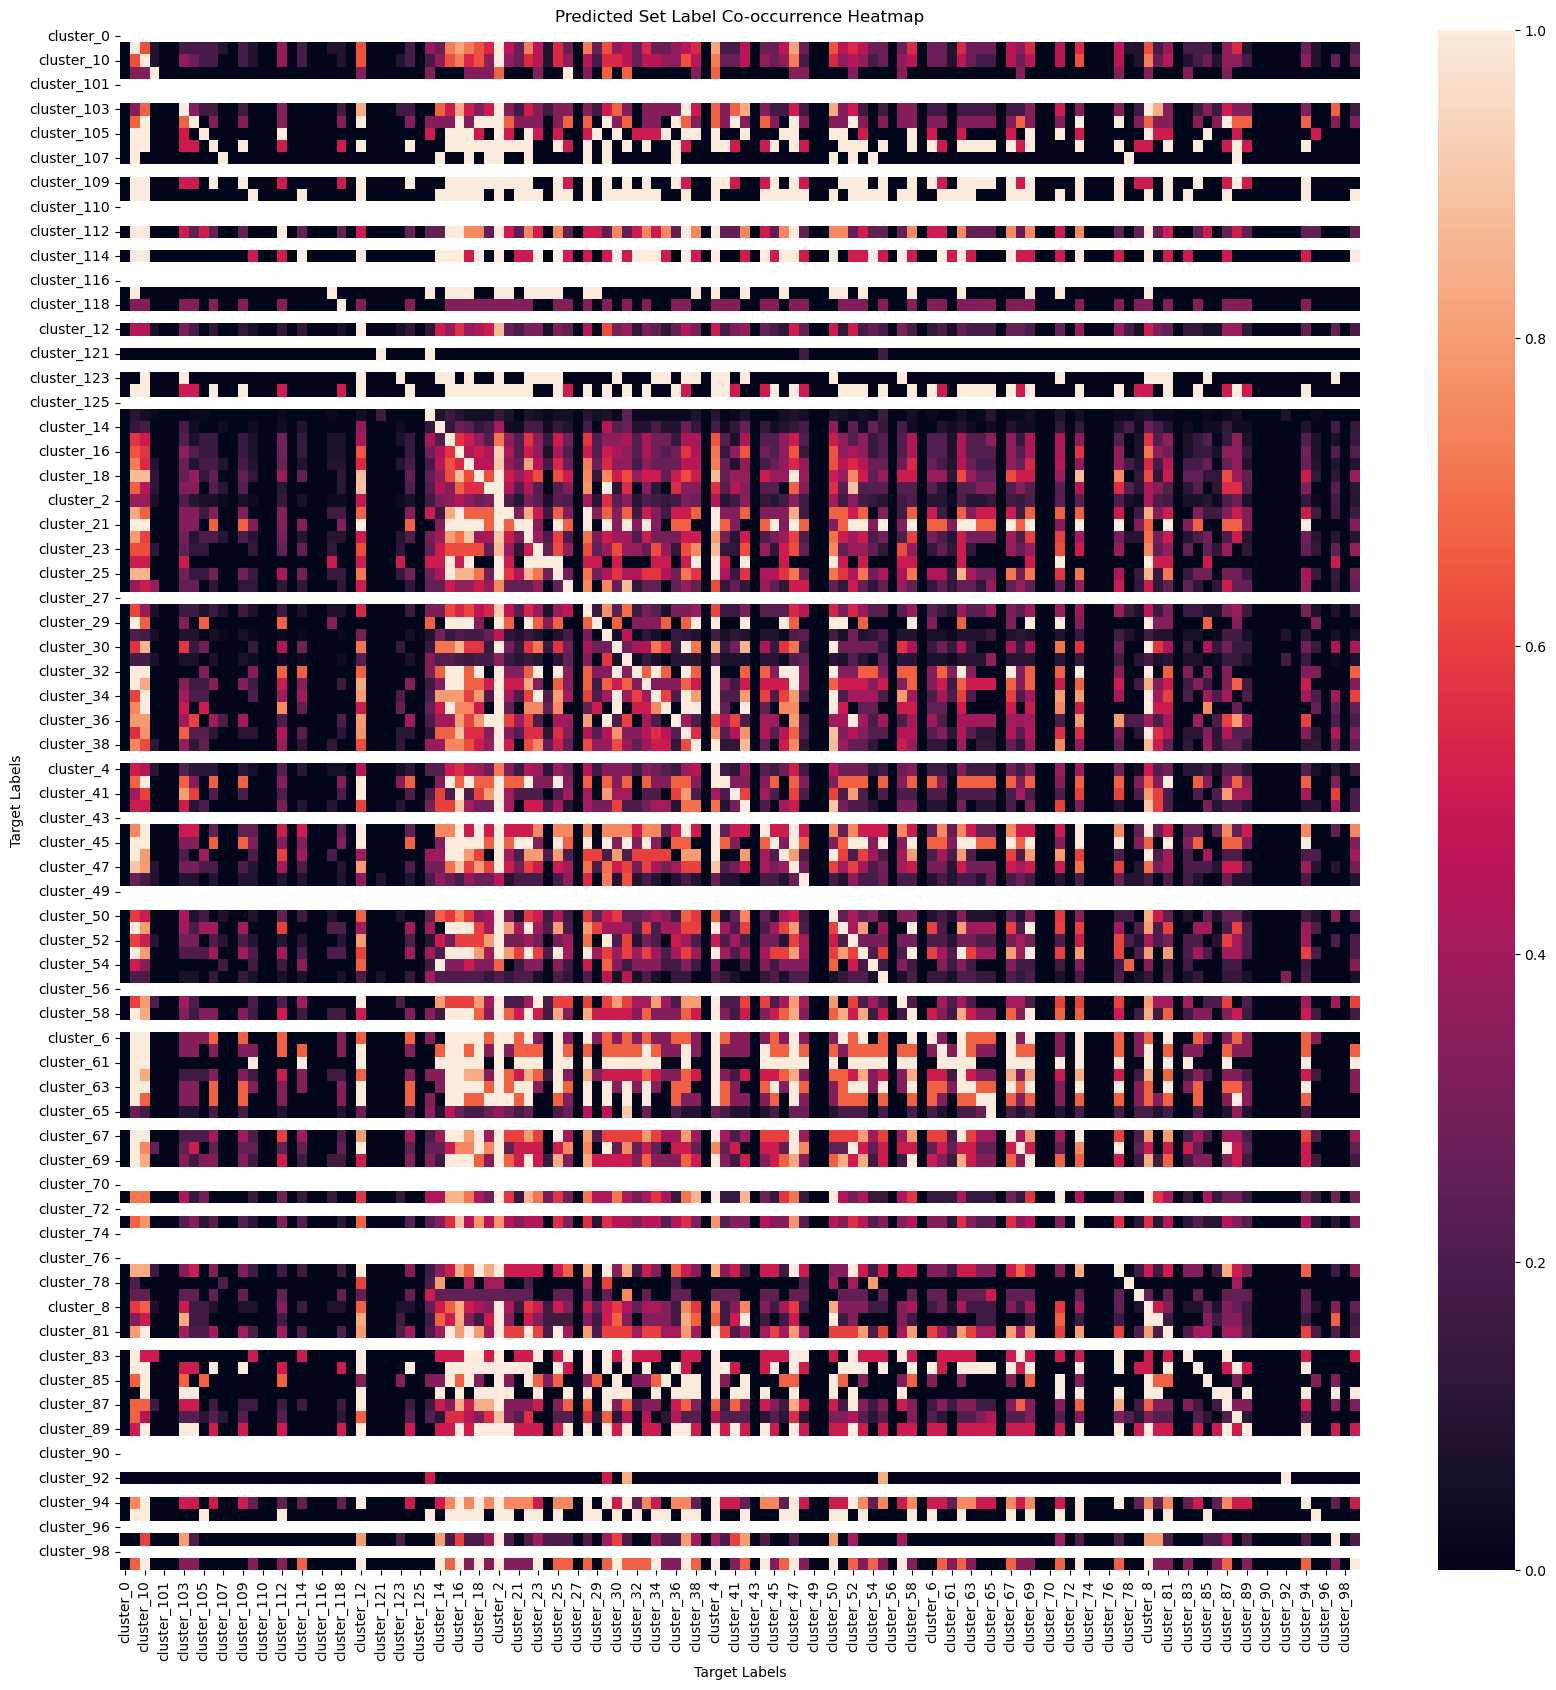

In [82]:
pred_label_counts = np.diag(pred_co_occurrence_df)
normalized_pred_co_occurrence_df = pred_co_occurrence_df.div(
    pred_label_counts,
    axis=0,
    )
plt.figure(figsize=(20,20))
sns.heatmap(
    normalized_pred_co_occurrence_df,
    annot=False,
    )
plt.title('Predicted Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

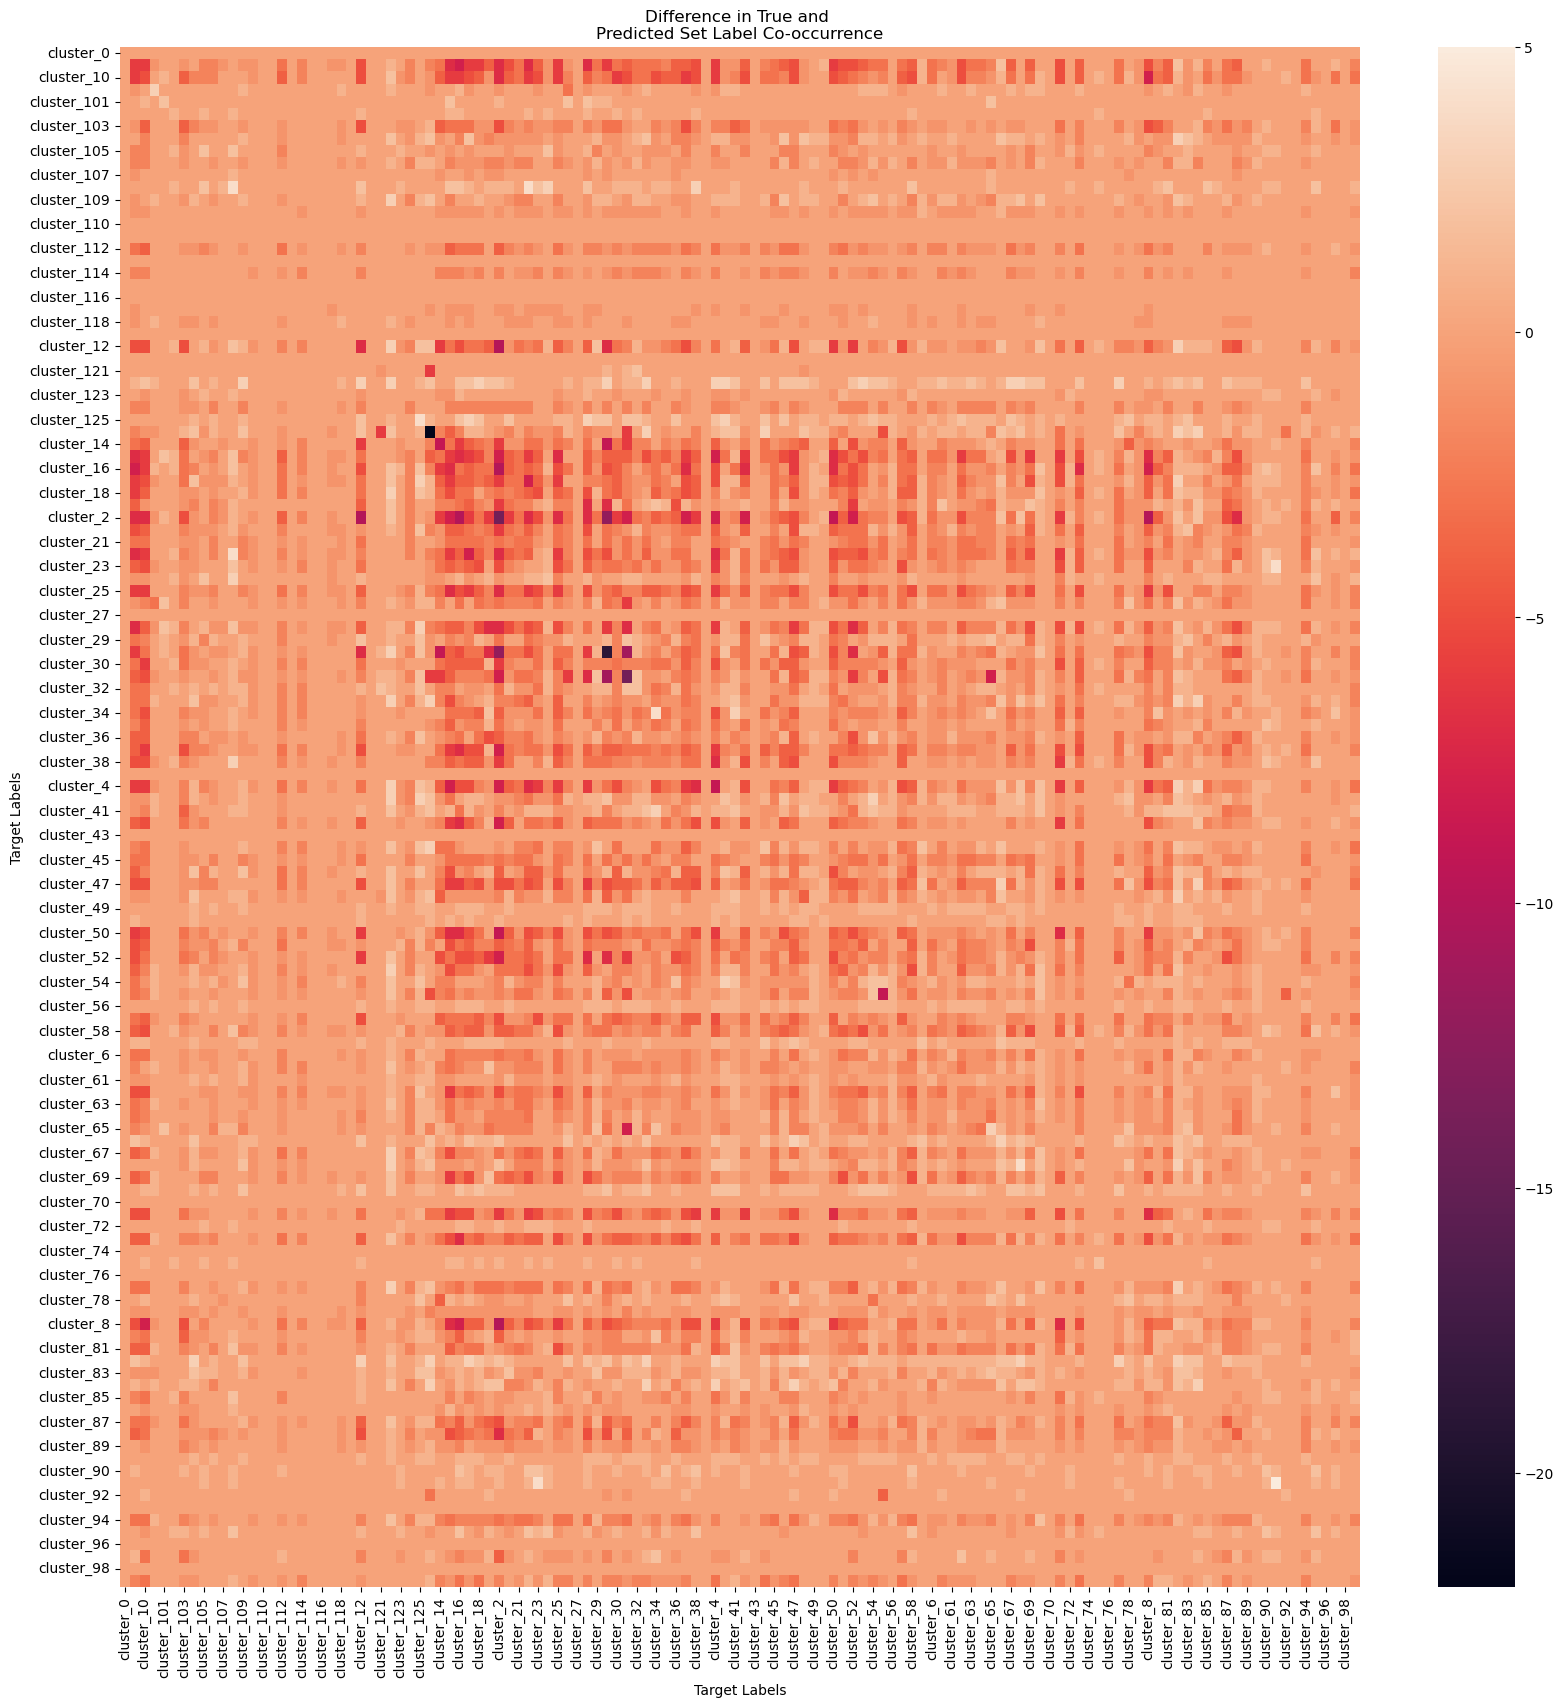

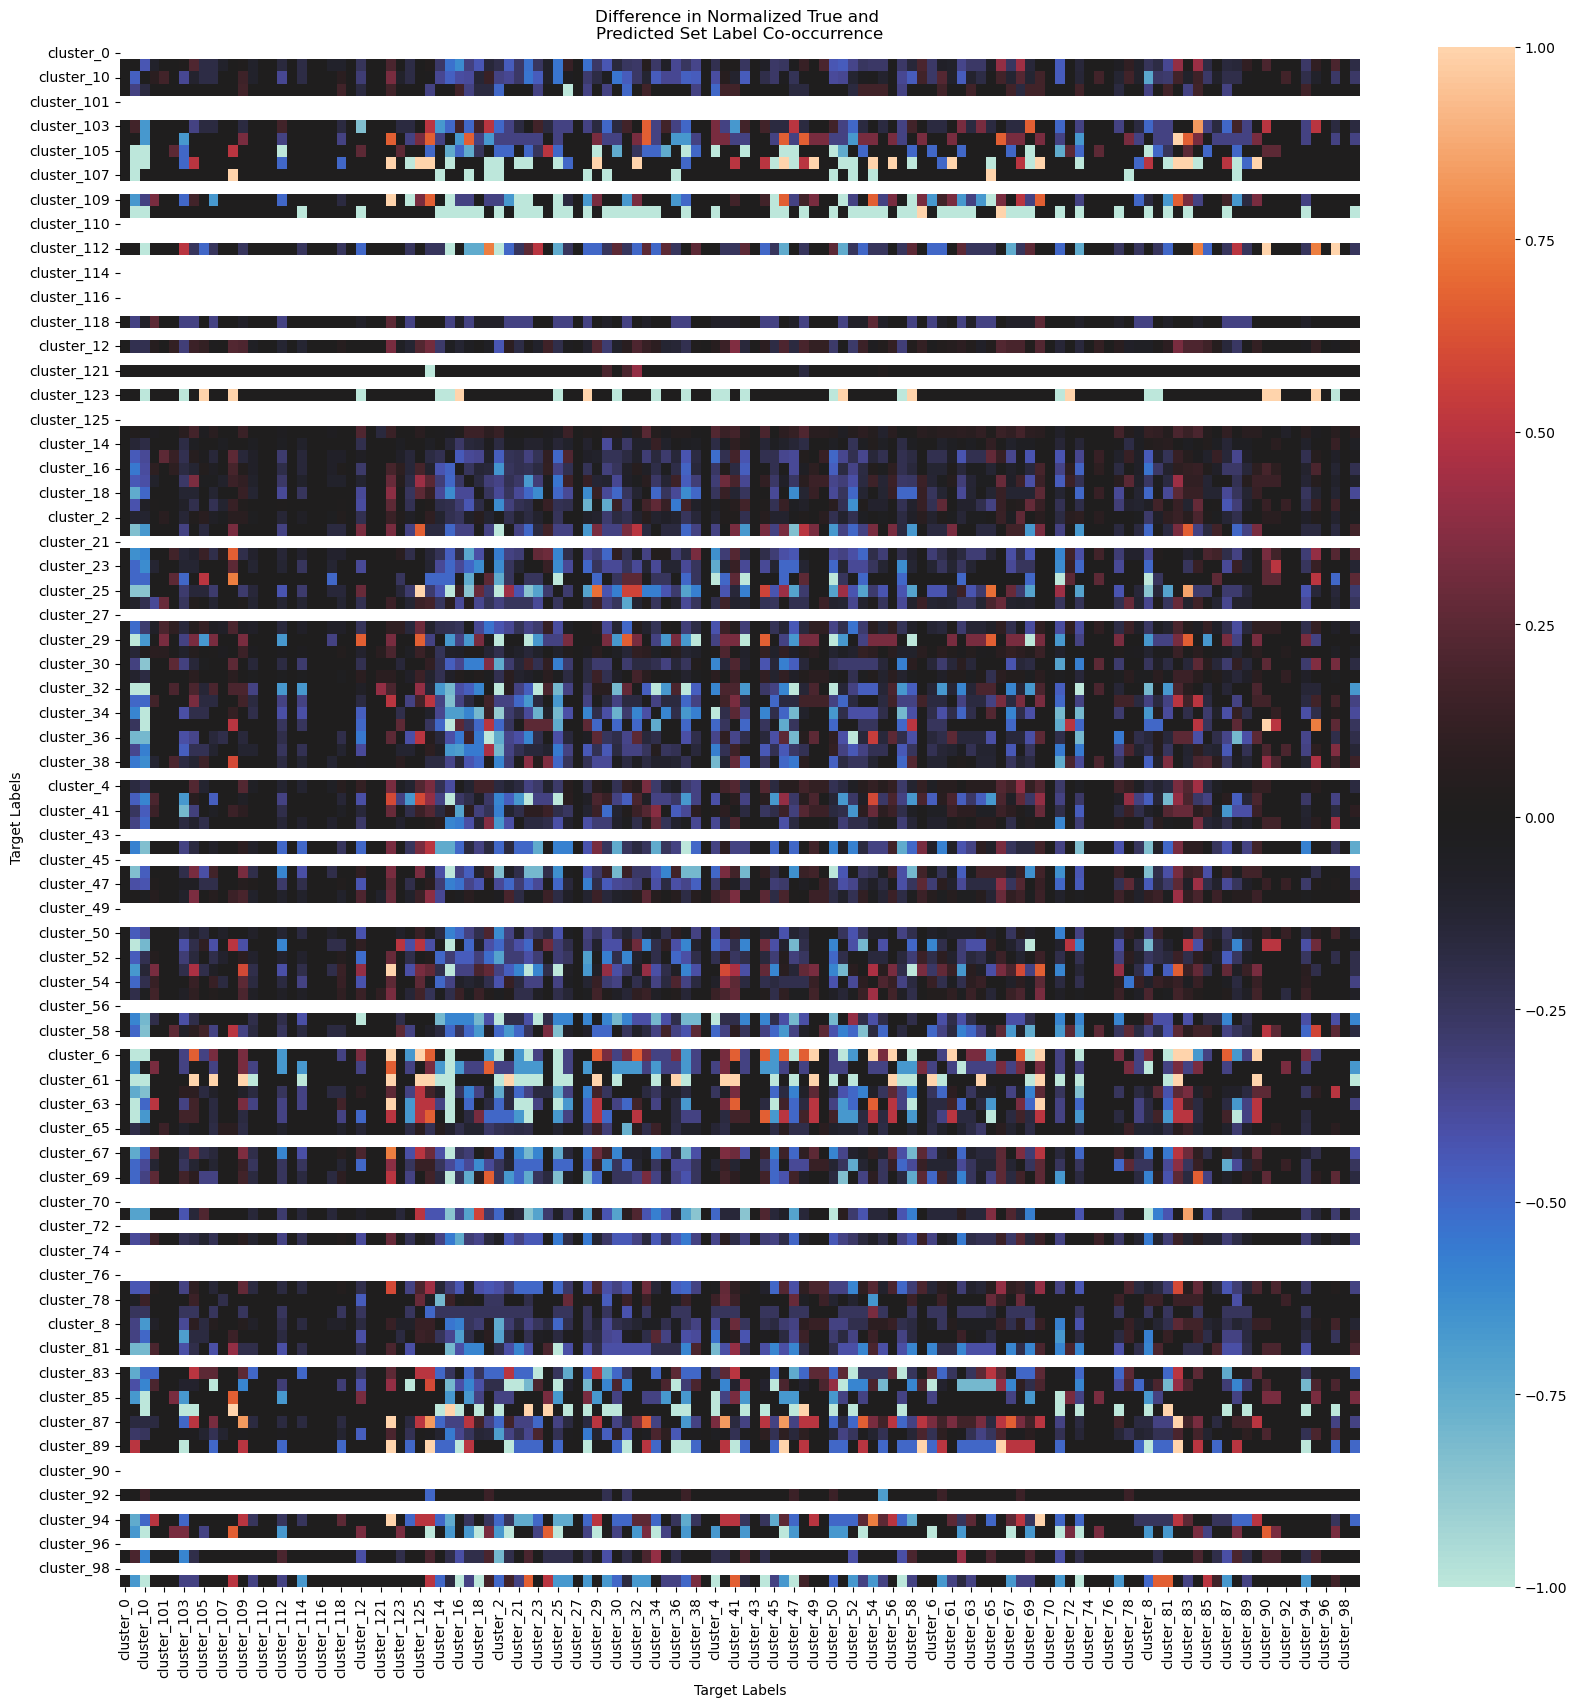

In [83]:
# Compare the differences between the test set and the prediction set

difference_df = co_occurrence_df - pred_co_occurrence_df

plt.figure(figsize=(20,20))
sns.heatmap(
    difference_df,
)
plt.title('Difference in True and \nPredicted Set Label Co-occurrence')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

norm_difference_df = normalized_co_occurrence_df - normalized_pred_co_occurrence_df

plt.figure(figsize=(20,20))
sns.heatmap(
    norm_difference_df,
    center=0
)
plt.title('Difference in Normalized True and \nPredicted Set Label Co-occurrence')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

The size of the label set makes visual analysis much harder to perform. There are certainly pockets of poor performance were our model tends to lump AR topics together that do not exist in the test set. However, catching all of these errors by eye is not ideal.

We will now create a dataframe consisting of the label combinations and the error between the test set and the prediction set. Negative values will be overpredictions and positive values will be underpredictions.

In [84]:
difference_stack = (difference_df.stack().reset_index(name='difference').query('level_0 != level_1'))
largest_errors = difference_stack.reindex(difference_stack['difference'].abs().sort_values(ascending=False).index)
largest_errors.head(30)

level_0     level_1  difference
6212    cluster_3   cluster_2         -12
4837    cluster_2   cluster_3         -12
6475   cluster_31   cluster_3         -11
6225    cluster_3  cluster_31         -11
4812    cluster_2  cluster_12         -10
3062   cluster_12   cluster_2         -10
13142   cluster_8   cluster_2         -10
4322   cluster_16   cluster_2         -10
4822    cluster_2  cluster_16         -10
4892    cluster_2   cluster_8         -10
4081   cluster_14   cluster_3          -9
4860    cluster_2  cluster_50          -9
6206    cluster_3  cluster_14          -9
9110   cluster_50   cluster_2          -9
4821    cluster_2  cluster_15          -8
4851    cluster_2  cluster_42          -8
7593    cluster_4  cluster_15          -8
4848    cluster_2   cluster_4          -8
6464   cluster_31   cluster_2          -8
4862    cluster_2  cluster_52          -8
4388   cluster_16   cluster_8          -8
160     cluster_1  cluster_16          -8
7598    cluster_4   cluster_2          -8
4845    cluster_2  cluster_37          -8
6514   cluster_31  cluster_65          -8
356    cluster_10   cluster_8          -8
4839    cluster_2  cluster_31          -8
13106   cluster_8  cluster_10          -8
9362   cluster_52   cluster_2          -8
7220   cluster_37   cluster_2          -8

In [85]:
largest_errors.tail(30)

level_0      level_1  difference
6413   cluster_30   cluster_88           0
6415   cluster_30    cluster_9           0
6417   cluster_30   cluster_91           0
6418   cluster_30   cluster_92           0
6419   cluster_30   cluster_93           0
6422   cluster_30   cluster_96           0
6423   cluster_30   cluster_97           0
6424   cluster_30   cluster_98           0
6387   cluster_30   cluster_64           0
6381   cluster_30   cluster_59           0
6378   cluster_30   cluster_56           0
6371   cluster_30    cluster_5           0
6319   cluster_30  cluster_115           0
6320   cluster_30  cluster_116           0
6321   cluster_30  cluster_117           0
6322   cluster_30  cluster_118           0
6323   cluster_30  cluster_119           0
6325   cluster_30  cluster_120           0
6326   cluster_30  cluster_121           0
6327   cluster_30  cluster_122           0
6329   cluster_30  cluster_124           0
6330   cluster_30  cluster_125           0
6331   cluster_30   cluster_13           0
6343   cluster_30   cluster_24           0
6346   cluster_30   cluster_27           0
6359   cluster_30   cluster_39           0
6362   cluster_30   cluster_41           0
6364   cluster_30   cluster_43           0
6370   cluster_30   cluster_49           0
15874  cluster_99   cluster_98           0

Many of our worst performances were on common events, such as when AR topics 2 or 16 are present. Not surprisingly, the models best performance was on rare events, so it was often correct about not creating false positives for topics that did not appear together. It seems that the model focuses on a handful of topics and wants to included them far too often.

Let's compare it to the differences in the normalized sets.

In [86]:
normalized_difference_stack = (normalized_co_occurrence_df.stack().reset_index(name='difference').query('level_0 != level_1'))
normalized_largest_errors = normalized_difference_stack.reindex(normalized_difference_stack['difference'].abs().sort_values(ascending=False).index)
normalized_largest_errors.head(30)

level_0      level_1  difference
4084    cluster_25   cluster_32         1.0
11825   cluster_87   cluster_82         1.0
12662   cluster_94   cluster_41         1.0
12661   cluster_94   cluster_40         1.0
12660   cluster_94    cluster_4         1.0
1723   cluster_112   cluster_62         1.0
1718   cluster_112   cluster_58         1.0
614    cluster_102   cluster_85         1.0
1710   cluster_112   cluster_50         1.0
12653   cluster_94   cluster_33         1.0
1706   cluster_112   cluster_47         1.0
1701   cluster_112   cluster_42         1.0
12649   cluster_94    cluster_3         1.0
1698   cluster_112    cluster_4         1.0
1696   cluster_112   cluster_38         1.0
1695   cluster_112   cluster_37         1.0
625    cluster_102   cluster_95         1.0
1693   cluster_112   cluster_35         1.0
1691   cluster_112   cluster_33         1.0
1688   cluster_112   cluster_30         1.0
1680   cluster_112   cluster_23         1.0
1679   cluster_112   cluster_22         1.0
1675   cluster_112   cluster_19         1.0
1672   cluster_112   cluster_16         1.0
1644   cluster_112  cluster_103         1.0
1730   cluster_112   cluster_69         1.0
603    cluster_102   cluster_75         1.0
11767   cluster_87    cluster_3         1.0
11819   cluster_87   cluster_77         1.0
12693   cluster_94    cluster_7         1.0

In [87]:
normalized_largest_errors.tail(30)

level_0      level_1  difference
5354   cluster_35   cluster_41         0.0
5356   cluster_35   cluster_43         0.0
5357   cluster_35   cluster_44         0.0
5358   cluster_35   cluster_45         0.0
5359   cluster_35   cluster_46         0.0
5361   cluster_35   cluster_48         0.0
5362   cluster_35   cluster_49         0.0
5363   cluster_35    cluster_5         0.0
5366   cluster_35   cluster_52         0.0
5367   cluster_35   cluster_53         0.0
5343   cluster_35   cluster_31         0.0
5340   cluster_35   cluster_29         0.0
5314   cluster_35  cluster_118         0.0
5338   cluster_35   cluster_27         0.0
5315   cluster_35  cluster_119         0.0
5316   cluster_35   cluster_12         0.0
5317   cluster_35  cluster_120         0.0
5318   cluster_35  cluster_121         0.0
5319   cluster_35  cluster_122         0.0
5321   cluster_35  cluster_124         0.0
5322   cluster_35  cluster_125         0.0
5323   cluster_35   cluster_13         0.0
5324   cluster_35   cluster_14         0.0
5325   cluster_35   cluster_15         0.0
5328   cluster_35   cluster_18         0.0
5331   cluster_35   cluster_20         0.0
5332   cluster_35   cluster_21         0.0
5336   cluster_35   cluster_25         0.0
5337   cluster_35   cluster_26         0.0
13102  cluster_99   cluster_98         0.0

There are plenty of label co-occurrences that we are getting completely incorrect. Due to the volume of combinations that we did get incorrect, it would serve us better to focus on reviewing incidents at the individual instance level to learn more.

Next, we will get an idea of feature importance through feature permutation. Again, due to the OneHotEncoding / LabelBinarizer process we took we will be performing this at the grouped feature level.

In [88]:

groups = {
    'state': state_columns,
    'region': region_columns,
    'declarationType': declaration_columns,
    'designatedIncidentTypes': type_columns,
    'ESFs': esf_columns,
}

def grouped_feature_permutation(
    model,
    X,
    y,
    groups,
    metric_,
):
    baseline = combined_score(y_true=y, y_pred=model.predict(X = X))
    group_importance = {}
    group_importance['baseline'] = baseline
    for group, columns in groups.items():
        score_changes = []
        rng = np.random.default_rng(seed = random_state)
        for i in range(1,11):
            X_perm = X.copy()
            shuffled_ind = rng.permutation(X.index)
            X_perm[columns] = X_perm[columns].values[shuffled_ind]
            perm_score = combined_score(y_true= y, y_pred=model.predict(X_perm),)
            score_changes.append(perm_score)
        group_importance[group] = (f'Mean: {np.mean(score_changes)}', #Mean
                                   f'Max: {np.max(score_changes)}', #Max
                                   f'Min: {np.min(score_changes)}', #Min
                                   f'Std: {np.std(score_changes)}') #Std
    labels = []
    means = []
    errors = []

    for key, value in group_importance.items():
        if key == "baseline":
            y_line = (value)
        else:
            mean_val = float(value[0].split(":")[1])
            std_val = float(value[3].split(":")[1])
            labels.append(key)
            means.append(mean_val)
            errors.append(std_val)
    # Create a plot of values
    plt.figure(figsize=(10,6))
    plt.bar(labels,
            means,
            yerr=errors)
    plt.axhline(y=y_line,
                color='k',
                linestyle='--',
                label='Baseline',
                )
    plt.ylim([0, 1.5])
    plt.ylabel('Combined Metric Score')
    plt.title('Performance Given Permuted Values of Feature Groups')
    plt.tight_layout()
    plt.show()

    return group_importance

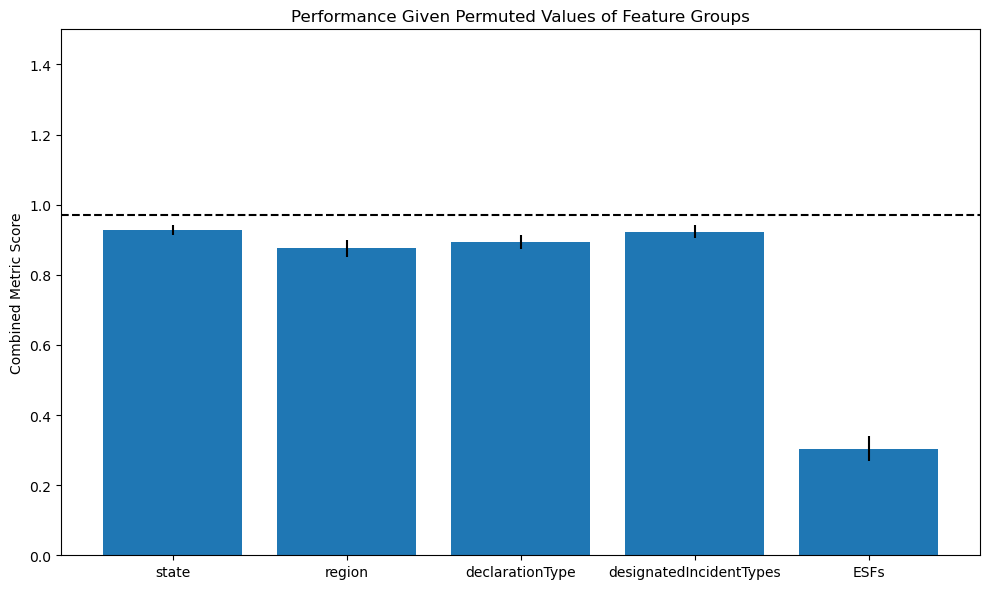

{'baseline': 0.9704738232736332,
 'state': ('Mean: 0.9270892089133808',
  'Max: 0.9558286847602554',
  'Min: 0.9069492070303837',
  'Std: 0.013738999916420795'),
 'region': ('Mean: 0.8751678407057188',
  'Max: 0.9321293778988524',
  'Min: 0.8465726658037347',
  'Std: 0.024005561611142284'),
 'declarationType': ('Mean: 0.8924831016139105',
  'Max: 0.9284266476182876',
  'Min: 0.8552015715030754',
  'Std: 0.019930298855675085'),
 'designatedIncidentTypes': ('Mean: 0.9230793598636426',
  'Max: 0.9476417366310004',
  'Min: 0.8830881332860786',
  'Std: 0.019369402457303266'),
 'ESFs': ('Mean: 0.3043563642484758',
  'Max: 0.37227825271390436',
  'Min: 0.26100712696910805',
  'Std: 0.03480546567727644')}

In [89]:
perm_scores = grouped_feature_permutation(study_ovrxgb_tuned,
                                          X_test_transformed,
                                          y_test_transformed,
                                          groups,
                                          F1_Macro_Avg)

perm_scores

No instances of the score improving through permutation, which is good. Shuffling the ESF values has the biggest negative impact on the final metric score compared to the baseline, so getting those right is key.

Let us start analyzing edge cases. We can begin by picking a few rows from the same incident and comparing outcomes for different states.

In [90]:
X_test['incidentId'].value_counts()

incidentId
2012102505    13
2021082601     8
2020091301     6
2023081703     3
2021081902     3
2018031201     2
2024042701     2
2024052402     2
2024080901     2
2023030901     2
2022122101     2
2021081801     2
2020041101     2
2020010701     2
2016100501     1
2023081101     1
2014061802     1
2021080901     1
2021062401     1
2014020501     1
2022081903     1
2022070501     1
2022051202     1
2022062801     1
2023030102     1
2013060301     1
2013051001     1
2016061101     1
2023081801     1
2023082901     1
2023090401     1
2024080603     1
2013050601     1
2013062801     1
2024082001     1
2024042902     1
2024042901     1
2013070101     1
2014071703     1
2022010701     1
2015021101     1
2022010301     1
2016081301     1
2016092301     1
2017012001     1
2017021001     1
2017031101     1
2017052601     1
2017072901     1
2017110601     1
2017110602     1
2018082801     1
2018041602     1
2016100502     1
2018022302     1
2019101801     1
2019110101     1
2019110801     1
201

In [91]:
X_test[X_test['incidentId']==2012102505]

incidentId state designatedIncidentTypes declarationType  region  \
0   2012102505    CT             [Hurricane]              DR       1   
1   2012102505    DC             [Hurricane]              EM       3   
2   2012102505    DE             [Hurricane]              DR       3   
3   2012102505    DE             [Hurricane]              EM       3   
4   2012102505    MD             [Hurricane]              DR       3   
5   2012102505    MD             [Hurricane]              EM       3   
6   2012102505    NJ             [Hurricane]              DR       2   
7   2012102505    NY             [Hurricane]              DR       2   
8   2012102505    PA             [Hurricane]              EM       3   
9   2012102505    RI             [Hurricane]              DR       1   
10  2012102505    VA             [Hurricane]              DR       3   
11  2012102505    WV             [Hurricane]              DR       3   
12  2012102505    WV             [Hurricane]              EM       3   

                                                  ESF    year  
0   [1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 12.0, 15.0]  2012.0  
1                                               [4.0]  2012.0  
2                                               [7.0]  2012.0  
3                                               [2.0]  2012.0  
4                                               [7.0]  2012.0  
5                                               [4.0]  2012.0  
6   [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...  2012.0  
7   [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...  2012.0  
8                                     [8.0, 3.0, 4.0]  2012.0  
9                                          [3.0, 7.0]  2012.0  
10                                              [7.0]  2012.0  
11                                              [7.0]  2012.0  
12                                   [3.0, 4.0, 13.0]  2012.0

In [92]:
def compare_true_to_pred(
        row,
        X_test,
        y_test,
        y_pred
    ):
    df_compare = y_test.iloc[row].to_frame(name='true')
    df_compare['predicted'] = y_pred[row].T
    non_matching_labels = df_compare[df_compare['true'] != df_compare['predicted']]
    matching_positive_labels = df_compare[(df_compare['true'] == 1) & (df_compare['predicted']== 1)]
    print(X_test.iloc[row], '\n', non_matching_labels, '\n', matching_positive_labels)

In [93]:
compare_true_to_pred(8, X_test, y_test_transformed, y_pred_test_ovr)

incidentId                      2012102505
state                                   PA
designatedIncidentTypes        [Hurricane]
declarationType                         EM
region                                   3
ESF                        [8.0, 3.0, 4.0]
year                                2012.0
Name: 8, dtype: object 
             true  predicted
cluster_16     0          1
cluster_2      1          0
cluster_68     1          0 
             true  predicted
cluster_4      1          1
cluster_73     1          1


Next we can pick out some of our worse predictions and best predictions and look for patterns from those.

In [94]:
compare_true_to_pred(0, X_test, y_test_transformed, y_pred_test_ovr)

incidentId                                                        2012102505
state                                                                     CT
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           DR
region                                                                     1
ESF                        [1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 12.0, 15.0]
year                                                                  2012.0
Name: 0, dtype: object 
              true  predicted
cluster_1       0          1
cluster_104     0          1
cluster_12      0          1
cluster_13      0          1
cluster_16      0          1
cluster_18      0          1
cluster_2       0          1
cluster_3       0          1
cluster_36      0          1
cluster_37      1          0
cluster_41      0          1
cluster_50      1          0
cluster_52      0          1
cluster_60      1          0
c

In [95]:
compare_true_to_pred(7, X_test, y_test_transformed, y_pred_test_ovr)

incidentId                                                        2012102505
state                                                                     NY
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           DR
region                                                                     2
ESF                        [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
year                                                                  2012.0
Name: 7, dtype: object 
              true  predicted
cluster_1       0          1
cluster_100     1          0
cluster_103     0          1
cluster_104     0          1
cluster_106     0          1
cluster_112     0          1
cluster_122     1          0
cluster_124     0          1
cluster_15      0          1
cluster_17      0          1
cluster_20      0          1
cluster_21      0          1
cluster_22      0          1
cluster_25      0          1
c

In [96]:
compare_true_to_pred(12, X_test, y_test_transformed, y_pred_test_ovr)

incidentId                       2012102505
state                                    WV
designatedIncidentTypes         [Hurricane]
declarationType                          EM
region                                    3
ESF                        [3.0, 4.0, 13.0]
year                                 2012.0
Name: 12, dtype: object 
             true  predicted
cluster_10     1          0
cluster_18     1          0
cluster_2      1          0
cluster_75     1          0 
             true  predicted
cluster_73     1          1


In [97]:
compare_true_to_pred(6, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                                                        2012102505
state                                                                     NJ
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           DR
region                                                                     2
ESF                        [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
year                                                                  2012.0
Name: 6, dtype: object 
              true  predicted
cluster_104     1          0
cluster_106     0          1
cluster_122     1          0
cluster_124     0          1
cluster_13      1          0
cluster_15      0          1
cluster_16      0          1
cluster_20      0          1
cluster_21      0          1
cluster_22      0          1
cluster_25      0          1
cluster_26      1          0
cluster_28      0          1
cluster_31      0          1
c

In [98]:
compare_true_to_pred(1, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                  2012102505
state                               DC
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
ESF                              [4.0]
year                            2012.0
Name: 1, dtype: object 
             true  predicted
cluster_73     1          0 
 Empty DataFrame
Columns: [true, predicted]
Index: []


Here we see five match incidentId values with matching designatedIncidentTypes across five different states with varying declarationTypes. This helps show some of the difficulties in predicting AR topics based on relatively few features. Our model heavily relies on ESFs and we can see that when there are more than three ESFs present the number of AR topics predicted seem to escalate quickly and possibly outpace the actual number necessary.

Lets look at some of the other incidents in the test set with large label sets to see how we performed in those cases.

In [99]:
label_set_counts_true = y_test_transformed.sum(axis=1)
edge_cases_large_label_sets = label_set_counts_true.sort_values()
edge_cases_large_label_sets[-10:]

52    17
45    17
64    18
82    20
89    20
46    25
28    26
7     31
6     35
73    44
dtype: int64

In [100]:
compare_true_to_pred(64, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                                                        2021082601
state                                                                     LA
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           EM
region                                                                     6
ESF                        [0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, ...
year                                                                  2021.0
Name: 65, dtype: object 
              true  predicted
cluster_1       0          1
cluster_10      0          1
cluster_112     0          1
cluster_114     0          1
cluster_125     1          0
cluster_14      0          1
cluster_15      0          1
cluster_2       0          1
cluster_20      1          0
cluster_23      0          1
cluster_29      1          0
cluster_30      0          1
cluster_31      1          0
cluster_33      0          1


In [115]:
compare_true_to_pred(73, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                                                        2021082601
state                                                                     LA
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           DR
region                                                                     6
ESF                        [0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
year                                                                  2021.0
Name: 64, dtype: object 
              true  predicted
cluster_1       0          1
cluster_10      0          1
cluster_104     1          0
cluster_106     1          0
cluster_109     1          0
cluster_11      0          1
cluster_114     0          1
cluster_122     1          0
cluster_125     1          0
cluster_13      1          0
cluster_14      0          1
cluster_15      0          1
cluster_2       0          1
cluster_20      1          0


In [102]:
compare_true_to_pred(46, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                                                        2020010701
state                                                                     PR
designatedIncidentTypes                                         [Earthquake]
declarationType                                                           EM
region                                                                     2
ESF                        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 10.0,...
year                                                                  2019.0
Name: 46, dtype: object 
              true  predicted
cluster_10      0          1
cluster_105     0          1
cluster_15      0          1
cluster_17      0          1
cluster_19      1          0
cluster_2       0          1
cluster_23      1          0
cluster_29      0          1
cluster_46      0          1
cluster_51      0          1
cluster_62      1          0
cluster_71      0          1
cluster_80      0          1
cluster_84      1          0


We are getting a fair number of AR topics correct but still have a larger portion of false negatives and/or false positives. We can pick a few other rows from which we varied greatly from the actual number of AR topics in the test set.

In [103]:
label_set_counts_pred = y_pred_test_ovr.sum(axis=1)
label_set_counts_true-label_set_counts_pred


0     -10
1       1
2       0
3       1
4       0
5       1
6      -8
7     -27
8       1
9       0
10     -2
11     -1
12      4
13      0
14      0
15     -1
16     -1
17     -2
18     -1
19      2
20     -2
21      1
22      0
23     -1
24     -1
25     -2
26     -2
27     -1
28      4
29     -1
30      0
31      0
32      0
33     -2
34     -1
35     -1
36      2
37      0
38      0
39      1
40     -1
41     -2
42      1
43     -1
44      0
45     -7
46     -4
47     -4
48      1
49      1
50      2
51     -1
52    -22
53     -4
54      0
55     -2
56      0
57     -1
58      0
59      1
60     -1
61      2
62      0
63      0
64    -15
65      0
66    -24
67      0
68      1
69     -2
70     -5
71     -2
72      3
73     -9
74     -1
75     -1
76     -1
77      0
78      1
79      0
80      0
81      2
82     -8
83      0
84      1
85      1
86      1
87      0
88      0
89     -6
90      0
91     -1
92     -1
93      0
94     -1
95      0
96      0
97      0
98      0
99      0


In [116]:
compare_true_to_pred(52, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                                                        2020082004
state                                                                     CA
designatedIncidentTypes                                               [Fire]
declarationType                                                           DR
region                                                                     9
ESF                        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
year                                                                  2020.0
Name: 50, dtype: object 
              true  predicted
cluster_10      0          1
cluster_103     0          1
cluster_104     0          1
cluster_108     1          0
cluster_14      0          1
cluster_15      1          0
cluster_16      0          1
cluster_18      0          1
cluster_2       0          1
cluster_22      1          0
cluster_24      1          0
cluster_26      0          1
cluster_28      0          1
cluster_3       0          1


In [117]:
compare_true_to_pred(66, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                                                        2021081902
state                                                                     RI
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           EM
region                                                                     1
ESF                        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, ...
year                                                                  2021.0
Name: 63, dtype: object 
              true  predicted
cluster_1       0          1
cluster_10      0          1
cluster_102     1          0
cluster_108     1          0
cluster_112     0          1
cluster_12      1          0
cluster_13      0          1
cluster_17      0          1
cluster_18      0          1
cluster_2       0          1
cluster_20      0          1
cluster_23      0          1
cluster_24      1          0
cluster_25      0          1


In [118]:
compare_true_to_pred(64, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                                                        2021082601
state                                                                     LA
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           EM
region                                                                     6
ESF                        [0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, ...
year                                                                  2021.0
Name: 65, dtype: object 
              true  predicted
cluster_1       0          1
cluster_10      0          1
cluster_112     0          1
cluster_114     0          1
cluster_125     1          0
cluster_14      0          1
cluster_15      0          1
cluster_2       0          1
cluster_20      1          0
cluster_23      0          1
cluster_29      1          0
cluster_30      0          1
cluster_31      1          0
cluster_33      0          1


Here we see a hurricane and a fire that generated far fewer AR topics in reality but our model predicts the need for many more.

We will round out our error analysis by checking predictions with the worst and best Jaccard similarity scores.

In [107]:
# Calculate Jaccard similarity between the test set and the prediction set by row.

jaccard_series = pd.Series(
    [
        jaccard_score(y_test_transformed.iloc[i], y_pred_test_ovr[i], average='macro')
        for i in range(len(y_test_transformed))
    ],
    index=y_test_transformed.index
)
jaccard_series.sort_values()


97     0.444444
73     0.458099
98     0.468254
78     0.472222
72     0.472222
52     0.474396
66     0.474396
99     0.476190
63     0.476190
68     0.480159
88     0.484127
96     0.484127
20     0.484127
36     0.484127
58     0.484127
54     0.484127
59     0.488095
74     0.488095
75     0.488095
85     0.488095
35     0.488095
86     0.488095
84     0.488095
18     0.488095
16     0.488095
15     0.488095
11     0.488095
92     0.488095
64     0.488331
87     0.492063
4      0.492063
2      0.492063
67     0.492063
22     0.492063
13     0.492063
32     0.492063
90     0.492063
77     0.492063
79     0.492063
56     0.492063
44     0.492063
1      0.496032
5      0.496032
48     0.496032
3      0.496032
0      0.501366
6      0.512782
89     0.526820
49     0.534500
7      0.540974
55     0.547429
50     0.547429
21     0.563333
100    0.584000
12     0.584000
19     0.584000
41     0.584000
28     0.588369
23     0.613000
51     0.613000
34     0.613000
45     0.632335
47     0

In [121]:
compare_true_to_pred(97, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                                       2024042701
state                                                    TX
designatedIncidentTypes               [Flood, Severe Storm]
declarationType                                          DR
region                                                    6
ESF                        [2.0, 3.0, 6.0, 7.0, 12.0, 13.0]
year                                                 2024.0
Name: 91, dtype: object 
              true  predicted
cluster_10      0          1
cluster_100     0          1
cluster_14      1          0
cluster_2       0          1
cluster_26      0          1
cluster_3       0          1
cluster_31      0          1
cluster_34      1          0
cluster_42      1          0
cluster_65      1          0
cluster_77      1          0
cluster_8       0          1
cluster_91      1          0
cluster_97      1          0 
 Empty DataFrame
Columns: [true, predicted]
Index: []


In [126]:
compare_true_to_pred(98, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                                                        2024042701
state                                                                     OK
designatedIncidentTypes    [Severe Storm, Tornado, Flood, Straight-Line W...
declarationType                                                           DR
region                                                                     6
ESF                                                    [13.0, 3.0, 5.0, 7.0]
year                                                                  2024.0
Name: 90, dtype: object 
              true  predicted
cluster_107     1          0
cluster_108     1          0
cluster_14      0          1
cluster_22      1          0
cluster_3       0          1
cluster_31      0          1
cluster_48      0          1
cluster_65      1          0 
 Empty DataFrame
Columns: [true, predicted]
Index: []


Both of these are complete misses on correct predictions. The first being a flood and severe storm comination seems like something that we should get correct. The second, a combination of many incident types, is a little more forgiveable but still odd that we missed all of the correct positive labels.

Let's see what the model got perfectly right.

In [127]:
compare_true_to_pred(14, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                 2013070101
state                              NY
designatedIncidentTypes       [Flood]
declarationType                    DR
region                              2
ESF                             [3.0]
year                           2013.0
Name: 17, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
            true  predicted
cluster_3     1          1


In [111]:
compare_true_to_pred(80, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                                                        2023030102
state                                                                     KY
designatedIncidentTypes    [Flood, Straight-Line Winds, Mud/Landslide, Se...
declarationType                                                           DR
region                                                                     4
ESF                                                               [3.0, 7.0]
year                                                                  2023.0
Name: 80, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
             true  predicted
cluster_14     1          1
cluster_3      1          1


In [128]:
compare_true_to_pred(31, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                     2017021001
state                                  OR
designatedIncidentTypes    [Severe Storm]
declarationType                        DR
region                                 10
ESF                                 [7.0]
year                               2017.0
Name: 31, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
             true  predicted
cluster_13     1          1


In [129]:
compare_true_to_pred(83, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                                     2023081101
state                                                  MO
designatedIncidentTypes    [Severe Storm, Tornado, Flood]
declarationType                                        DR
region                                                  7
ESF                                                 [7.0]
year                                               2023.0
Name: 83, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
             true  predicted
cluster_13     1          1


In [130]:
compare_true_to_pred(38, X_test, y_test_transformed, y_pred_test_ovr)


incidentId                 2018041602
state                              HI
designatedIncidentTypes       [Flood]
declarationType                    DR
region                              9
ESF                            [13.0]
year                           2018.0
Name: 40, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
             true  predicted
cluster_31     1          1


AR topic 3 appears in two of the five and 13 is the only topic for the combination of Severe Storm and ESF 7 and also Severe Storm, Tornado, and Flood and ESF 7. All five of the examples have two or fewer ESFs, which strengthens our suspicion that the model makes its most substantial mistakes when the number of ESFs is four or above.